In [5]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
from utils.preprocess import treat_dataset_pandas_init, build_preprocessing_pipeline,INIT_NUMERICAL_COLS, numerical_features

from utils.metrics import rmsle_metric

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import root_mean_squared_log_error
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
import numpy as np
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor
from utils.categoricals import CategoricalToStringTransformer, CategoricalEncoder, CatogoricalUnknownTransformer

import joblib

In [7]:
train_data = pd.read_csv("playground-series-s4e12/train.csv")#.sample(frac=0.1)
test_data = pd.read_csv("playground-series-s4e12/test.csv")

treated_dataset = treat_dataset_pandas_init(train_data, process_as_category=True)

X_train = treated_dataset.drop(columns=["Premium Amount"])
y_train = treated_dataset["Premium Amount"]


In [9]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np

def rmsle_metric(y_pred, dataset):
    y_true = dataset.get_label()
    
    #y_true = np.expm1(y_true) 
    #y_pred = np.expm1(y_pred) 

    rmsle = root_mean_squared_log_error(y_true, np.clip(y_pred, 10, 4999))
    
    return 'rmsle', rmsle, False  # False because lower is better

# Define objective function
def objective(trial):
    param_grid = {
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'objective': 'regression',  # Use 'binary' for classification
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.5),  # Fine-tuned range
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 180),  # Wider range for more exploration
        'max_depth': trial.suggest_int('max_depth', -1, 180),  # Allow deeper trees or unlimited depth (-1)
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),  # Sampling fraction of features
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),  # Sampling fraction of data
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  # Frequency of bagging
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),  # Minimum samples per leaf
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-3, 0.1),  # Minimum gain for a split
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10),  # Minimum weight for children
        'lambda_l1': trial.suggest_float ('lambda_l1', 1e-3, 10),  # L1 regularization
        'lambda_l2': trial.suggest_float ('lambda_l2', 1e-3, 10),  # L2 regularization
        'cat_smooth': trial.suggest_float ('cat_smooth', 5, 30),  # Smoothing for categorical features
        'max_bin': trial.suggest_int('max_bin', 1, 255),  # Granularity of feature splits
        'verbose': -1,  # Suppress output
        'random_state': 41,  # Reproducibility
    }
    print(param_grid)
    
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    #y_train_fold = np.log1p(y_train_fold)
    #y_val_fold = np.log1p(y_val_fold)
    
    train_data_lgbm = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data_lgbm = lgb.Dataset(X_val_fold, label=y_val_fold)
    
    # Train model
    model = lgb.train(
        param_grid,
        train_data_lgbm,
        valid_sets=[train_data_lgbm, val_data_lgbm],
        valid_names=["train", "validation"],
        feval=rmsle_metric,    # Custom RMSLE metric
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=5),  # Optional: Logs evaluation every 10 rounds
        ]
    )
    return model.best_score['validation']['rmsle']
        
    
import optuna

# Get current date and time in the format YYYYMMDD_HHMMSS
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a study with a date and time identifier
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///optuna_db.sqlite3",
    study_name=f"insurance-{current_datetime}",  # Append date and time to study name,
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

[I 2024-12-28 00:27:22,996] A new study created in RDB with name: insurance-20241228_002722


In [10]:
study.optimize(objective, n_trials=50)

{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.40363072393216337, 'num_boost_round': 539, 'num_leaves': 176, 'max_depth': 124, 'feature_fraction': 0.911446840888589, 'bagging_fraction': 0.9725988007778756, 'bagging_freq': 2, 'min_child_samples': 18, 'min_split_gain': 0.027054674866716588, 'min_child_weight': 5.357155043284326, 'lambda_l1': 9.669126545911324, 'lambda_l2': 6.683733289915376, 'cat_smooth': 26.661412990026623, 'max_bin': 42, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 667449	train's rmsle: 1.11411	validation's l2: 683575	validation's rmsle: 1.11863
[10]	train's l2: 658386	train's rmsle: 1.10693	validation's l2: 684569	validation's rmsle: 1.11534


[I 2024-12-28 00:27:29,380] Trial 0 finished with value: 1.1169776195177692 and parameters: {'learning_rate': 0.40363072393216337, 'num_boost_round': 539, 'num_leaves': 176, 'max_depth': 124, 'feature_fraction': 0.911446840888589, 'bagging_fraction': 0.9725988007778756, 'bagging_freq': 2, 'min_child_samples': 18, 'min_split_gain': 0.027054674866716588, 'min_child_weight': 5.357155043284326, 'lambda_l1': 9.669126545911324, 'lambda_l2': 6.683733289915376, 'cat_smooth': 26.661412990026623, 'max_bin': 42}. Best is trial 0 with value: 1.1169776195177692.


[15]	train's l2: 652456	train's rmsle: 1.10439	validation's l2: 684992	validation's rmsle: 1.11538
Early stopping, best iteration is:
[6]	train's l2: 665160	train's rmsle: 1.1116	validation's l2: 683371	validation's rmsle: 1.11698
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.2841298122773911, 'num_boost_round': 246, 'num_leaves': 66, 'max_depth': 103, 'feature_fraction': 0.8336788837793689, 'bagging_fraction': 0.8889969310243462, 'bagging_freq': 6, 'min_child_samples': 9, 'min_split_gain': 0.03774586148153234, 'min_child_weight': 9.687641527976051, 'lambda_l1': 1.27088985863191, 'lambda_l2': 5.107341952961837, 'cat_smooth': 22.647924801101077, 'max_bin': 224, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 679058	train's rmsle: 1.1248	validation's l2: 685030	validation's rmsle: 1.12529
[10]	train's l2: 669979	train's rmsle: 1.11445	validation's l2: 680320	validation's rmsle: 1.11652
[15]	train's l2: 667001	train's rmsle: 1.11213	validation's l2: 680378	validation's rmsle: 1.11544


[I 2024-12-28 00:27:33,764] Trial 1 finished with value: 1.1160890081335644 and parameters: {'learning_rate': 0.2841298122773911, 'num_boost_round': 246, 'num_leaves': 66, 'max_depth': 103, 'feature_fraction': 0.8336788837793689, 'bagging_fraction': 0.8889969310243462, 'bagging_freq': 6, 'min_child_samples': 9, 'min_split_gain': 0.03774586148153234, 'min_child_weight': 9.687641527976051, 'lambda_l1': 1.27088985863191, 'lambda_l2': 5.107341952961837, 'cat_smooth': 22.647924801101077, 'max_bin': 224}. Best is trial 1 with value: 1.1160890081335644.


[20]	train's l2: 664249	train's rmsle: 1.11078	validation's l2: 680669	validation's rmsle: 1.11528
Early stopping, best iteration is:
[11]	train's l2: 669228	train's rmsle: 1.11374	validation's l2: 680310	validation's rmsle: 1.11609
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.007533201156436142, 'num_boost_round': 886, 'num_leaves': 27, 'max_depth': 82, 'feature_fraction': 0.5713766556958091, 'bagging_fraction': 0.6527230764485379, 'bagging_freq': 2, 'min_child_samples': 20, 'min_split_gain': 0.021617601689482464, 'min_child_weight': 7.66129522504821, 'lambda_l1': 5.457296403598397, 'lambda_l2': 1.923363399463856, 'cat_smooth': 17.247844437783225, 'max_bin': 59, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 744766	train's rmsle: 1.16965	validation's l2: 746115	validation's rmsle: 1.16858
[10]	train's l2: 741392	train's rmsle: 1.16815	validation's l2: 742724	validation's rmsle: 1.16707
[15]	train's l2: 738116	train's rmsle: 1.16659	validation's l2: 739423	validation's rmsle: 1.1655
[20]	train's l2: 735116	train's rmsle: 1.16519	validation's l2: 736416	validation's rmsle: 1.16408
[25]	train's l2: 732183	train's rmsle: 1.1637	validation's l2: 733449	validation's rmsle: 1.16258
[30]	train's l2: 729174	train's rmsle: 1.16215	validation's l2: 730436	validation's rmsle: 1.16102
[35]	train's l2: 726778	train's rmsle: 1.1609	validation's l2: 728057	validation's rmsle: 1.15977
[40]	train's l2: 724371	train's rmsle: 1.15954	validation's l2: 725656	validation's rmsle: 1.1584
[45]	train's l2: 722297	train's rmsle: 1.15842	validation's l2: 723583	validation's rmsle: 1.15728
[50]	train's l2: 720292	train's rmsle: 1.15725	valida

[I 2024-12-28 00:29:01,611] Trial 2 finished with value: 1.1164096659894351 and parameters: {'learning_rate': 0.007533201156436142, 'num_boost_round': 886, 'num_leaves': 27, 'max_depth': 82, 'feature_fraction': 0.5713766556958091, 'bagging_fraction': 0.6527230764485379, 'bagging_freq': 2, 'min_child_samples': 20, 'min_split_gain': 0.021617601689482464, 'min_child_weight': 7.66129522504821, 'lambda_l1': 5.457296403598397, 'lambda_l2': 1.923363399463856, 'cat_smooth': 17.247844437783225, 'max_bin': 59}. Best is trial 1 with value: 1.1160890081335644.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.3577608225468077, 'num_boost_round': 350, 'num_leaves': 21, 'max_depth': 88, 'feature_fraction': 0.600203633712791, 'bagging_fraction': 0.6384446880557195, 'bagging_freq': 6, 'min_child_samples': 45, 'min_split_gain': 0.0338595799087486, 'min_child_weight': 5.046542029099089, 'lambda_l1': 6.2608292660943485, 'lambda_l2': 3.245825586286113, 'cat_smooth': 26.935499196219464, 'max_bin': 43, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 686434	train's rmsle: 1.12645	validation's l2: 687648	validation's rmsle: 1.12494
[10]	train's l2: 680634	train's rmsle: 1.11987	validation's l2: 683041	validation's rmsle: 1.11853
[15]	train's l2: 678404	train's rmsle: 1.11867	validation's l2: 681864	validation's rmsle: 1.11774
[20]	train's l2: 677405	train's rmsle: 1.11846	validation's l2: 681562	validation's rmsle: 1.11781


[I 2024-12-28 00:29:06,068] Trial 3 finished with value: 1.1177939850512415 and parameters: {'learning_rate': 0.3577608225468077, 'num_boost_round': 350, 'num_leaves': 21, 'max_depth': 88, 'feature_fraction': 0.600203633712791, 'bagging_fraction': 0.6384446880557195, 'bagging_freq': 6, 'min_child_samples': 45, 'min_split_gain': 0.0338595799087486, 'min_child_weight': 5.046542029099089, 'lambda_l1': 6.2608292660943485, 'lambda_l2': 3.245825586286113, 'cat_smooth': 26.935499196219464, 'max_bin': 43}. Best is trial 1 with value: 1.1160890081335644.


[25]	train's l2: 676251	train's rmsle: 1.11793	validation's l2: 681536	validation's rmsle: 1.11769
Early stopping, best iteration is:
[16]	train's l2: 677957	train's rmsle: 1.1187	validation's l2: 681443	validation's rmsle: 1.11779
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.0032587207772158825, 'num_boost_round': 572, 'num_leaves': 97, 'max_depth': 108, 'feature_fraction': 0.5353638255882349, 'bagging_fraction': 0.7459568651732815, 'bagging_freq': 4, 'min_child_samples': 39, 'min_split_gain': 0.06858132755899596, 'min_child_weight': 4.541153726653868, 'lambda_l1': 6.771721230679404, 'lambda_l2': 8.214808850427291, 'cat_smooth': 21.58099627079601, 'max_bin': 250, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 746368	train's rmsle: 1.17043	validation's l2: 747778	validation's rmsle: 1.16939
[10]	train's l2: 744594	train's rmsle: 1.16971	validation's l2: 746042	validation's rmsle: 1.16868
[15]	train's l2: 743107	train's rmsle: 1.16905	validation's l2: 744595	validation's rmsle: 1.16804
[20]	train's l2: 741469	train's rmsle: 1.16835	validation's l2: 742990	validation's rmsle: 1.16734
[25]	train's l2: 739780	train's rmsle: 1.16761	validation's l2: 741337	validation's rmsle: 1.16662
[30]	train's l2: 738080	train's rmsle: 1.16685	validation's l2: 739700	validation's rmsle: 1.16588
[35]	train's l2: 736641	train's rmsle: 1.16622	validation's l2: 738339	validation's rmsle: 1.16527
[40]	train's l2: 735051	train's rmsle: 1.16548	validation's l2: 736815	validation's rmsle: 1.16456
[45]	train's l2: 733728	train's rmsle: 1.1649	validation's l2: 735533	validation's rmsle: 1.16398
[50]	train's l2: 732310	train's rmsle: 1.16425	val

[I 2024-12-28 00:30:10,887] Trial 4 finished with value: 1.126091365293488 and parameters: {'learning_rate': 0.0032587207772158825, 'num_boost_round': 572, 'num_leaves': 97, 'max_depth': 108, 'feature_fraction': 0.5353638255882349, 'bagging_fraction': 0.7459568651732815, 'bagging_freq': 4, 'min_child_samples': 39, 'min_split_gain': 0.06858132755899596, 'min_child_weight': 4.541153726653868, 'lambda_l1': 6.771721230679404, 'lambda_l2': 8.214808850427291, 'cat_smooth': 21.58099627079601, 'max_bin': 250}. Best is trial 1 with value: 1.1160890081335644.


Did not meet early stopping. Best iteration is:
[572]	train's l2: 677068	train's rmsle: 1.12514	validation's l2: 684203	validation's rmsle: 1.12609
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.2722758849918868, 'num_boost_round': 967, 'num_leaves': 131, 'max_depth': 149, 'feature_fraction': 0.6916993516209704, 'bagging_fraction': 0.7237393878073035, 'bagging_freq': 2, 'min_child_samples': 25, 'min_split_gain': 0.0870741960938074, 'min_child_weight': 1.7916995072681545, 'lambda_l1': 1.0796257698297669, 'lambda_l2': 5.072873818706901, 'cat_smooth': 21.368896127657013, 'max_bin': 54, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 678486	train's rmsle: 1.12737	validation's l2: 687584	validation's rmsle: 1.12907
[10]	train's l2: 667934	train's rmsle: 1.11418	validation's l2: 681510	validation's rmsle: 1.11761
[15]	train's l2: 664246	train's rmsle: 1.11142	validation's l2: 681595	validation's rmsle: 1.11616
[20]	train's l2: 661519	train's rmsle: 1.11004	validation's l2: 681965	validation's rmsle: 1.11603
Early stopping, best iteration is:
[11]	train's l2: 667184	train's rmsle: 1.1135	validation's l2: 681391	validation's rmsle: 1.11713


[I 2024-12-28 00:30:15,251] Trial 5 finished with value: 1.1171250682646894 and parameters: {'learning_rate': 0.2722758849918868, 'num_boost_round': 967, 'num_leaves': 131, 'max_depth': 149, 'feature_fraction': 0.6916993516209704, 'bagging_fraction': 0.7237393878073035, 'bagging_freq': 2, 'min_child_samples': 25, 'min_split_gain': 0.0870741960938074, 'min_child_weight': 1.7916995072681545, 'lambda_l1': 1.0796257698297669, 'lambda_l2': 5.072873818706901, 'cat_smooth': 21.368896127657013, 'max_bin': 54}. Best is trial 1 with value: 1.1160890081335644.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.21970782475373904, 'num_boost_round': 772, 'num_leaves': 99, 'max_depth': 129, 'feature_fraction': 0.8073278971540103, 'bagging_fraction': 0.7370561523108643, 'bagging_freq': 2, 'min_child_samples': 42, 'min_split_gain': 0.07171129087324973, 'min_child_weight': 3.7338985598830225, 'lambda_l1': 5.932565333570608, 'lambda_l2': 9.06739653423386, 'cat_smooth': 16.26362908062035, 'max_bin': 64, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 684161	train's rmsle: 1.13235	validation's l2: 690650	validation's rmsle: 1.13307
[10]	train's l2: 670962	train's rmsle: 1.1168	validation's l2: 682912	validation's rmsle: 1.11957
[15]	train's l2: 666597	train's rmsle: 1.1122	validation's l2: 681671	validation's rmsle: 1.11617
[20]	train's l2: 663850	train's rmsle: 1.11053	validation's l2: 681547	validation's rmsle: 1.11547


[I 2024-12-28 00:30:20,229] Trial 6 finished with value: 1.115698980853633 and parameters: {'learning_rate': 0.21970782475373904, 'num_boost_round': 772, 'num_leaves': 99, 'max_depth': 129, 'feature_fraction': 0.8073278971540103, 'bagging_fraction': 0.7370561523108643, 'bagging_freq': 2, 'min_child_samples': 42, 'min_split_gain': 0.07171129087324973, 'min_child_weight': 3.7338985598830225, 'lambda_l1': 5.932565333570608, 'lambda_l2': 9.06739653423386, 'cat_smooth': 16.26362908062035, 'max_bin': 64}. Best is trial 6 with value: 1.115698980853633.


[25]	train's l2: 661820	train's rmsle: 1.10955	validation's l2: 681759	validation's rmsle: 1.11538
Early stopping, best iteration is:
[16]	train's l2: 666060	train's rmsle: 1.11158	validation's l2: 681462	validation's rmsle: 1.1157
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.3847884288608889, 'num_boost_round': 387, 'num_leaves': 64, 'max_depth': 111, 'feature_fraction': 0.6528860985054015, 'bagging_fraction': 0.5835894305322249, 'bagging_freq': 7, 'min_child_samples': 7, 'min_split_gain': 0.0033563307239120204, 'min_child_weight': 7.702654140144724, 'lambda_l1': 9.920506492437122, 'lambda_l2': 7.263387112338862, 'cat_smooth': 24.824527270267556, 'max_bin': 64, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 678522	train's rmsle: 1.12082	validation's l2: 684605	validation's rmsle: 1.12104
[10]	train's l2: 673107	train's rmsle: 1.11596	validation's l2: 682648	validation's rmsle: 1.11749
[15]	train's l2: 671201	train's rmsle: 1.11445	validation's l2: 683086	validation's rmsle: 1.11687


[I 2024-12-28 00:30:23,988] Trial 7 finished with value: 1.1175015394979082 and parameters: {'learning_rate': 0.3847884288608889, 'num_boost_round': 387, 'num_leaves': 64, 'max_depth': 111, 'feature_fraction': 0.6528860985054015, 'bagging_fraction': 0.5835894305322249, 'bagging_freq': 7, 'min_child_samples': 7, 'min_split_gain': 0.0033563307239120204, 'min_child_weight': 7.702654140144724, 'lambda_l1': 9.920506492437122, 'lambda_l2': 7.263387112338862, 'cat_smooth': 24.824527270267556, 'max_bin': 64}. Best is trial 6 with value: 1.115698980853633.


Early stopping, best iteration is:
[9]	train's l2: 673381	train's rmsle: 1.11608	validation's l2: 682617	validation's rmsle: 1.1175
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.03642241277941901, 'num_boost_round': 586, 'num_leaves': 103, 'max_depth': 142, 'feature_fraction': 0.8030175949101325, 'bagging_fraction': 0.6786364165600914, 'bagging_freq': 7, 'min_child_samples': 28, 'min_split_gain': 0.028627768930565383, 'min_child_weight': 1.6829797523900303, 'lambda_l1': 6.015793287977021, 'lambda_l2': 5.354234662394096, 'cat_smooth': 25.043297214265124, 'max_bin': 230, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 728697	train's rmsle: 1.16279	validation's l2: 730712	validation's rmsle: 1.16196
[10]	train's l2: 713484	train's rmsle: 1.15483	validation's l2: 716249	validation's rmsle: 1.15425
[15]	train's l2: 702595	train's rmsle: 1.14805	validation's l2: 706078	validation's rmsle: 1.1477
[20]	train's l2: 694400	train's rmsle: 1.14193	validation's l2: 698558	validation's rmsle: 1.1418
[25]	train's l2: 688291	train's rmsle: 1.13691	validation's l2: 693077	validation's rmsle: 1.13695
[30]	train's l2: 683873	train's rmsle: 1.13249	validation's l2: 689351	validation's rmsle: 1.13278
[35]	train's l2: 680626	train's rmsle: 1.12874	validation's l2: 686887	validation's rmsle: 1.12932
[40]	train's l2: 678110	train's rmsle: 1.12577	validation's l2: 685168	validation's rmsle: 1.12663
[45]	train's l2: 676150	train's rmsle: 1.12333	validation's l2: 683858	validation's rmsle: 1.12441
[50]	train's l2: 674483	train's rmsle: 1.1214	valid

[I 2024-12-28 00:30:40,547] Trial 8 finished with value: 1.1150382736270519 and parameters: {'learning_rate': 0.03642241277941901, 'num_boost_round': 586, 'num_leaves': 103, 'max_depth': 142, 'feature_fraction': 0.8030175949101325, 'bagging_fraction': 0.6786364165600914, 'bagging_freq': 7, 'min_child_samples': 28, 'min_split_gain': 0.028627768930565383, 'min_child_weight': 1.6829797523900303, 'lambda_l1': 6.015793287977021, 'lambda_l2': 5.354234662394096, 'cat_smooth': 25.043297214265124, 'max_bin': 230}. Best is trial 8 with value: 1.1150382736270519.


Early stopping, best iteration is:
[128]	train's l2: 663038	train's rmsle: 1.11057	validation's l2: 679526	validation's rmsle: 1.11504
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.08802100958738901, 'num_boost_round': 687, 'num_leaves': 21, 'max_depth': 161, 'feature_fraction': 0.6860426418271233, 'bagging_fraction': 0.7415161673126662, 'bagging_freq': 1, 'min_child_samples': 7, 'min_split_gain': 0.03917925161306169, 'min_child_weight': 0.8434543723389931, 'lambda_l1': 1.5599527768380388, 'lambda_l2': 3.113567338032554, 'cat_smooth': 10.32000303267549, 'max_bin': 65, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 715901	train's rmsle: 1.15445	validation's l2: 716946	validation's rmsle: 1.1532
[10]	train's l2: 701775	train's rmsle: 1.14381	validation's l2: 702819	validation's rmsle: 1.14246
[15]	train's l2: 693394	train's rmsle: 1.13609	validation's l2: 694870	validation's rmsle: 1.13483
[20]	train's l2: 687948	train's rmsle: 1.13039	validation's l2: 689892	validation's rmsle: 1.12921
[25]	train's l2: 683911	train's rmsle: 1.12565	validation's l2: 686335	validation's rmsle: 1.12454
[30]	train's l2: 681677	train's rmsle: 1.12251	validation's l2: 684521	validation's rmsle: 1.12147
[35]	train's l2: 680397	train's rmsle: 1.12083	validation's l2: 683772	validation's rmsle: 1.11995
[40]	train's l2: 678805	train's rmsle: 1.1198	validation's l2: 682570	validation's rmsle: 1.11901
[45]	train's l2: 677909	train's rmsle: 1.1191	validation's l2: 682100	validation's rmsle: 1.11848
[50]	train's l2: 677161	train's rmsle: 1.1181	valida

[I 2024-12-28 00:30:50,188] Trial 9 finished with value: 1.1165794221725078 and parameters: {'learning_rate': 0.08802100958738901, 'num_boost_round': 687, 'num_leaves': 21, 'max_depth': 161, 'feature_fraction': 0.6860426418271233, 'bagging_fraction': 0.7415161673126662, 'bagging_freq': 1, 'min_child_samples': 7, 'min_split_gain': 0.03917925161306169, 'min_child_weight': 0.8434543723389931, 'lambda_l1': 1.5599527768380388, 'lambda_l2': 3.113567338032554, 'cat_smooth': 10.32000303267549, 'max_bin': 65}. Best is trial 8 with value: 1.1150382736270519.


Early stopping, best iteration is:
[79]	train's l2: 674198	train's rmsle: 1.11638	validation's l2: 680550	validation's rmsle: 1.11658
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.15894432068215425, 'num_boost_round': 101, 'num_leaves': 151, 'max_depth': 29, 'feature_fraction': 0.9860842073188215, 'bagging_fraction': 0.5107983772195953, 'bagging_freq': 4, 'min_child_samples': 34, 'min_split_gain': 0.009764863851844309, 'min_child_weight': 2.519323867028522, 'lambda_l1': 3.612556462823661, 'lambda_l2': 0.7503889140836071, 'cat_smooth': 29.73227154894445, 'max_bin': 174, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 688427	train's rmsle: 1.13698	validation's l2: 693345	validation's rmsle: 1.13711
[10]	train's l2: 675239	train's rmsle: 1.12193	validation's l2: 684116	validation's rmsle: 1.12344
[15]	train's l2: 670400	train's rmsle: 1.11535	validation's l2: 682652	validation's rmsle: 1.11808
[20]	train's l2: 667584	train's rmsle: 1.112	validation's l2: 682545	validation's rmsle: 1.11578
[25]	train's l2: 664901	train's rmsle: 1.11095	validation's l2: 682441	validation's rmsle: 1.11571
[30]	train's l2: 662902	train's rmsle: 1.10998	validation's l2: 682821	validation's rmsle: 1.11565


[I 2024-12-28 00:30:55,816] Trial 10 finished with value: 1.1157379005186685 and parameters: {'learning_rate': 0.15894432068215425, 'num_boost_round': 101, 'num_leaves': 151, 'max_depth': 29, 'feature_fraction': 0.9860842073188215, 'bagging_fraction': 0.5107983772195953, 'bagging_freq': 4, 'min_child_samples': 34, 'min_split_gain': 0.009764863851844309, 'min_child_weight': 2.519323867028522, 'lambda_l1': 3.612556462823661, 'lambda_l2': 0.7503889140836071, 'cat_smooth': 29.73227154894445, 'max_bin': 174}. Best is trial 8 with value: 1.1150382736270519.


Early stopping, best iteration is:
[24]	train's l2: 665461	train's rmsle: 1.11123	validation's l2: 682440	validation's rmsle: 1.11574
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.4969556421195087, 'num_boost_round': 764, 'num_leaves': 111, 'max_depth': 175, 'feature_fraction': 0.8019625231385136, 'bagging_fraction': 0.8688720518040147, 'bagging_freq': 5, 'min_child_samples': 50, 'min_split_gain': 0.060840144523583634, 'min_child_weight': 2.780914987012964, 'lambda_l1': 7.790168332447765, 'lambda_l2': 9.69663417893281, 'cat_smooth': 14.651937625889921, 'max_bin': 128, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 668079	train's rmsle: 1.11396	validation's l2: 683486	validation's rmsle: 1.11797
[10]	train's l2: 660030	train's rmsle: 1.10853	validation's l2: 684638	validation's rmsle: 1.11615


[I 2024-12-28 00:30:59,764] Trial 11 finished with value: 1.1164783655203252 and parameters: {'learning_rate': 0.4969556421195087, 'num_boost_round': 764, 'num_leaves': 111, 'max_depth': 175, 'feature_fraction': 0.8019625231385136, 'bagging_fraction': 0.8688720518040147, 'bagging_freq': 5, 'min_child_samples': 50, 'min_split_gain': 0.060840144523583634, 'min_child_weight': 2.780914987012964, 'lambda_l1': 7.790168332447765, 'lambda_l2': 9.69663417893281, 'cat_smooth': 14.651937625889921, 'max_bin': 128}. Best is trial 8 with value: 1.1150382736270519.


[15]	train's l2: 656254	train's rmsle: 1.10739	validation's l2: 685571	validation's rmsle: 1.11662
Early stopping, best iteration is:
[6]	train's l2: 666130	train's rmsle: 1.11182	validation's l2: 683422	validation's rmsle: 1.11648
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.16418938674866226, 'num_boost_round': 767, 'num_leaves': 71, 'max_depth': 139, 'feature_fraction': 0.7734896634060101, 'bagging_fraction': 0.8451729335940676, 'bagging_freq': 3, 'min_child_samples': 33, 'min_split_gain': 0.09895536911162367, 'min_child_weight': 0.0718918399180768, 'lambda_l1': 3.8121951159835086, 'lambda_l2': 9.897783745722302, 'cat_smooth': 11.921841354943112, 'max_bin': 120, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 692728	train's rmsle: 1.14034	validation's l2: 696955	validation's rmsle: 1.14016
[10]	train's l2: 676421	train's rmsle: 1.12425	validation's l2: 684424	validation's rmsle: 1.12539
[15]	train's l2: 670910	train's rmsle: 1.11684	validation's l2: 681450	validation's rmsle: 1.1189
[20]	train's l2: 667598	train's rmsle: 1.11338	validation's l2: 680165	validation's rmsle: 1.11628
[25]	train's l2: 665132	train's rmsle: 1.11132	validation's l2: 679557	validation's rmsle: 1.11503
[30]	train's l2: 663588	train's rmsle: 1.11063	validation's l2: 679597	validation's rmsle: 1.11496
[35]	train's l2: 662071	train's rmsle: 1.10998	validation's l2: 679779	validation's rmsle: 1.11495


[I 2024-12-28 00:31:05,910] Trial 12 finished with value: 1.1149082476430416 and parameters: {'learning_rate': 0.16418938674866226, 'num_boost_round': 767, 'num_leaves': 71, 'max_depth': 139, 'feature_fraction': 0.7734896634060101, 'bagging_fraction': 0.8451729335940676, 'bagging_freq': 3, 'min_child_samples': 33, 'min_split_gain': 0.09895536911162367, 'min_child_weight': 0.0718918399180768, 'lambda_l1': 3.8121951159835086, 'lambda_l2': 9.897783745722302, 'cat_smooth': 11.921841354943112, 'max_bin': 120}. Best is trial 12 with value: 1.1149082476430416.


Early stopping, best iteration is:
[27]	train's l2: 664510	train's rmsle: 1.11098	validation's l2: 679514	validation's rmsle: 1.11491
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1097721897078071, 'num_boost_round': 593, 'num_leaves': 65, 'max_depth': 49, 'feature_fraction': 0.7510718001257539, 'bagging_fraction': 0.8420135771722769, 'bagging_freq': 3, 'min_child_samples': 30, 'min_split_gain': 0.09974959378422239, 'min_child_weight': 0.18566343823205844, 'lambda_l1': 3.5634003636451115, 'lambda_l2': 6.43893285262965, 'cat_smooth': 6.783299856675775, 'max_bin': 131, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 704749	train's rmsle: 1.14885	validation's l2: 707978	validation's rmsle: 1.14836
[10]	train's l2: 685310	train's rmsle: 1.13337	validation's l2: 690413	validation's rmsle: 1.13346
[15]	train's l2: 677616	train's rmsle: 1.12432	validation's l2: 683596	validation's rmsle: 1.12466
[20]	train's l2: 673704	train's rmsle: 1.11919	validation's l2: 681418	validation's rmsle: 1.12015
[25]	train's l2: 670478	train's rmsle: 1.11602	validation's l2: 679972	validation's rmsle: 1.11766
[30]	train's l2: 668414	train's rmsle: 1.11395	validation's l2: 679358	validation's rmsle: 1.11621
[35]	train's l2: 666963	train's rmsle: 1.11276	validation's l2: 679325	validation's rmsle: 1.11558
[40]	train's l2: 665644	train's rmsle: 1.11157	validation's l2: 679369	validation's rmsle: 1.11495
[45]	train's l2: 664575	train's rmsle: 1.11098	validation's l2: 679191	validation's rmsle: 1.11468
[50]	train's l2: 663813	train's rmsle: 1.1106	val

[I 2024-12-28 00:31:13,798] Trial 13 finished with value: 1.1147285337682835 and parameters: {'learning_rate': 0.1097721897078071, 'num_boost_round': 593, 'num_leaves': 65, 'max_depth': 49, 'feature_fraction': 0.7510718001257539, 'bagging_fraction': 0.8420135771722769, 'bagging_freq': 3, 'min_child_samples': 30, 'min_split_gain': 0.09974959378422239, 'min_child_weight': 0.18566343823205844, 'lambda_l1': 3.5634003636451115, 'lambda_l2': 6.43893285262965, 'cat_smooth': 6.783299856675775, 'max_bin': 131}. Best is trial 13 with value: 1.1147285337682835.


Early stopping, best iteration is:
[43]	train's l2: 665034	train's rmsle: 1.11122	validation's l2: 679131	validation's rmsle: 1.11473
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.13239398298918412, 'num_boost_round': 842, 'num_leaves': 60, 'max_depth': 48, 'feature_fraction': 0.7594120593820956, 'bagging_fraction': 0.8404722032925888, 'bagging_freq': 3, 'min_child_samples': 33, 'min_split_gain': 0.09898708685955337, 'min_child_weight': 0.08944034534185848, 'lambda_l1': 3.2256933806982895, 'lambda_l2': 7.0225317560594664, 'cat_smooth': 5.135965596035679, 'max_bin': 126, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 699464	train's rmsle: 1.14531	validation's l2: 702721	validation's rmsle: 1.14479
[10]	train's l2: 681982	train's rmsle: 1.12929	validation's l2: 687892	validation's rmsle: 1.1296
[15]	train's l2: 675383	train's rmsle: 1.12078	validation's l2: 682408	validation's rmsle: 1.12142
[20]	train's l2: 671599	train's rmsle: 1.11681	validation's l2: 680402	validation's rmsle: 1.11809
[25]	train's l2: 668963	train's rmsle: 1.1139	validation's l2: 679535	validation's rmsle: 1.11595
[30]	train's l2: 667110	train's rmsle: 1.11223	validation's l2: 679144	validation's rmsle: 1.11492
[35]	train's l2: 665750	train's rmsle: 1.1116	validation's l2: 679273	validation's rmsle: 1.11486


[I 2024-12-28 00:31:19,943] Trial 14 finished with value: 1.1153391382005102 and parameters: {'learning_rate': 0.13239398298918412, 'num_boost_round': 842, 'num_leaves': 60, 'max_depth': 48, 'feature_fraction': 0.7594120593820956, 'bagging_fraction': 0.8404722032925888, 'bagging_freq': 3, 'min_child_samples': 33, 'min_split_gain': 0.09898708685955337, 'min_child_weight': 0.08944034534185848, 'lambda_l1': 3.2256933806982895, 'lambda_l2': 7.0225317560594664, 'cat_smooth': 5.135965596035679, 'max_bin': 126}. Best is trial 13 with value: 1.1147285337682835.


Early stopping, best iteration is:
[27]	train's l2: 668073	train's rmsle: 1.1131	validation's l2: 679123	validation's rmsle: 1.11534
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.19603204372576868, 'num_boost_round': 680, 'num_leaves': 47, 'max_depth': 0, 'feature_fraction': 0.9072114814871156, 'bagging_fraction': 0.8262498195470745, 'bagging_freq': 3, 'min_child_samples': 31, 'min_split_gain': 0.09970780529564112, 'min_child_weight': 0.18255685297017887, 'lambda_l1': 3.590245647695241, 'lambda_l2': 8.345567276350208, 'cat_smooth': 8.379013459641735, 'max_bin': 160, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 689231	train's rmsle: 1.13469	validation's l2: 692699	validation's rmsle: 1.13411
[10]	train's l2: 677582	train's rmsle: 1.12124	validation's l2: 684146	validation's rmsle: 1.12166
[15]	train's l2: 673028	train's rmsle: 1.11571	validation's l2: 681900	validation's rmsle: 1.11698
[20]	train's l2: 670167	train's rmsle: 1.11399	validation's l2: 681407	validation's rmsle: 1.11617
[25]	train's l2: 667937	train's rmsle: 1.11283	validation's l2: 681104	validation's rmsle: 1.1158
[30]	train's l2: 666736	train's rmsle: 1.11228	validation's l2: 681283	validation's rmsle: 1.11577


[I 2024-12-28 00:31:25,660] Trial 15 finished with value: 1.115795306088162 and parameters: {'learning_rate': 0.19603204372576868, 'num_boost_round': 680, 'num_leaves': 47, 'max_depth': 0, 'feature_fraction': 0.9072114814871156, 'bagging_fraction': 0.8262498195470745, 'bagging_freq': 3, 'min_child_samples': 31, 'min_split_gain': 0.09970780529564112, 'min_child_weight': 0.18255685297017887, 'lambda_l1': 3.590245647695241, 'lambda_l2': 8.345567276350208, 'cat_smooth': 8.379013459641735, 'max_bin': 160}. Best is trial 13 with value: 1.1147285337682835.


[35]	train's l2: 665724	train's rmsle: 1.11189	validation's l2: 681413	validation's rmsle: 1.11581
Early stopping, best iteration is:
[25]	train's l2: 667937	train's rmsle: 1.11283	validation's l2: 681104	validation's rmsle: 1.1158
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.09356686296010583, 'num_boost_round': 447, 'num_leaves': 73, 'max_depth': 62, 'feature_fraction': 0.712237224774079, 'bagging_fraction': 0.950510447149952, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.08294210937334713, 'min_child_weight': 1.5599556735398599, 'lambda_l1': 2.6103972645318727, 'lambda_l2': 9.74790529031353, 'cat_smooth': 12.275398538863055, 'max_bin': 97, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 709110	train's rmsle: 1.1518	validation's l2: 712175	validation's rmsle: 1.15131
[10]	train's l2: 689410	train's rmsle: 1.1373	validation's l2: 693875	validation's rmsle: 1.13721
[15]	train's l2: 680590	train's rmsle: 1.12778	validation's l2: 685967	validation's rmsle: 1.12795
[20]	train's l2: 675518	train's rmsle: 1.12196	validation's l2: 682686	validation's rmsle: 1.12276
[25]	train's l2: 672238	train's rmsle: 1.11791	validation's l2: 681065	validation's rmsle: 1.11933
[30]	train's l2: 669860	train's rmsle: 1.11555	validation's l2: 680216	validation's rmsle: 1.11754
[35]	train's l2: 668109	train's rmsle: 1.11409	validation's l2: 679921	validation's rmsle: 1.11664
[40]	train's l2: 666610	train's rmsle: 1.11251	validation's l2: 679873	validation's rmsle: 1.11568
[45]	train's l2: 665500	train's rmsle: 1.11184	validation's l2: 679730	validation's rmsle: 1.11535
[50]	train's l2: 664429	train's rmsle: 1.11122	vali

[I 2024-12-28 00:31:33,984] Trial 16 finished with value: 1.1152702424170555 and parameters: {'learning_rate': 0.09356686296010583, 'num_boost_round': 447, 'num_leaves': 73, 'max_depth': 62, 'feature_fraction': 0.712237224774079, 'bagging_fraction': 0.950510447149952, 'bagging_freq': 3, 'min_child_samples': 38, 'min_split_gain': 0.08294210937334713, 'min_child_weight': 1.5599556735398599, 'lambda_l1': 2.6103972645318727, 'lambda_l2': 9.74790529031353, 'cat_smooth': 12.275398538863055, 'max_bin': 97}. Best is trial 13 with value: 1.1147285337682835.


[55]	train's l2: 663428	train's rmsle: 1.1106	validation's l2: 679858	validation's rmsle: 1.11497
Early stopping, best iteration is:
[46]	train's l2: 665328	train's rmsle: 1.1117	validation's l2: 679692	validation's rmsle: 1.11527
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.09884985018742165, 'num_boost_round': 987, 'num_leaves': 3, 'max_depth': 23, 'feature_fraction': 0.8661212006641967, 'bagging_fraction': 0.8201005235966817, 'bagging_freq': 1, 'min_child_samples': 23, 'min_split_gain': 0.08659029442701709, 'min_child_weight': 6.439562174780518, 'lambda_l1': 4.874003240504003, 'lambda_l2': 3.46714798214244, 'cat_smooth': 6.280541534060662, 'max_bin': 7, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 728437	train's rmsle: 1.1603	validation's l2: 729198	validation's rmsle: 1.15888
[10]	train's l2: 717670	train's rmsle: 1.15179	validation's l2: 717948	validation's rmsle: 1.15006
[15]	train's l2: 712735	train's rmsle: 1.14626	validation's l2: 712680	validation's rmsle: 1.14429
[20]	train's l2: 710180	train's rmsle: 1.14292	validation's l2: 709981	validation's rmsle: 1.14083
[25]	train's l2: 708683	train's rmsle: 1.1409	validation's l2: 708387	validation's rmsle: 1.13875
[30]	train's l2: 707688	train's rmsle: 1.13985	validation's l2: 707280	validation's rmsle: 1.13763
[35]	train's l2: 706917	train's rmsle: 1.13912	validation's l2: 706460	validation's rmsle: 1.13686
[40]	train's l2: 706299	train's rmsle: 1.13848	validation's l2: 705811	validation's rmsle: 1.1362
[45]	train's l2: 705897	train's rmsle: 1.13755	validation's l2: 705419	validation's rmsle: 1.13525
[50]	train's l2: 705697	train's rmsle: 1.13742	valid

[I 2024-12-28 00:31:45,666] Trial 17 finished with value: 1.1336495490205032 and parameters: {'learning_rate': 0.09884985018742165, 'num_boost_round': 987, 'num_leaves': 3, 'max_depth': 23, 'feature_fraction': 0.8661212006641967, 'bagging_fraction': 0.8201005235966817, 'bagging_freq': 1, 'min_child_samples': 23, 'min_split_gain': 0.08659029442701709, 'min_child_weight': 6.439562174780518, 'lambda_l1': 4.874003240504003, 'lambda_l2': 3.46714798214244, 'cat_smooth': 6.280541534060662, 'max_bin': 7}. Best is trial 13 with value: 1.1147285337682835.


Early stopping, best iteration is:
[118]	train's l2: 704387	train's rmsle: 1.13583	validation's l2: 704418	validation's rmsle: 1.13365
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.16282758405870396, 'num_boost_round': 667, 'num_leaves': 81, 'max_depth': 73, 'feature_fraction': 0.762261958917259, 'bagging_fraction': 0.9257220689785032, 'bagging_freq': 4, 'min_child_samples': 14, 'min_split_gain': 0.05174795699449361, 'min_child_weight': 3.1322243434957073, 'lambda_l1': 0.0011043009055295983, 'lambda_l2': 6.361149711059409, 'cat_smooth': 12.063057215473956, 'max_bin': 170, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 692254	train's rmsle: 1.13978	validation's l2: 697006	validation's rmsle: 1.1399
[10]	train's l2: 675379	train's rmsle: 1.12348	validation's l2: 684231	validation's rmsle: 1.12507
[15]	train's l2: 669591	train's rmsle: 1.1161	validation's l2: 680375	validation's rmsle: 1.11836
[20]	train's l2: 666172	train's rmsle: 1.11278	validation's l2: 679599	validation's rmsle: 1.11604
[25]	train's l2: 663680	train's rmsle: 1.11113	validation's l2: 679543	validation's rmsle: 1.11533
[30]	train's l2: 662132	train's rmsle: 1.11009	validation's l2: 679506	validation's rmsle: 1.11492
[35]	train's l2: 660475	train's rmsle: 1.1093	validation's l2: 679645	validation's rmsle: 1.11488


[I 2024-12-28 00:31:52,004] Trial 18 finished with value: 1.1150068303578187 and parameters: {'learning_rate': 0.16282758405870396, 'num_boost_round': 667, 'num_leaves': 81, 'max_depth': 73, 'feature_fraction': 0.762261958917259, 'bagging_fraction': 0.9257220689785032, 'bagging_freq': 4, 'min_child_samples': 14, 'min_split_gain': 0.05174795699449361, 'min_child_weight': 3.1322243434957073, 'lambda_l1': 0.0011043009055295983, 'lambda_l2': 6.361149711059409, 'cat_smooth': 12.063057215473956, 'max_bin': 170}. Best is trial 13 with value: 1.1147285337682835.


Early stopping, best iteration is:
[27]	train's l2: 662968	train's rmsle: 1.11058	validation's l2: 679402	validation's rmsle: 1.11501
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.23282765479854445, 'num_boost_round': 478, 'num_leaves': 44, 'max_depth': 33, 'feature_fraction': 0.6406866638464703, 'bagging_fraction': 0.8166288103976367, 'bagging_freq': 5, 'min_child_samples': 29, 'min_split_gain': 0.07708179318718958, 'min_child_weight': 1.045182702824288, 'lambda_l1': 4.398492621115406, 'lambda_l2': 8.201207159174382, 'cat_smooth': 8.378110912114755, 'max_bin': 108, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 687370	train's rmsle: 1.13343	validation's l2: 691147	validation's rmsle: 1.13302
[10]	train's l2: 675975	train's rmsle: 1.11951	validation's l2: 681720	validation's rmsle: 1.11965
[15]	train's l2: 672969	train's rmsle: 1.11543	validation's l2: 680289	validation's rmsle: 1.11611
[20]	train's l2: 670736	train's rmsle: 1.11354	validation's l2: 679711	validation's rmsle: 1.11486
[25]	train's l2: 669320	train's rmsle: 1.11276	validation's l2: 679622	validation's rmsle: 1.11454
[30]	train's l2: 668042	train's rmsle: 1.11246	validation's l2: 679433	validation's rmsle: 1.11465


[I 2024-12-28 00:31:57,607] Trial 19 finished with value: 1.1145387309414605 and parameters: {'learning_rate': 0.23282765479854445, 'num_boost_round': 478, 'num_leaves': 44, 'max_depth': 33, 'feature_fraction': 0.6406866638464703, 'bagging_fraction': 0.8166288103976367, 'bagging_freq': 5, 'min_child_samples': 29, 'min_split_gain': 0.07708179318718958, 'min_child_weight': 1.045182702824288, 'lambda_l1': 4.398492621115406, 'lambda_l2': 8.201207159174382, 'cat_smooth': 8.378110912114755, 'max_bin': 108}. Best is trial 19 with value: 1.1145387309414605.


[35]	train's l2: 667239	train's rmsle: 1.11213	validation's l2: 679685	validation's rmsle: 1.11475
Early stopping, best iteration is:
[25]	train's l2: 669320	train's rmsle: 1.11276	validation's l2: 679622	validation's rmsle: 1.11454
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.3163166075179644, 'num_boost_round': 472, 'num_leaves': 46, 'max_depth': 43, 'feature_fraction': 0.6215768296136557, 'bagging_fraction': 0.7942138664212252, 'bagging_freq': 5, 'min_child_samples': 27, 'min_split_gain': 0.07944781539243104, 'min_child_weight': 1.1188942639073463, 'lambda_l1': 4.372513238120421, 'lambda_l2': 7.92422314550616, 'cat_smooth': 9.200333176713638, 'max_bin': 95, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 681133	train's rmsle: 1.12526	validation's l2: 686165	validation's rmsle: 1.12512
[10]	train's l2: 673262	train's rmsle: 1.11601	validation's l2: 680232	validation's rmsle: 1.11656
[15]	train's l2: 670774	train's rmsle: 1.11411	validation's l2: 679336	validation's rmsle: 1.11522
[20]	train's l2: 669149	train's rmsle: 1.11333	validation's l2: 679381	validation's rmsle: 1.11509


[I 2024-12-28 00:32:02,355] Trial 20 finished with value: 1.1152656656309055 and parameters: {'learning_rate': 0.3163166075179644, 'num_boost_round': 472, 'num_leaves': 46, 'max_depth': 43, 'feature_fraction': 0.6215768296136557, 'bagging_fraction': 0.7942138664212252, 'bagging_freq': 5, 'min_child_samples': 27, 'min_split_gain': 0.07944781539243104, 'min_child_weight': 1.1188942639073463, 'lambda_l1': 4.372513238120421, 'lambda_l2': 7.92422314550616, 'cat_smooth': 9.200333176713638, 'max_bin': 95}. Best is trial 19 with value: 1.1145387309414605.


[25]	train's l2: 668206	train's rmsle: 1.11276	validation's l2: 679494	validation's rmsle: 1.11491
Early stopping, best iteration is:
[16]	train's l2: 670358	train's rmsle: 1.11405	validation's l2: 679119	validation's rmsle: 1.11527
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.217915023788639, 'num_boost_round': 615, 'num_leaves': 41, 'max_depth': 12, 'feature_fraction': 0.7335301968308606, 'bagging_fraction': 0.9003461507545184, 'bagging_freq': 5, 'min_child_samples': 36, 'min_split_gain': 0.09290158329916726, 'min_child_weight': 0.003182999146175647, 'lambda_l1': 2.381576584060677, 'lambda_l2': 8.930350866270377, 'cat_smooth': 7.275816717604796, 'max_bin': 146, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 689078	train's rmsle: 1.13478	validation's l2: 692216	validation's rmsle: 1.13416
[10]	train's l2: 676927	train's rmsle: 1.12081	validation's l2: 681953	validation's rmsle: 1.1207
[15]	train's l2: 673085	train's rmsle: 1.11627	validation's l2: 679463	validation's rmsle: 1.11658
[20]	train's l2: 670961	train's rmsle: 1.11451	validation's l2: 679121	validation's rmsle: 1.11551
[25]	train's l2: 669326	train's rmsle: 1.11356	validation's l2: 679159	validation's rmsle: 1.1152
Early stopping, best iteration is:
[17]	train's l2: 672153	train's rmsle: 1.11538	validation's l2: 678984	validation's rmsle: 1.11585


[I 2024-12-28 00:32:07,146] Trial 21 finished with value: 1.1158492030724327 and parameters: {'learning_rate': 0.217915023788639, 'num_boost_round': 615, 'num_leaves': 41, 'max_depth': 12, 'feature_fraction': 0.7335301968308606, 'bagging_fraction': 0.9003461507545184, 'bagging_freq': 5, 'min_child_samples': 36, 'min_split_gain': 0.09290158329916726, 'min_child_weight': 0.003182999146175647, 'lambda_l1': 2.381576584060677, 'lambda_l2': 8.930350866270377, 'cat_smooth': 7.275816717604796, 'max_bin': 146}. Best is trial 19 with value: 1.1145387309414605.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.17962475252987353, 'num_boost_round': 506, 'num_leaves': 82, 'max_depth': 54, 'feature_fraction': 0.6385094492489802, 'bagging_fraction': 0.8055429010946844, 'bagging_freq': 3, 'min_child_samples': 31, 'min_split_gain': 0.07576409513134605, 'min_child_weight': 0.7600247925490164, 'lambda_l1': 4.309821441788806, 'lambda_l2': 5.938144339976924, 'cat_smooth': 11.735942274635212, 'max_bin': 105, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 690379	train's rmsle: 1.1379	validation's l2: 696006	validation's rmsle: 1.13832
[10]	train's l2: 674632	train's rmsle: 1.12174	validation's l2: 682919	validation's rmsle: 1.12309
[15]	train's l2: 669866	train's rmsle: 1.11551	validation's l2: 680137	validation's rmsle: 1.11755
[20]	train's l2: 666964	train's rmsle: 1.11313	validation's l2: 679744	validation's rmsle: 1.11614
[25]	train's l2: 665050	train's rmsle: 1.11162	validation's l2: 679592	validation's rmsle: 1.11536
[30]	train's l2: 663293	train's rmsle: 1.11093	validation's l2: 679608	validation's rmsle: 1.1153
[35]	train's l2: 661921	train's rmsle: 1.11023	validation's l2: 679533	validation's rmsle: 1.1151
[40]	train's l2: 660836	train's rmsle: 1.10962	validation's l2: 679707	validation's rmsle: 1.115


[I 2024-12-28 00:32:13,584] Trial 22 finished with value: 1.1151134027542566 and parameters: {'learning_rate': 0.17962475252987353, 'num_boost_round': 506, 'num_leaves': 82, 'max_depth': 54, 'feature_fraction': 0.6385094492489802, 'bagging_fraction': 0.8055429010946844, 'bagging_freq': 3, 'min_child_samples': 31, 'min_split_gain': 0.07576409513134605, 'min_child_weight': 0.7600247925490164, 'lambda_l1': 4.309821441788806, 'lambda_l2': 5.938144339976924, 'cat_smooth': 11.735942274635212, 'max_bin': 105}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[32]	train's l2: 662602	train's rmsle: 1.11054	validation's l2: 679441	validation's rmsle: 1.11511
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.24413334420586177, 'num_boost_round': 289, 'num_leaves': 52, 'max_depth': 36, 'feature_fraction': 0.6674231156778634, 'bagging_fraction': 0.782818030194383, 'bagging_freq': 5, 'min_child_samples': 29, 'min_split_gain': 0.06413535437098464, 'min_child_weight': 2.0967536739169628, 'lambda_l1': 7.291227557771168, 'lambda_l2': 7.618851586478897, 'cat_smooth': 13.679424722302475, 'max_bin': 202, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 685407	train's rmsle: 1.13162	validation's l2: 689976	validation's rmsle: 1.13158
[10]	train's l2: 674281	train's rmsle: 1.11777	validation's l2: 681285	validation's rmsle: 1.1185
[15]	train's l2: 670897	train's rmsle: 1.11376	validation's l2: 679604	validation's rmsle: 1.11508
[20]	train's l2: 668762	train's rmsle: 1.11286	validation's l2: 679217	validation's rmsle: 1.11482


[I 2024-12-28 00:32:18,003] Trial 23 finished with value: 1.115087626722553 and parameters: {'learning_rate': 0.24413334420586177, 'num_boost_round': 289, 'num_leaves': 52, 'max_depth': 36, 'feature_fraction': 0.6674231156778634, 'bagging_fraction': 0.782818030194383, 'bagging_freq': 5, 'min_child_samples': 29, 'min_split_gain': 0.06413535437098464, 'min_child_weight': 2.0967536739169628, 'lambda_l1': 7.291227557771168, 'lambda_l2': 7.618851586478897, 'cat_smooth': 13.679424722302475, 'max_bin': 202}. Best is trial 19 with value: 1.1145387309414605.


[25]	train's l2: 667723	train's rmsle: 1.11211	validation's l2: 679278	validation's rmsle: 1.11449
Early stopping, best iteration is:
[16]	train's l2: 670190	train's rmsle: 1.1137	validation's l2: 679101	validation's rmsle: 1.11509
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.12839189298286652, 'num_boost_round': 756, 'num_leaves': 118, 'max_depth': 73, 'feature_fraction': 0.7400222514264264, 'bagging_fraction': 0.8799986191873803, 'bagging_freq': 4, 'min_child_samples': 22, 'min_split_gain': 0.09034099166937758, 'min_child_weight': 0.9220429307104413, 'lambda_l1': 4.650689388621965, 'lambda_l2': 9.920377594880627, 'cat_smooth': 9.137137739497927, 'max_bin': 123, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 697762	train's rmsle: 1.14486	validation's l2: 703436	validation's rmsle: 1.1454
[10]	train's l2: 677411	train's rmsle: 1.12771	validation's l2: 686973	validation's rmsle: 1.12973
[15]	train's l2: 669922	train's rmsle: 1.11879	validation's l2: 681584	validation's rmsle: 1.12154
[20]	train's l2: 665802	train's rmsle: 1.11407	validation's l2: 680326	validation's rmsle: 1.11794
[25]	train's l2: 662502	train's rmsle: 1.1115	validation's l2: 680014	validation's rmsle: 1.11654
[30]	train's l2: 660354	train's rmsle: 1.1099	validation's l2: 680011	validation's rmsle: 1.11584
[35]	train's l2: 658454	train's rmsle: 1.10871	validation's l2: 680143	validation's rmsle: 1.11545


[I 2024-12-28 00:32:24,228] Trial 24 finished with value: 1.116259989037729 and parameters: {'learning_rate': 0.12839189298286652, 'num_boost_round': 756, 'num_leaves': 118, 'max_depth': 73, 'feature_fraction': 0.7400222514264264, 'bagging_fraction': 0.8799986191873803, 'bagging_freq': 4, 'min_child_samples': 22, 'min_split_gain': 0.09034099166937758, 'min_child_weight': 0.9220429307104413, 'lambda_l1': 4.650689388621965, 'lambda_l2': 9.920377594880627, 'cat_smooth': 9.137137739497927, 'max_bin': 123}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[27]	train's l2: 661700	train's rmsle: 1.11092	validation's l2: 679944	validation's rmsle: 1.11626
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.053191262774017145, 'num_boost_round': 408, 'num_leaves': 31, 'max_depth': 15, 'feature_fraction': 0.5454854251406429, 'bagging_fraction': 0.9922105704272959, 'bagging_freq': 6, 'min_child_samples': 15, 'min_split_gain': 0.0934825653357082, 'min_child_weight': 3.6808135409059424, 'lambda_l1': 2.4616091478461453, 'lambda_l2': 8.794535886084823, 'cat_smooth': 6.880493225678584, 'max_bin': 89, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 728266	train's rmsle: 1.16163	validation's l2: 729628	validation's rmsle: 1.16054
[10]	train's l2: 712997	train's rmsle: 1.15284	validation's l2: 714322	validation's rmsle: 1.15168
[15]	train's l2: 703985	train's rmsle: 1.14649	validation's l2: 705497	validation's rmsle: 1.14536
[20]	train's l2: 696490	train's rmsle: 1.14054	validation's l2: 698138	validation's rmsle: 1.13939
[25]	train's l2: 691271	train's rmsle: 1.13552	validation's l2: 693169	validation's rmsle: 1.1344
[30]	train's l2: 687283	train's rmsle: 1.13134	validation's l2: 689605	validation's rmsle: 1.13031
[35]	train's l2: 684438	train's rmsle: 1.12822	validation's l2: 687279	validation's rmsle: 1.12733
[40]	train's l2: 682424	train's rmsle: 1.12571	validation's l2: 685737	validation's rmsle: 1.12495
[45]	train's l2: 681149	train's rmsle: 1.12428	validation's l2: 684735	validation's rmsle: 1.12362
[50]	train's l2: 680016	train's rmsle: 1.12306	val

[I 2024-12-28 00:32:46,039] Trial 25 finished with value: 1.1154482185138646 and parameters: {'learning_rate': 0.053191262774017145, 'num_boost_round': 408, 'num_leaves': 31, 'max_depth': 15, 'feature_fraction': 0.5454854251406429, 'bagging_fraction': 0.9922105704272959, 'bagging_freq': 6, 'min_child_samples': 15, 'min_split_gain': 0.0934825653357082, 'min_child_weight': 3.6808135409059424, 'lambda_l1': 2.4616091478461453, 'lambda_l2': 8.794535886084823, 'cat_smooth': 6.880493225678584, 'max_bin': 89}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[184]	train's l2: 668378	train's rmsle: 1.11347	validation's l2: 678991	validation's rmsle: 1.11545
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.3133791523734477, 'num_boost_round': 843, 'num_leaves': 4, 'max_depth': 61, 'feature_fraction': 0.5018205472390296, 'bagging_fraction': 0.928935693843646, 'bagging_freq': 3, 'min_child_samples': 42, 'min_split_gain': 0.05702624217966251, 'min_child_weight': 0.6639044639834376, 'lambda_l1': 3.898371049549171, 'lambda_l2': 5.998089546211868, 'cat_smooth': 18.86622655428667, 'max_bin': 189, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 714045	train's rmsle: 1.14959	validation's l2: 714822	validation's rmsle: 1.14811
[10]	train's l2: 702018	train's rmsle: 1.13681	validation's l2: 702344	validation's rmsle: 1.13503
[15]	train's l2: 697526	train's rmsle: 1.1306	validation's l2: 697700	validation's rmsle: 1.12866
[20]	train's l2: 695617	train's rmsle: 1.12922	validation's l2: 695865	validation's rmsle: 1.12728
[25]	train's l2: 694122	train's rmsle: 1.12822	validation's l2: 694527	validation's rmsle: 1.12628
[30]	train's l2: 693151	train's rmsle: 1.12783	validation's l2: 693703	validation's rmsle: 1.12593
[35]	train's l2: 692729	train's rmsle: 1.12764	validation's l2: 693562	validation's rmsle: 1.12587
[40]	train's l2: 692537	train's rmsle: 1.12729	validation's l2: 693482	validation's rmsle: 1.12555
[45]	train's l2: 691381	train's rmsle: 1.12668	validation's l2: 692438	validation's rmsle: 1.12498
[50]	train's l2: 690798	train's rmsle: 1.12623	val

[I 2024-12-28 00:32:53,921] Trial 26 finished with value: 1.1243264261800778 and parameters: {'learning_rate': 0.3133791523734477, 'num_boost_round': 843, 'num_leaves': 4, 'max_depth': 61, 'feature_fraction': 0.5018205472390296, 'bagging_fraction': 0.928935693843646, 'bagging_freq': 3, 'min_child_samples': 42, 'min_split_gain': 0.05702624217966251, 'min_child_weight': 0.6639044639834376, 'lambda_l1': 3.898371049549171, 'lambda_l2': 5.998089546211868, 'cat_smooth': 18.86622655428667, 'max_bin': 189}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[49]	train's l2: 690907	train's rmsle: 1.12604	validation's l2: 691995	validation's rmsle: 1.12433
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1374920881888067, 'num_boost_round': 635, 'num_leaves': 84, 'max_depth': 98, 'feature_fraction': 0.7762025805231909, 'bagging_fraction': 0.8524388191997544, 'bagging_freq': 4, 'min_child_samples': 35, 'min_split_gain': 0.07889584720614728, 'min_child_weight': 2.355669541095284, 'lambda_l1': 5.3116248202203815, 'lambda_l2': 3.836142216687945, 'cat_smooth': 10.462300407030934, 'max_bin': 147, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 696676	train's rmsle: 1.14375	validation's l2: 700884	validation's rmsle: 1.14365
[10]	train's l2: 678051	train's rmsle: 1.12669	validation's l2: 685988	validation's rmsle: 1.12795
[15]	train's l2: 671044	train's rmsle: 1.11827	validation's l2: 681558	validation's rmsle: 1.12046
[20]	train's l2: 667180	train's rmsle: 1.11371	validation's l2: 680043	validation's rmsle: 1.11675
[25]	train's l2: 664186	train's rmsle: 1.11126	validation's l2: 679605	validation's rmsle: 1.11526
[30]	train's l2: 662406	train's rmsle: 1.10987	validation's l2: 679537	validation's rmsle: 1.11455
[35]	train's l2: 660735	train's rmsle: 1.109	validation's l2: 679614	validation's rmsle: 1.11436


[I 2024-12-28 00:32:59,962] Trial 27 finished with value: 1.1150226556613252 and parameters: {'learning_rate': 0.1374920881888067, 'num_boost_round': 635, 'num_leaves': 84, 'max_depth': 98, 'feature_fraction': 0.7762025805231909, 'bagging_fraction': 0.8524388191997544, 'bagging_freq': 4, 'min_child_samples': 35, 'min_split_gain': 0.07889584720614728, 'min_child_weight': 2.355669541095284, 'lambda_l1': 5.3116248202203815, 'lambda_l2': 3.836142216687945, 'cat_smooth': 10.462300407030934, 'max_bin': 147}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[27]	train's l2: 663427	train's rmsle: 1.1108	validation's l2: 679467	validation's rmsle: 1.11502
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.23857063071100276, 'num_boost_round': 723, 'num_leaves': 38, 'max_depth': 1, 'feature_fraction': 0.8592833153353816, 'bagging_fraction': 0.7638171697276017, 'bagging_freq': 3, 'min_child_samples': 25, 'min_split_gain': 0.09840289611881553, 'min_child_weight': 1.3249019461008174, 'lambda_l1': 3.010587787037991, 'lambda_l2': 4.40615130856035, 'cat_smooth': 14.414446590217798, 'max_bin': 110, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 720106	train's rmsle: 1.15364	validation's l2: 720788	validation's rmsle: 1.15211
[10]	train's l2: 709921	train's rmsle: 1.14567	validation's l2: 710400	validation's rmsle: 1.14407
[15]	train's l2: 706360	train's rmsle: 1.14171	validation's l2: 706690	validation's rmsle: 1.14005
[20]	train's l2: 704975	train's rmsle: 1.13915	validation's l2: 705239	validation's rmsle: 1.13743
[25]	train's l2: 704282	train's rmsle: 1.13806	validation's l2: 704471	validation's rmsle: 1.13633
[30]	train's l2: 703904	train's rmsle: 1.13715	validation's l2: 704013	validation's rmsle: 1.13538
[35]	train's l2: 703652	train's rmsle: 1.13678	validation's l2: 703847	validation's rmsle: 1.13504
[40]	train's l2: 703451	train's rmsle: 1.13626	validation's l2: 703728	validation's rmsle: 1.13453
[45]	train's l2: 703272	train's rmsle: 1.13557	validation's l2: 703546	validation's rmsle: 1.13383
[50]	train's l2: 703121	train's rmsle: 1.13558	va

[I 2024-12-28 00:33:12,126] Trial 28 finished with value: 1.1321858928185304 and parameters: {'learning_rate': 0.23857063071100276, 'num_boost_round': 723, 'num_leaves': 38, 'max_depth': 1, 'feature_fraction': 0.8592833153353816, 'bagging_fraction': 0.7638171697276017, 'bagging_freq': 3, 'min_child_samples': 25, 'min_split_gain': 0.09840289611881553, 'min_child_weight': 1.3249019461008174, 'lambda_l1': 3.010587787037991, 'lambda_l2': 4.40615130856035, 'cat_smooth': 14.414446590217798, 'max_bin': 110}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[114]	train's l2: 702435	train's rmsle: 1.13385	validation's l2: 703045	validation's rmsle: 1.13219
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.19821402512160224, 'num_boost_round': 557, 'num_leaves': 176, 'max_depth': 178, 'feature_fraction': 0.9509478854269775, 'bagging_fraction': 0.6902223514522782, 'bagging_freq': 2, 'min_child_samples': 18, 'min_split_gain': 0.04606016119819338, 'min_child_weight': 3.5304181262061727, 'lambda_l1': 8.760720850648585, 'lambda_l2': 6.781099052606511, 'cat_smooth': 5.771520412134626, 'max_bin': 143, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 679745	train's rmsle: 1.13049	validation's l2: 691398	validation's rmsle: 1.13329
[10]	train's l2: 665305	train's rmsle: 1.11397	validation's l2: 684682	validation's rmsle: 1.11985
[15]	train's l2: 659127	train's rmsle: 1.10868	validation's l2: 683600	validation's rmsle: 1.11649
[20]	train's l2: 654576	train's rmsle: 1.10591	validation's l2: 683752	validation's rmsle: 1.1157


[I 2024-12-28 00:33:16,876] Trial 29 finished with value: 1.1170222041250963 and parameters: {'learning_rate': 0.19821402512160224, 'num_boost_round': 557, 'num_leaves': 176, 'max_depth': 178, 'feature_fraction': 0.9509478854269775, 'bagging_fraction': 0.6902223514522782, 'bagging_freq': 2, 'min_child_samples': 18, 'min_split_gain': 0.04606016119819338, 'min_child_weight': 3.5304181262061727, 'lambda_l1': 8.760720850648585, 'lambda_l2': 6.781099052606511, 'cat_smooth': 5.771520412134626, 'max_bin': 143}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[13]	train's l2: 661120	train's rmsle: 1.11	validation's l2: 683495	validation's rmsle: 1.11702
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.07071334075845717, 'num_boost_round': 494, 'num_leaves': 57, 'max_depth': 123, 'feature_fraction': 0.7064875568456492, 'bagging_fraction': 0.9731031140052502, 'bagging_freq': 1, 'min_child_samples': 30, 'min_split_gain': 0.07122923103730612, 'min_child_weight': 6.614867473985047, 'lambda_l1': 2.0321916940301312, 'lambda_l2': 8.983101330222249, 'cat_smooth': 7.739520917052969, 'max_bin': 79, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 717136	train's rmsle: 1.15643	validation's l2: 719404	validation's rmsle: 1.15566
[10]	train's l2: 698584	train's rmsle: 1.14418	validation's l2: 701578	validation's rmsle: 1.14362
[15]	train's l2: 688516	train's rmsle: 1.13522	validation's l2: 691957	validation's rmsle: 1.13473
[20]	train's l2: 682562	train's rmsle: 1.12912	validation's l2: 687186	validation's rmsle: 1.12901
[25]	train's l2: 678421	train's rmsle: 1.12445	validation's l2: 684226	validation's rmsle: 1.12473
[30]	train's l2: 675704	train's rmsle: 1.12129	validation's l2: 682656	validation's rmsle: 1.12198
[35]	train's l2: 673804	train's rmsle: 1.11891	validation's l2: 681824	validation's rmsle: 1.11999
[40]	train's l2: 672157	train's rmsle: 1.11697	validation's l2: 681398	validation's rmsle: 1.11852
[45]	train's l2: 670955	train's rmsle: 1.11571	validation's l2: 680743	validation's rmsle: 1.11747
[50]	train's l2: 669934	train's rmsle: 1.11481	va

[I 2024-12-28 00:33:26,324] Trial 30 finished with value: 1.115343617808736 and parameters: {'learning_rate': 0.07071334075845717, 'num_boost_round': 494, 'num_leaves': 57, 'max_depth': 123, 'feature_fraction': 0.7064875568456492, 'bagging_fraction': 0.9731031140052502, 'bagging_freq': 1, 'min_child_samples': 30, 'min_split_gain': 0.07122923103730612, 'min_child_weight': 6.614867473985047, 'lambda_l1': 2.0321916940301312, 'lambda_l2': 8.983101330222249, 'cat_smooth': 7.739520917052969, 'max_bin': 79}. Best is trial 19 with value: 1.1145387309414605.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1743644698464011, 'num_boost_round': 665, 'num_leaves': 77, 'max_depth': 72, 'feature_fraction': 0.7673117491852415, 'bagging_fraction': 0.9154818131281708, 'bagging_freq': 4, 'min_child_samples': 14, 'min_split_gain': 0.053848728764048656, 'min_child_weight': 3.230394345052483, 'lambda_l1': 0.08065513757525533, 'lambda_l2': 6.243343780846731, 'cat_smooth': 12.688245595267617, 'max_bin': 163, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 690229	train's rmsle: 1.13829	validation's l2: 695010	validation's rmsle: 1.13832
[10]	train's l2: 674398	train's rmsle: 1.12223	validation's l2: 683255	validation's rmsle: 1.12376
[15]	train's l2: 668882	train's rmsle: 1.11542	validation's l2: 679589	validation's rmsle: 1.11757
[20]	train's l2: 666067	train's rmsle: 1.1123	validation's l2: 678951	validation's rmsle: 1.11535
[25]	train's l2: 663638	train's rmsle: 1.11088	validation's l2: 679092	validation's rmsle: 1.11494


[I 2024-12-28 00:33:31,414] Trial 31 finished with value: 1.1159820911175629 and parameters: {'learning_rate': 0.1743644698464011, 'num_boost_round': 665, 'num_leaves': 77, 'max_depth': 72, 'feature_fraction': 0.7673117491852415, 'bagging_fraction': 0.9154818131281708, 'bagging_freq': 4, 'min_child_samples': 14, 'min_split_gain': 0.053848728764048656, 'min_child_weight': 3.230394345052483, 'lambda_l1': 0.08065513757525533, 'lambda_l2': 6.243343780846731, 'cat_smooth': 12.688245595267617, 'max_bin': 163}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[18]	train's l2: 666931	train's rmsle: 1.11329	validation's l2: 678906	validation's rmsle: 1.11598
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.15742025644942198, 'num_boost_round': 532, 'num_leaves': 87, 'max_depth': 74, 'feature_fraction': 0.8498886250990934, 'bagging_fraction': 0.9418682369799283, 'bagging_freq': 5, 'min_child_samples': 11, 'min_split_gain': 0.08513374108504493, 'min_child_weight': 4.3263778972490465, 'lambda_l1': 0.16852371811807235, 'lambda_l2': 7.483935483052907, 'cat_smooth': 10.869721033367842, 'max_bin': 178, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 691263	train's rmsle: 1.13895	validation's l2: 695899	validation's rmsle: 1.13891
[10]	train's l2: 675242	train's rmsle: 1.1229	validation's l2: 684186	validation's rmsle: 1.12438
[15]	train's l2: 668661	train's rmsle: 1.11505	validation's l2: 680862	validation's rmsle: 1.11779
[20]	train's l2: 664589	train's rmsle: 1.11156	validation's l2: 680474	validation's rmsle: 1.11568
[25]	train's l2: 661950	train's rmsle: 1.10962	validation's l2: 680403	validation's rmsle: 1.11477
[30]	train's l2: 659571	train's rmsle: 1.10829	validation's l2: 680393	validation's rmsle: 1.11441
[35]	train's l2: 657835	train's rmsle: 1.10745	validation's l2: 680599	validation's rmsle: 1.11436


[I 2024-12-28 00:33:37,520] Trial 32 finished with value: 1.1146067254341725 and parameters: {'learning_rate': 0.15742025644942198, 'num_boost_round': 532, 'num_leaves': 87, 'max_depth': 74, 'feature_fraction': 0.8498886250990934, 'bagging_fraction': 0.9418682369799283, 'bagging_freq': 5, 'min_child_samples': 11, 'min_split_gain': 0.08513374108504493, 'min_child_weight': 4.3263778972490465, 'lambda_l1': 0.16852371811807235, 'lambda_l2': 7.483935483052907, 'cat_smooth': 10.869721033367842, 'max_bin': 178}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[28]	train's l2: 660697	train's rmsle: 1.10893	validation's l2: 680379	validation's rmsle: 1.11461
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.11766676548415962, 'num_boost_round': 531, 'num_leaves': 70, 'max_depth': 39, 'feature_fraction': 0.8816106469378856, 'bagging_fraction': 0.8571446606015534, 'bagging_freq': 5, 'min_child_samples': 10, 'min_split_gain': 0.08503619715565593, 'min_child_weight': 9.623756764119426, 'lambda_l1': 0.8513330854073704, 'lambda_l2': 7.460714065339932, 'cat_smooth': 10.518562739266795, 'max_bin': 200, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 700724	train's rmsle: 1.14632	validation's l2: 703747	validation's rmsle: 1.14569
[10]	train's l2: 683248	train's rmsle: 1.131	validation's l2: 688861	validation's rmsle: 1.13127
[15]	train's l2: 676023	train's rmsle: 1.1222	validation's l2: 683693	validation's rmsle: 1.12323
[20]	train's l2: 671220	train's rmsle: 1.11657	validation's l2: 681266	validation's rmsle: 1.11847
[25]	train's l2: 668328	train's rmsle: 1.11384	validation's l2: 680621	validation's rmsle: 1.1166
[30]	train's l2: 666290	train's rmsle: 1.11209	validation's l2: 680617	validation's rmsle: 1.11569
[35]	train's l2: 664651	train's rmsle: 1.11126	validation's l2: 680640	validation's rmsle: 1.11552


[I 2024-12-28 00:33:44,151] Trial 33 finished with value: 1.1156808509097902 and parameters: {'learning_rate': 0.11766676548415962, 'num_boost_round': 531, 'num_leaves': 70, 'max_depth': 39, 'feature_fraction': 0.8816106469378856, 'bagging_fraction': 0.8571446606015534, 'bagging_freq': 5, 'min_child_samples': 10, 'min_split_gain': 0.08503619715565593, 'min_child_weight': 9.623756764119426, 'lambda_l1': 0.8513330854073704, 'lambda_l2': 7.460714065339932, 'cat_smooth': 10.518562739266795, 'max_bin': 200}. Best is trial 19 with value: 1.1145387309414605.


[40]	train's l2: 663265	train's rmsle: 1.11012	validation's l2: 680646	validation's rmsle: 1.11496
Early stopping, best iteration is:
[31]	train's l2: 665852	train's rmsle: 1.11195	validation's l2: 680546	validation's rmsle: 1.11568
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.2737122143650637, 'num_boost_round': 311, 'num_leaves': 93, 'max_depth': 92, 'feature_fraction': 0.8185459434109522, 'bagging_fraction': 0.889717673719769, 'bagging_freq': 6, 'min_child_samples': 20, 'min_split_gain': 0.09338935841365709, 'min_child_weight': 4.338623460715021, 'lambda_l1': 1.678421593065703, 'lambda_l2': 8.283613963849458, 'cat_smooth': 15.761356050037026, 'max_bin': 118, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 678189	train's rmsle: 1.12651	validation's l2: 686319	validation's rmsle: 1.12792
[10]	train's l2: 667212	train's rmsle: 1.11379	validation's l2: 681448	validation's rmsle: 1.1175
[15]	train's l2: 662689	train's rmsle: 1.11019	validation's l2: 680456	validation's rmsle: 1.1153
[20]	train's l2: 660158	train's rmsle: 1.10909	validation's l2: 680992	validation's rmsle: 1.11536
Early stopping, best iteration is:
[12]	train's l2: 664745	train's rmsle: 1.1115	validation's l2: 680264	validation's rmsle: 1.11568


[I 2024-12-28 00:33:48,467] Trial 34 finished with value: 1.1156763156875995 and parameters: {'learning_rate': 0.2737122143650637, 'num_boost_round': 311, 'num_leaves': 93, 'max_depth': 92, 'feature_fraction': 0.8185459434109522, 'bagging_fraction': 0.889717673719769, 'bagging_freq': 6, 'min_child_samples': 20, 'min_split_gain': 0.09338935841365709, 'min_child_weight': 4.338623460715021, 'lambda_l1': 1.678421593065703, 'lambda_l2': 8.283613963849458, 'cat_smooth': 15.761356050037026, 'max_bin': 118}. Best is trial 19 with value: 1.1145387309414605.


{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.30435473376858724, 'num_boost_round': 181, 'num_leaves': 127, 'max_depth': 81, 'feature_fraction': 0.8434626198252426, 'bagging_fraction': 0.9611057715888477, 'bagging_freq': 5, 'min_child_samples': 32, 'min_split_gain': 0.0811351658315908, 'min_child_weight': 5.898231166259352, 'lambda_l1': 5.503667195636559, 'lambda_l2': 5.577043280845536, 'cat_smooth': 9.3117727339582, 'max_bin': 136, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 672675	train's rmsle: 1.12082	validation's l2: 684793	validation's rmsle: 1.1236
[10]	train's l2: 661290	train's rmsle: 1.10983	validation's l2: 682573	validation's rmsle: 1.11625
[15]	train's l2: 656146	train's rmsle: 1.10654	validation's l2: 682861	validation's rmsle: 1.11513


[I 2024-12-28 00:33:52,903] Trial 35 finished with value: 1.1160171609990612 and parameters: {'learning_rate': 0.30435473376858724, 'num_boost_round': 181, 'num_leaves': 127, 'max_depth': 81, 'feature_fraction': 0.8434626198252426, 'bagging_fraction': 0.9611057715888477, 'bagging_freq': 5, 'min_child_samples': 32, 'min_split_gain': 0.0811351658315908, 'min_child_weight': 5.898231166259352, 'lambda_l1': 5.503667195636559, 'lambda_l2': 5.577043280845536, 'cat_smooth': 9.3117727339582, 'max_bin': 136}. Best is trial 19 with value: 1.1145387309414605.


[20]	train's l2: 651582	train's rmsle: 1.10428	validation's l2: 683661	validation's rmsle: 1.11499
Early stopping, best iteration is:
[11]	train's l2: 660389	train's rmsle: 1.10933	validation's l2: 682419	validation's rmsle: 1.11602
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1440152645733252, 'num_boost_round': 923, 'num_leaves': 63, 'max_depth': 61, 'feature_fraction': 0.5923538334619104, 'bagging_fraction': 0.7873216849907384, 'bagging_freq': 6, 'min_child_samples': 26, 'min_split_gain': 0.0901352834519502, 'min_child_weight': 8.578316307249619, 'lambda_l1': 0.648116599622306, 'lambda_l2': 9.285869781956816, 'cat_smooth': 17.992801372083886, 'max_bin': 83, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 699843	train's rmsle: 1.14486	validation's l2: 702681	validation's rmsle: 1.14423
[10]	train's l2: 683591	train's rmsle: 1.12999	validation's l2: 687730	validation's rmsle: 1.12972
[15]	train's l2: 676935	train's rmsle: 1.12191	validation's l2: 682304	validation's rmsle: 1.12203
[20]	train's l2: 673443	train's rmsle: 1.1176	validation's l2: 680523	validation's rmsle: 1.1183
[25]	train's l2: 671208	train's rmsle: 1.11545	validation's l2: 679772	validation's rmsle: 1.11666
[30]	train's l2: 669752	train's rmsle: 1.11366	validation's l2: 679554	validation's rmsle: 1.11537
[35]	train's l2: 668578	train's rmsle: 1.11304	validation's l2: 679660	validation's rmsle: 1.11526


[I 2024-12-28 00:33:59,035] Trial 36 finished with value: 1.1158282551373964 and parameters: {'learning_rate': 0.1440152645733252, 'num_boost_round': 923, 'num_leaves': 63, 'max_depth': 61, 'feature_fraction': 0.5923538334619104, 'bagging_fraction': 0.7873216849907384, 'bagging_freq': 6, 'min_child_samples': 26, 'min_split_gain': 0.0901352834519502, 'min_child_weight': 8.578316307249619, 'lambda_l1': 0.648116599622306, 'lambda_l2': 9.285869781956816, 'cat_smooth': 17.992801372083886, 'max_bin': 83}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[28]	train's l2: 670365	train's rmsle: 1.11438	validation's l2: 679525	validation's rmsle: 1.11583
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.20865086054258183, 'num_boost_round': 439, 'num_leaves': 88, 'max_depth': 30, 'feature_fraction': 0.9051566952480424, 'bagging_fraction': 0.8260173469486118, 'bagging_freq': 2, 'min_child_samples': 38, 'min_split_gain': 0.07360546527894125, 'min_child_weight': 0.5049024374302804, 'lambda_l1': 4.062175387853021, 'lambda_l2': 8.362191085150108, 'cat_smooth': 11.089584143487741, 'max_bin': 185, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 684094	train's rmsle: 1.13238	validation's l2: 689735	validation's rmsle: 1.13268
[10]	train's l2: 671581	train's rmsle: 1.11721	validation's l2: 682531	validation's rmsle: 1.11948
[15]	train's l2: 666832	train's rmsle: 1.11233	validation's l2: 680969	validation's rmsle: 1.11585
[20]	train's l2: 663529	train's rmsle: 1.11046	validation's l2: 680967	validation's rmsle: 1.11531
[25]	train's l2: 661270	train's rmsle: 1.10937	validation's l2: 681320	validation's rmsle: 1.1152


[I 2024-12-28 00:34:04,723] Trial 37 finished with value: 1.1154426725364164 and parameters: {'learning_rate': 0.20865086054258183, 'num_boost_round': 439, 'num_leaves': 88, 'max_depth': 30, 'feature_fraction': 0.9051566952480424, 'bagging_fraction': 0.8260173469486118, 'bagging_freq': 2, 'min_child_samples': 38, 'min_split_gain': 0.07360546527894125, 'min_child_weight': 0.5049024374302804, 'lambda_l1': 4.062175387853021, 'lambda_l2': 8.362191085150108, 'cat_smooth': 11.089584143487741, 'max_bin': 185}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[17]	train's l2: 665200	train's rmsle: 1.11142	validation's l2: 680704	validation's rmsle: 1.11544
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.023777631119439757, 'num_boost_round': 359, 'num_leaves': 30, 'max_depth': 49, 'feature_fraction': 0.722570093998148, 'bagging_fraction': 0.7079648285270466, 'bagging_freq': 6, 'min_child_samples': 41, 'min_split_gain': 0.06495521480183539, 'min_child_weight': 4.513088829031823, 'lambda_l1': 3.064019501169573, 'lambda_l2': 7.766587780604627, 'cat_smooth': 7.693787743358783, 'max_bin': 24, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 736987	train's rmsle: 1.16602	validation's l2: 738344	validation's rmsle: 1.16496
[10]	train's l2: 727037	train's rmsle: 1.16102	validation's l2: 728337	validation's rmsle: 1.1599
[15]	train's l2: 719003	train's rmsle: 1.15641	validation's l2: 720206	validation's rmsle: 1.15522
[20]	train's l2: 712522	train's rmsle: 1.15248	validation's l2: 713795	validation's rmsle: 1.15126
[25]	train's l2: 706946	train's rmsle: 1.14857	validation's l2: 708241	validation's rmsle: 1.14732
[30]	train's l2: 702627	train's rmsle: 1.14522	validation's l2: 704008	validation's rmsle: 1.14397
[35]	train's l2: 698954	train's rmsle: 1.14225	validation's l2: 700432	validation's rmsle: 1.141
[40]	train's l2: 696218	train's rmsle: 1.13963	validation's l2: 697901	validation's rmsle: 1.13841
[45]	train's l2: 693707	train's rmsle: 1.13735	validation's l2: 695438	validation's rmsle: 1.13612
[50]	train's l2: 691619	train's rmsle: 1.13528	valid

[I 2024-12-28 00:34:26,595] Trial 38 finished with value: 1.1167494672871907 and parameters: {'learning_rate': 0.023777631119439757, 'num_boost_round': 359, 'num_leaves': 30, 'max_depth': 49, 'feature_fraction': 0.722570093998148, 'bagging_fraction': 0.7079648285270466, 'bagging_freq': 6, 'min_child_samples': 41, 'min_split_gain': 0.06495521480183539, 'min_child_weight': 4.513088829031823, 'lambda_l1': 3.064019501169573, 'lambda_l2': 7.766587780604627, 'cat_smooth': 7.693787743358783, 'max_bin': 24}. Best is trial 19 with value: 1.1145387309414605.


[220]	train's l2: 674805	train's rmsle: 1.11607	validation's l2: 682000	validation's rmsle: 1.11675
Early stopping, best iteration is:
[211]	train's l2: 675062	train's rmsle: 1.11617	validation's l2: 682009	validation's rmsle: 1.11675
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.2514566273272232, 'num_boost_round': 597, 'num_leaves': 16, 'max_depth': 117, 'feature_fraction': 0.7945755812197995, 'bagging_fraction': 0.7638208817112088, 'bagging_freq': 4, 'min_child_samples': 23, 'min_split_gain': 0.09513221294023572, 'min_child_weight': 1.7535092297763932, 'lambda_l1': 6.626713695547222, 'lambda_l2': 6.8709918999883435, 'cat_smooth': 5.039880947805988, 'max_bin': 233, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 691406	train's rmsle: 1.13444	validation's l2: 692097	validation's rmsle: 1.1328
[10]	train's l2: 682141	train's rmsle: 1.12197	validation's l2: 683912	validation's rmsle: 1.12044
[15]	train's l2: 679305	train's rmsle: 1.11809	validation's l2: 682104	validation's rmsle: 1.11689
[20]	train's l2: 677659	train's rmsle: 1.11701	validation's l2: 681563	validation's rmsle: 1.11624
[25]	train's l2: 676085	train's rmsle: 1.11707	validation's l2: 680955	validation's rmsle: 1.11668


[I 2024-12-28 00:34:31,392] Trial 39 finished with value: 1.1162394834312106 and parameters: {'learning_rate': 0.2514566273272232, 'num_boost_round': 597, 'num_leaves': 16, 'max_depth': 117, 'feature_fraction': 0.7945755812197995, 'bagging_fraction': 0.7638208817112088, 'bagging_freq': 4, 'min_child_samples': 23, 'min_split_gain': 0.09513221294023572, 'min_child_weight': 1.7535092297763932, 'lambda_l1': 6.626713695547222, 'lambda_l2': 6.8709918999883435, 'cat_smooth': 5.039880947805988, 'max_bin': 233}. Best is trial 19 with value: 1.1145387309414605.


[30]	train's l2: 675414	train's rmsle: 1.11684	validation's l2: 680964	validation's rmsle: 1.11668
Early stopping, best iteration is:
[20]	train's l2: 677659	train's rmsle: 1.11701	validation's l2: 681563	validation's rmsle: 1.11624
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.34250124946801386, 'num_boost_round': 816, 'num_leaves': 103, 'max_depth': 147, 'feature_fraction': 0.8399108376711787, 'bagging_fraction': 0.9985330893723334, 'bagging_freq': 4, 'min_child_samples': 46, 'min_split_gain': 0.08769294449080603, 'min_child_weight': 1.2981292127647843, 'lambda_l1': 5.225228152540249, 'lambda_l2': 4.44990629066211, 'cat_smooth': 13.591569487100728, 'max_bin': 155, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 672774	train's rmsle: 1.11896	validation's l2: 683409	validation's rmsle: 1.12115
[10]	train's l2: 663549	train's rmsle: 1.10981	validation's l2: 682231	validation's rmsle: 1.1153
[15]	train's l2: 659005	train's rmsle: 1.10768	validation's l2: 682692	validation's rmsle: 1.11508


[I 2024-12-28 00:34:35,666] Trial 40 finished with value: 1.115330954597706 and parameters: {'learning_rate': 0.34250124946801386, 'num_boost_round': 816, 'num_leaves': 103, 'max_depth': 147, 'feature_fraction': 0.8399108376711787, 'bagging_fraction': 0.9985330893723334, 'bagging_freq': 4, 'min_child_samples': 46, 'min_split_gain': 0.08769294449080603, 'min_child_weight': 1.2981292127647843, 'lambda_l1': 5.225228152540249, 'lambda_l2': 4.44990629066211, 'cat_smooth': 13.591569487100728, 'max_bin': 155}. Best is trial 19 with value: 1.1145387309414605.


Early stopping, best iteration is:
[9]	train's l2: 665143	train's rmsle: 1.11055	validation's l2: 682060	validation's rmsle: 1.11533
{'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1564885109919557, 'num_boost_round': 715, 'num_leaves': 74, 'max_depth': 73, 'feature_fraction': 0.7747490446163634, 'bagging_fraction': 0.9265834619825993, 'bagging_freq': 3, 'min_child_samples': 12, 'min_split_gain': 0.04882638319890992, 'min_child_weight': 5.315620920914961, 'lambda_l1': 0.006528622773500636, 'lambda_l2': 6.5146906807583305, 'cat_smooth': 9.140826616458712, 'max_bin': 172, 'verbose': -1, 'random_state': 41}


d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[5]	train's l2: 693544	train's rmsle: 1.14095	validation's l2: 697875	validation's rmsle: 1.14081


[W 2024-12-28 00:34:38,521] Trial 41 failed with parameters: {'learning_rate': 0.1564885109919557, 'num_boost_round': 715, 'num_leaves': 74, 'max_depth': 73, 'feature_fraction': 0.7747490446163634, 'bagging_fraction': 0.9265834619825993, 'bagging_freq': 3, 'min_child_samples': 12, 'min_split_gain': 0.04882638319890992, 'min_child_weight': 5.315620920914961, 'lambda_l1': 0.006528622773500636, 'lambda_l2': 6.5146906807583305, 'cat_smooth': 9.140826616458712, 'max_bin': 172} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\Development\insurance\venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\geroa\AppData\Local\Temp\ipykernel_22944\57506347.py", line 51, in objective
    model = lgb.train(
  File "d:\Development\insurance\venv\lib\site-packages\lightgbm\engine.py", line 307, in train
    booster.update(fobj=fobj)
  File "d:\Development\insurance\venv\lib\site-pac

KeyboardInterrupt: 

In [13]:
from sklearn.metrics import mean_squared_log_error

# RMSLE custom metric
def rmsle_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    rmsle = np.sqrt(mean_squared_log_error(y_true, np.clip(y_pred, 10, 4999)))
    return 'rmsle', rmsle

# Define objective function
def objective(trial):
    param_grid = {
        'objective': 'reg:squaredlogerror',  # For regression tasks
        'eval_metric': 'rmse',  # Root Mean Squared Error is commonly used for regression
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.5),  # Fine-tuned range
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Depth of trees
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),  # Minimum sum of instance weight in a child
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fraction of data used for each tree
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Fraction of features used
        'gamma': trial.suggest_float('gamma', 0, 10),  # Minimum loss reduction to make a further partition
        'lambda': trial.suggest_float('lambda', 0.01, 10),  # L2 regularization
        'alpha': trial.suggest_float('alpha', 0.01, 10),  # L1 regularization
        'random_state': 42,  # Reproducibility
    }

    print(param_grid)

    # Split data into train and validation sets
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
    
    # Train model
    evals = [(dtrain, 'train'), (dval, 'validation')]
    model = xgb.train(
        param_grid,
        dtrain,
        num_boost_round=trial.suggest_int('n_estimators', 100, 1000),
        evals=evals,
        early_stopping_rounds=10,
        feval=rmsle_metric,  # Custom RMSLE metric
        verbose_eval=5  # Logs every 5 rounds
    )
    return model.best_score

# Get current date and time in the format YYYYMMDD_HHMMSS
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a study with a date and time identifier
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///optuna_db.sqlite3",
    study_name=f"insurance-{current_datetime}",  # Append date and time to study name
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)


[I 2024-12-28 00:35:24,607] A new study created in RDB with name: insurance-20241228_003524


In [14]:

# Start optimization
study.optimize(objective, n_trials=100)

{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.2957419903119456, 'n_estimators': 162, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.5469697057872275, 'colsample_bytree': 0.7526638489519668, 'gamma': 7.0686259657348005, 'lambda': 3.2441712497799524, 'alpha': 1.3613880149191246, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.28310	train-rmsle:4.33687	validation-rmse:1400.42128	validation-rmsle:4.33615
[5]	train-rmse:1396.53222	train-rmsle:4.33687	validation-rmse:1396.67218	validation-rmsle:4.33615
[10]	train-rmse:1385.85695	train-rmsle:3.72757	validation-rmse:1386.00219	validation-rmsle:3.72680
[15]	train-rmse:1357.80529	train-rmsle:2.77857	validation-rmse:1357.96519	validation-rmsle:2.77769
[20]	train-rmse:1294.32860	train-rmsle:1.97900	validation-rmse:1294.52470	validation-rmsle:1.97795
[25]	train-rmse:1191.92072	train-rmsle:1.44848	validation-rmse:1192.18615	validation-rmsle:1.44724
[30]	train-rmse:1096.49936	train-rmsle:1.21796	validation-rmse:1096.84627	validation-rmsle:1.21663
[35]	train-rmse:1036.96077	train-rmsle:1.14130	validation-rmse:1037.37065	validation-rmsle:1.13995
[40]	train-rmse:1002.53369	train-rmsle:1.11462	validation-rmse:1002.98607	validation-rmsle:1.11328
[45]	train-rmse:997.58265	train-rmsle:1.11176	validation-rmse:998.04160	validation-rmsle:1.11042
[50]	train-rms

[I 2024-12-28 00:35:32,341] Trial 0 finished with value: 1.110417 and parameters: {'learning_rate': 0.2957419903119456, 'n_estimators': 162, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.5469697057872275, 'colsample_bytree': 0.7526638489519668, 'gamma': 7.0686259657348005, 'lambda': 3.2441712497799524, 'alpha': 1.3613880149191246}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3322873389994825, 'n_estimators': 282, 'max_depth': 7, 'min_child_weight': 47, 'subsample': 0.9716350310292818, 'colsample_bytree': 0.7666170928500625, 'gamma': 8.906028557947097, 'lambda': 6.1392653263772905, 'alpha': 8.736733799976047, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.23710	train-rmsle:4.33687	validation-rmse:1400.37530	validation-rmsle:4.33615
[5]	train-rmse:1395.66835	train-rmsle:4.33687	validation-rmse:1395.80877	validation-rmsle:4.33615
[10]	train-rmse:1381.23783	train-rmsle:3.48812	validation-rmse:1381.38554	validation-rmsle:3.48733
[15]	train-rmse:1340.34775	train-rmsle:2.47290	validation-rmse:1340.51728	validation-rmsle:2.47197
[20]	train-rmse:1249.55071	train-rmsle:1.69051	validation-rmse:1249.77535	validation-rmsle:1.68937
[25]	train-rmse:1225.86425	train-rmsle:1.57787	validation-rmse:1226.10505	validation-rmsle:1.57668
[30]	train-rmse:1225.86425	train-rmsle:1.57787	validation-rmse:1226.10505	validation-rmsle:1.57668
[31]	train-rmse:1225.86425	train-rmsle:1.57787	validation-rmse:1226.10505	validation-rmsle:1.57668


[I 2024-12-28 00:35:37,394] Trial 1 finished with value: 1.576682 and parameters: {'learning_rate': 0.3322873389994825, 'n_estimators': 282, 'max_depth': 7, 'min_child_weight': 47, 'subsample': 0.9716350310292818, 'colsample_bytree': 0.7666170928500625, 'gamma': 8.906028557947097, 'lambda': 6.1392653263772905, 'alpha': 8.736733799976047}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.11669224520832086, 'n_estimators': 412, 'max_depth': 9, 'min_child_weight': 29, 'subsample': 0.6370794052459486, 'colsample_bytree': 0.8765318845080767, 'gamma': 9.109000367761544, 'lambda': 7.851952882294577, 'alpha': 7.821418975088781, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.50867	train-rmsle:4.33687	validation-rmse:1400.64674	validation-rmsle:4.33615
[5]	train-rmse:1399.53034	train-rmsle:4.33687	validation-rmse:1399.66890	validation-rmsle:4.33615
[10]	train-rmse:1397.98607	train-rmsle:4.33687	validation-rmse:1398.12540	validation-rmsle:4.33615


[I 2024-12-28 00:35:40,478] Trial 2 finished with value: 4.336152 and parameters: {'learning_rate': 0.11669224520832086, 'n_estimators': 412, 'max_depth': 9, 'min_child_weight': 29, 'subsample': 0.6370794052459486, 'colsample_bytree': 0.8765318845080767, 'gamma': 9.109000367761544, 'lambda': 7.851952882294577, 'alpha': 7.821418975088781}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.15296793190628755, 'n_estimators': 642, 'max_depth': 3, 'min_child_weight': 32, 'subsample': 0.6145972897306239, 'colsample_bytree': 0.8335990171644219, 'gamma': 8.582019949517324, 'lambda': 0.08288226808584656, 'alpha': 7.011841821551324, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.46297	train-rmsle:4.33687	validation-rmse:1400.60106	validation-rmsle:4.33615
[5]	train-rmse:1399.06460	train-rmsle:4.33687	validation-rmse:1399.20337	validation-rmsle:4.33615
[9]	train-rmse:1397.17657	train-rmsle:4.33687	validation-rmse:1397.31624	validation-rmsle:4.33615


[I 2024-12-28 00:35:43,688] Trial 3 finished with value: 4.336152 and parameters: {'learning_rate': 0.15296793190628755, 'n_estimators': 642, 'max_depth': 3, 'min_child_weight': 32, 'subsample': 0.6145972897306239, 'colsample_bytree': 0.8335990171644219, 'gamma': 8.582019949517324, 'lambda': 0.08288226808584656, 'alpha': 7.011841821551324}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3389296845011204, 'n_estimators': 981, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.791625846224681, 'colsample_bytree': 0.9952371341307311, 'gamma': 7.552184811314383, 'lambda': 6.4208543994770295, 'alpha': 9.117317051502306, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.22876	train-rmsle:4.33687	validation-rmse:1400.36698	validation-rmsle:4.33615
[5]	train-rmse:1395.50206	train-rmsle:4.33687	validation-rmse:1395.64267	validation-rmsle:4.33615
[10]	train-rmse:1380.25603	train-rmsle:3.44570	validation-rmse:1380.40466	validation-rmsle:3.44494
[15]	train-rmse:1336.73097	train-rmsle:2.42149	validation-rmse:1336.90285	validation-rmsle:2.42055
[20]	train-rmse:1242.17886	train-rmsle:1.65314	validation-rmse:1242.40863	validation-rmsle:1.65198
[25]	train-rmse:1171.78657	train-rmsle:1.38565	validation-rmse:1172.06774	validation-rmsle:1.38438
[30]	train-rmse:1171.78657	train-rmsle:1.38565	validation-rmse:1172.06774	validation-rmsle:1.38438
[33]	train-rmse:1171.78657	train-rmsle:1.38565	validation-rmse:1172.06774	validation-rmsle:1.38438


[I 2024-12-28 00:35:48,921] Trial 4 finished with value: 1.38438 and parameters: {'learning_rate': 0.3389296845011204, 'n_estimators': 981, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.791625846224681, 'colsample_bytree': 0.9952371341307311, 'gamma': 7.552184811314383, 'lambda': 6.4208543994770295, 'alpha': 9.117317051502306}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.07332342504867854, 'n_estimators': 610, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.5829792443136237, 'colsample_bytree': 0.8000207749577295, 'gamma': 4.624550311076244, 'lambda': 6.266712516596265, 'alpha': 0.7613073525411335, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.56330	train-rmsle:4.33687	validation-rmse:1400.70134	validation-rmsle:4.33615
[5]	train-rmse:1400.00964	train-rmsle:4.33687	validation-rmse:1400.14795	validation-rmsle:4.33615
[9]	train-rmse:1399.43337	train-rmsle:4.33687	validation-rmse:1399.57196	validation-rmsle:4.33615


[I 2024-12-28 00:35:52,085] Trial 5 finished with value: 4.336152 and parameters: {'learning_rate': 0.07332342504867854, 'n_estimators': 610, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.5829792443136237, 'colsample_bytree': 0.8000207749577295, 'gamma': 4.624550311076244, 'lambda': 6.266712516596265, 'alpha': 0.7613073525411335}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.15073055018287604, 'n_estimators': 342, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6685983220301637, 'colsample_bytree': 0.8979008300231877, 'gamma': 8.941745934133325, 'lambda': 2.6363795123754143, 'alpha': 7.501775871743993, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.46578	train-rmsle:4.33687	validation-rmse:1400.60388	validation-rmsle:4.33615
[5]	train-rmse:1399.09544	train-rmsle:4.33687	validation-rmse:1399.23423	validation-rmsle:4.33615
[9]	train-rmse:1397.25780	train-rmsle:4.33687	validation-rmse:1397.39751	validation-rmsle:4.33615


[I 2024-12-28 00:35:55,239] Trial 6 finished with value: 4.336152 and parameters: {'learning_rate': 0.15073055018287604, 'n_estimators': 342, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6685983220301637, 'colsample_bytree': 0.8979008300231877, 'gamma': 8.941745934133325, 'lambda': 2.6363795123754143, 'alpha': 7.501775871743993}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.06550365330858139, 'n_estimators': 149, 'max_depth': 10, 'min_child_weight': 11, 'subsample': 0.7586527899019407, 'colsample_bytree': 0.5014328262004872, 'gamma': 6.0500359281726706, 'lambda': 0.45956557571602163, 'alpha': 6.314571171183111, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.57318	train-rmsle:4.33687	validation-rmse:1400.71122	validation-rmsle:4.33615
[5]	train-rmse:1400.08818	train-rmsle:4.33687	validation-rmse:1400.22646	validation-rmsle:4.33615
[9]	train-rmse:1399.59666	train-rmsle:4.33687	validation-rmse:1399.73517	validation-rmsle:4.33615


[I 2024-12-28 00:35:58,350] Trial 7 finished with value: 4.336152 and parameters: {'learning_rate': 0.06550365330858139, 'n_estimators': 149, 'max_depth': 10, 'min_child_weight': 11, 'subsample': 0.7586527899019407, 'colsample_bytree': 0.5014328262004872, 'gamma': 6.0500359281726706, 'lambda': 0.45956557571602163, 'alpha': 6.314571171183111}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.055832197449977666, 'n_estimators': 991, 'max_depth': 9, 'min_child_weight': 26, 'subsample': 0.9274264165278947, 'colsample_bytree': 0.9203067189839201, 'gamma': 4.407650576366776, 'lambda': 5.244403216804072, 'alpha': 9.691974333836695, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.58532	train-rmsle:4.33687	validation-rmse:1400.72335	validation-rmsle:4.33615
[5]	train-rmse:1400.18137	train-rmsle:4.33687	validation-rmse:1400.31960	validation-rmsle:4.33615
[9]	train-rmse:1399.78564	train-rmsle:4.33687	validation-rmse:1399.92406	validation-rmsle:4.33615


[I 2024-12-28 00:36:01,515] Trial 8 finished with value: 4.336152 and parameters: {'learning_rate': 0.055832197449977666, 'n_estimators': 991, 'max_depth': 9, 'min_child_weight': 26, 'subsample': 0.9274264165278947, 'colsample_bytree': 0.9203067189839201, 'gamma': 4.407650576366776, 'lambda': 5.244403216804072, 'alpha': 9.691974333836695}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.24717563136449805, 'n_estimators': 899, 'max_depth': 7, 'min_child_weight': 17, 'subsample': 0.5357960893778075, 'colsample_bytree': 0.9921862678613508, 'gamma': 5.804516653501697, 'lambda': 8.614439748444395, 'alpha': 5.503721083428369, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.34432	train-rmsle:4.33687	validation-rmse:1400.48247	validation-rmsle:4.33615
[5]	train-rmse:1397.53459	train-rmsle:4.33687	validation-rmse:1397.67413	validation-rmsle:4.33615
[10]	train-rmse:1390.62716	train-rmsle:4.06200	validation-rmse:1390.77010	validation-rmsle:4.06127
[15]	train-rmse:1374.54528	train-rmsle:3.22382	validation-rmse:1374.69645	validation-rmsle:3.22300
[20]	train-rmse:1340.15575	train-rmsle:2.47009	validation-rmse:1340.32539	validation-rmsle:2.46916
[25]	train-rmse:1279.22830	train-rmsle:1.86776	validation-rmse:1279.43382	validation-rmsle:1.86668
[30]	train-rmse:1204.28736	train-rmsle:1.49188	validation-rmse:1204.54368	validation-rmsle:1.49066
[35]	train-rmse:1204.28736	train-rmsle:1.49188	validation-rmse:1204.54368	validation-rmsle:1.49066
[39]	train-rmse:1204.28736	train-rmsle:1.49188	validation-rmse:1204.54368	validation-rmsle:1.49066


[I 2024-12-28 00:36:07,222] Trial 9 finished with value: 1.49066 and parameters: {'learning_rate': 0.24717563136449805, 'n_estimators': 899, 'max_depth': 7, 'min_child_weight': 17, 'subsample': 0.5357960893778075, 'colsample_bytree': 0.9921862678613508, 'gamma': 5.804516653501697, 'lambda': 8.614439748444395, 'alpha': 5.503721083428369}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.48237033995001705, 'n_estimators': 111, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5136532468595041, 'colsample_bytree': 0.6474008250675563, 'gamma': 1.495570126675255, 'lambda': 2.993614286886009, 'alpha': 2.1148946207063615, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.04810	train-rmsle:4.33687	validation-rmse:1400.18640	validation-rmsle:4.33615
[5]	train-rmse:1390.93223	train-rmsle:4.08803	validation-rmse:1391.07480	validation-rmsle:4.08727
[10]	train-rmse:1349.06187	train-rmsle:2.61208	validation-rmse:1349.22641	validation-rmsle:2.61116
[15]	train-rmse:1217.15138	train-rmsle:1.54144	validation-rmse:1217.39818	validation-rmsle:1.54024
[20]	train-rmse:1066.67812	train-rmsle:1.17437	validation-rmse:1067.05508	validation-rmsle:1.17301
[25]	train-rmse:999.20583	train-rmsle:1.11267	validation-rmse:999.66257	validation-rmsle:1.11133
[30]	train-rmse:999.20583	train-rmsle:1.11267	validation-rmse:999.66257	validation-rmsle:1.11133
[34]	train-rmse:999.20583	train-rmsle:1.11267	validation-rmse:999.66257	validation-rmsle:1.11133


[I 2024-12-28 00:36:12,443] Trial 10 finished with value: 1.111328 and parameters: {'learning_rate': 0.48237033995001705, 'n_estimators': 111, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5136532468595041, 'colsample_bytree': 0.6474008250675563, 'gamma': 1.495570126675255, 'lambda': 2.993614286886009, 'alpha': 2.1148946207063615}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4343605232774949, 'n_estimators': 134, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5192125705417148, 'colsample_bytree': 0.6384677184455108, 'gamma': 1.2385486891122817, 'lambda': 2.7504249346093, 'alpha': 1.9551519907514225, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.10848	train-rmsle:4.33687	validation-rmse:1400.24675	validation-rmsle:4.33615
[5]	train-rmse:1392.67666	train-rmsle:4.25176	validation-rmse:1392.81857	validation-rmsle:4.25103
[10]	train-rmse:1362.09134	train-rmsle:2.87321	validation-rmse:1362.24907	validation-rmsle:2.87234
[15]	train-rmse:1264.33627	train-rmsle:1.77293	validation-rmse:1264.55125	validation-rmsle:1.77181
[20]	train-rmse:1110.94915	train-rmsle:1.24326	validation-rmse:1111.28249	validation-rmsle:1.24193
[25]	train-rmse:1047.95121	train-rmsle:1.15240	validation-rmse:1048.34867	validation-rmsle:1.15105
[30]	train-rmse:1047.95121	train-rmsle:1.15240	validation-rmse:1048.34867	validation-rmsle:1.15105
[32]	train-rmse:1047.95121	train-rmsle:1.15240	validation-rmse:1048.34867	validation-rmsle:1.15105


[I 2024-12-28 00:36:17,546] Trial 11 finished with value: 1.151052 and parameters: {'learning_rate': 0.4343605232774949, 'n_estimators': 134, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5192125705417148, 'colsample_bytree': 0.6384677184455108, 'gamma': 1.2385486891122817, 'lambda': 2.7504249346093, 'alpha': 1.9551519907514225}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4952944364874617, 'n_estimators': 116, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5082348856906618, 'colsample_bytree': 0.6793787368611759, 'gamma': 1.5655504382632477, 'lambda': 2.81597673456249, 'alpha': 3.396830374159408, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.03184	train-rmsle:4.33687	validation-rmse:1400.17014	validation-rmsle:4.33615
[5]	train-rmse:1390.42298	train-rmsle:4.04498	validation-rmse:1390.56594	validation-rmsle:4.04423
[10]	train-rmse:1345.02574	train-rmsle:2.54481	validation-rmse:1345.19262	validation-rmsle:2.54388
[15]	train-rmse:1203.40984	train-rmsle:1.48866	validation-rmse:1203.66673	validation-rmsle:1.48744
[20]	train-rmse:1054.86980	train-rmsle:1.16006	validation-rmse:1055.25954	validation-rmsle:1.15870
[25]	train-rmse:1000.68900	train-rmsle:1.11353	validation-rmse:1001.14386	validation-rmsle:1.11219
[30]	train-rmse:1000.68900	train-rmsle:1.11353	validation-rmse:1001.14386	validation-rmsle:1.11219
[34]	train-rmse:1000.68900	train-rmsle:1.11353	validation-rmse:1001.14386	validation-rmsle:1.11219


[I 2024-12-28 00:36:22,688] Trial 12 finished with value: 1.112188 and parameters: {'learning_rate': 0.4952944364874617, 'n_estimators': 116, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5082348856906618, 'colsample_bytree': 0.6793787368611759, 'gamma': 1.5655504382632477, 'lambda': 2.81597673456249, 'alpha': 3.396830374159408}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3740693839063438, 'n_estimators': 482, 'max_depth': 3, 'min_child_weight': 19, 'subsample': 0.6963237754820335, 'colsample_bytree': 0.6514272270144688, 'gamma': 2.8674815516291208, 'lambda': 4.080710899931579, 'alpha': 3.6024011442751185, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.18444	train-rmsle:4.33687	validation-rmse:1400.32266	validation-rmsle:4.33615
[5]	train-rmse:1394.55302	train-rmsle:4.33687	validation-rmse:1394.69399	validation-rmsle:4.33615
[10]	train-rmse:1374.63898	train-rmsle:3.22681	validation-rmse:1374.79012	validation-rmsle:3.22599
[15]	train-rmse:1314.23161	train-rmsle:2.15659	validation-rmse:1314.41601	validation-rmsle:2.15558
[20]	train-rmse:1191.19686	train-rmsle:1.44607	validation-rmse:1191.46298	validation-rmsle:1.44483
[25]	train-rmse:1191.19686	train-rmsle:1.44607	validation-rmse:1191.46298	validation-rmsle:1.44483
[29]	train-rmse:1191.19686	train-rmsle:1.44607	validation-rmse:1191.46298	validation-rmsle:1.44483


[I 2024-12-28 00:36:27,428] Trial 13 finished with value: 1.44483 and parameters: {'learning_rate': 0.3740693839063438, 'n_estimators': 482, 'max_depth': 3, 'min_child_weight': 19, 'subsample': 0.6963237754820335, 'colsample_bytree': 0.6514272270144688, 'gamma': 2.8674815516291208, 'lambda': 4.080710899931579, 'alpha': 3.6024011442751185}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.23801137124961316, 'n_estimators': 240, 'max_depth': 4, 'min_child_weight': 38, 'subsample': 0.5730130723977579, 'colsample_bytree': 0.5617099347725765, 'gamma': 0.3104032796206362, 'lambda': 1.878568140286045, 'alpha': 0.2562696358127883, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.35579	train-rmsle:4.33687	validation-rmse:1400.49394	validation-rmsle:4.33615
[5]	train-rmse:1397.70456	train-rmsle:4.33687	validation-rmse:1397.84396	validation-rmsle:4.33615
[10]	train-rmse:1391.38178	train-rmsle:4.12690	validation-rmse:1391.52435	validation-rmsle:4.12618
[15]	train-rmse:1376.96345	train-rmsle:3.31071	validation-rmse:1377.11342	validation-rmsle:3.30991
[20]	train-rmse:1346.26485	train-rmsle:2.56485	validation-rmse:1346.43117	validation-rmsle:2.56394
[25]	train-rmse:1288.35097	train-rmsle:1.93288	validation-rmse:1288.55086	validation-rmsle:1.93181
[30]	train-rmse:1256.36109	train-rmsle:1.72716	validation-rmse:1256.58127	validation-rmsle:1.72602
[35]	train-rmse:1256.36109	train-rmsle:1.72716	validation-rmse:1256.58127	validation-rmsle:1.72602
[36]	train-rmse:1256.36109	train-rmsle:1.72716	validation-rmse:1256.58127	validation-rmsle:1.72602


[I 2024-12-28 00:36:32,904] Trial 14 finished with value: 1.726024 and parameters: {'learning_rate': 0.23801137124961316, 'n_estimators': 240, 'max_depth': 4, 'min_child_weight': 38, 'subsample': 0.5730130723977579, 'colsample_bytree': 0.5617099347725765, 'gamma': 0.3104032796206362, 'lambda': 1.878568140286045, 'alpha': 0.2562696358127883}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.49810510475233133, 'n_estimators': 747, 'max_depth': 6, 'min_child_weight': 20, 'subsample': 0.8517635459260641, 'colsample_bytree': 0.7126375299279417, 'gamma': 3.038201528067855, 'lambda': 4.242450802729119, 'alpha': 2.3089371246833745, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.02820	train-rmsle:4.33687	validation-rmse:1400.16650	validation-rmsle:4.33615
[5]	train-rmse:1390.30621	train-rmsle:4.03557	validation-rmse:1390.44924	validation-rmsle:4.03483
[10]	train-rmse:1344.08606	train-rmsle:2.53002	validation-rmse:1344.25332	validation-rmsle:2.52909
[15]	train-rmse:1199.44696	train-rmsle:1.47439	validation-rmse:1199.70656	validation-rmsle:1.47315
[20]	train-rmse:1162.12356	train-rmsle:1.35860	validation-rmse:1162.41214	validation-rmsle:1.35732
[25]	train-rmse:1162.12356	train-rmsle:1.35860	validation-rmse:1162.41214	validation-rmsle:1.35732


[I 2024-12-28 00:36:37,326] Trial 15 finished with value: 1.357315 and parameters: {'learning_rate': 0.49810510475233133, 'n_estimators': 747, 'max_depth': 6, 'min_child_weight': 20, 'subsample': 0.8517635459260641, 'colsample_bytree': 0.7126375299279417, 'gamma': 3.038201528067855, 'lambda': 4.242450802729119, 'alpha': 2.3089371246833745}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4048420597137037, 'n_estimators': 239, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.703064924537427, 'colsample_bytree': 0.5942960693118459, 'gamma': 6.629265361195437, 'lambda': 1.7136072782468696, 'alpha': 4.128252647415191, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.14574	train-rmsle:4.33687	validation-rmse:1400.28400	validation-rmsle:4.33615
[5]	train-rmse:1393.63677	train-rmsle:4.33687	validation-rmse:1393.77820	validation-rmsle:4.33615
[10]	train-rmse:1368.69952	train-rmsle:3.04240	validation-rmse:1368.85377	validation-rmsle:3.04156
[15]	train-rmse:1289.74746	train-rmsle:1.94340	validation-rmse:1289.94645	validation-rmsle:1.94233
[20]	train-rmse:1136.89032	train-rmsle:1.29629	validation-rmse:1137.20031	validation-rmsle:1.29498
[25]	train-rmse:1018.97858	train-rmsle:1.12585	validation-rmse:1019.40992	validation-rmsle:1.12450
[30]	train-rmse:1005.53042	train-rmsle:1.11645	validation-rmse:1005.97879	validation-rmsle:1.11511
[35]	train-rmse:1005.53042	train-rmsle:1.11645	validation-rmse:1005.97879	validation-rmsle:1.11511
[36]	train-rmse:1005.53042	train-rmsle:1.11645	validation-rmse:1005.97879	validation-rmsle:1.11511


[I 2024-12-28 00:36:42,696] Trial 16 finished with value: 1.115106 and parameters: {'learning_rate': 0.4048420597137037, 'n_estimators': 239, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.703064924537427, 'colsample_bytree': 0.5942960693118459, 'gamma': 6.629265361195437, 'lambda': 1.7136072782468696, 'alpha': 4.128252647415191}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.2996118848898108, 'n_estimators': 390, 'max_depth': 6, 'min_child_weight': 12, 'subsample': 0.5752453430034871, 'colsample_bytree': 0.7356243280497473, 'gamma': 3.4149059541351567, 'lambda': 4.04924635663647, 'alpha': 1.6001555509388359, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.27821	train-rmsle:4.33687	validation-rmse:1400.41640	validation-rmsle:4.33615
[5]	train-rmse:1396.44540	train-rmsle:4.33687	validation-rmse:1396.58545	validation-rmsle:4.33615
[10]	train-rmse:1385.42038	train-rmsle:3.70180	validation-rmse:1385.56597	validation-rmsle:3.70104
[15]	train-rmse:1356.19190	train-rmsle:2.74530	validation-rmse:1356.35280	validation-rmsle:2.74441
[20]	train-rmse:1290.24984	train-rmsle:1.94722	validation-rmse:1290.44855	validation-rmsle:1.94616
[25]	train-rmse:1187.43555	train-rmsle:1.43370	validation-rmse:1187.70451	validation-rmsle:1.43245
[30]	train-rmse:1166.61799	train-rmsle:1.37099	validation-rmse:1166.90328	validation-rmsle:1.36972
[35]	train-rmse:1166.61799	train-rmsle:1.37099	validation-rmse:1166.90328	validation-rmsle:1.36972
[36]	train-rmse:1166.61799	train-rmsle:1.37099	validation-rmse:1166.90328	validation-rmsle:1.36972


[I 2024-12-28 00:36:48,020] Trial 17 finished with value: 1.369719 and parameters: {'learning_rate': 0.2996118848898108, 'n_estimators': 390, 'max_depth': 6, 'min_child_weight': 12, 'subsample': 0.5752453430034871, 'colsample_bytree': 0.7356243280497473, 'gamma': 3.4149059541351567, 'lambda': 4.04924635663647, 'alpha': 1.6001555509388359}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.19723139721805402, 'n_estimators': 483, 'max_depth': 8, 'min_child_weight': 38, 'subsample': 0.8398755208003557, 'colsample_bytree': 0.5934767244364119, 'gamma': 7.353709451011542, 'lambda': 1.2348034055420367, 'alpha': 3.088389013517654, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.40724	train-rmsle:4.33687	validation-rmse:1400.54537	validation-rmsle:4.33615
[5]	train-rmse:1398.40721	train-rmsle:4.33687	validation-rmse:1398.54632	validation-rmsle:4.33615
[9]	train-rmse:1395.32095	train-rmsle:4.33687	validation-rmse:1395.46149	validation-rmsle:4.33615


[I 2024-12-28 00:36:51,168] Trial 18 finished with value: 4.336152 and parameters: {'learning_rate': 0.19723139721805402, 'n_estimators': 483, 'max_depth': 8, 'min_child_weight': 38, 'subsample': 0.8398755208003557, 'colsample_bytree': 0.5934767244364119, 'gamma': 7.353709451011542, 'lambda': 1.2348034055420367, 'alpha': 3.088389013517654}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.009096100383667094, 'n_estimators': 211, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5010630427097713, 'colsample_bytree': 0.6962755449663794, 'gamma': 0.13216414056744807, 'lambda': 3.4878052414636556, 'alpha': 4.5960418648362715, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.64419	train-rmsle:4.33687	validation-rmse:1400.78220	validation-rmsle:4.33615
[5]	train-rmse:1400.58556	train-rmsle:4.33687	validation-rmse:1400.72359	validation-rmsle:4.33615
[9]	train-rmse:1400.53706	train-rmsle:4.33687	validation-rmse:1400.67511	validation-rmsle:4.33615


[I 2024-12-28 00:36:54,450] Trial 19 finished with value: 4.336152 and parameters: {'learning_rate': 0.009096100383667094, 'n_estimators': 211, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5010630427097713, 'colsample_bytree': 0.6962755449663794, 'gamma': 0.13216414056744807, 'lambda': 3.4878052414636556, 'alpha': 4.5960418648362715}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4367918523858846, 'n_estimators': 314, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6454890057721083, 'colsample_bytree': 0.7777874994252726, 'gamma': 9.860752593909407, 'lambda': 5.102949604305409, 'alpha': 1.1178731461787939, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.10545	train-rmsle:4.33687	validation-rmse:1400.24372	validation-rmsle:4.33615
[5]	train-rmse:1392.59412	train-rmsle:4.24335	validation-rmse:1392.73607	validation-rmsle:4.24263
[10]	train-rmse:1361.51547	train-rmsle:2.86002	validation-rmse:1361.67355	validation-rmsle:2.85915
[15]	train-rmse:1263.30111	train-rmsle:1.76681	validation-rmse:1263.51677	validation-rmsle:1.76569
[20]	train-rmse:1119.27572	train-rmsle:1.25916	validation-rmse:1119.60137	validation-rmsle:1.25783
[25]	train-rmse:1119.27572	train-rmsle:1.25916	validation-rmse:1119.60137	validation-rmsle:1.25783
[30]	train-rmse:1119.27572	train-rmsle:1.25916	validation-rmse:1119.60137	validation-rmsle:1.25783


[I 2024-12-28 00:36:59,313] Trial 20 finished with value: 1.257834 and parameters: {'learning_rate': 0.4367918523858846, 'n_estimators': 314, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6454890057721083, 'colsample_bytree': 0.7777874994252726, 'gamma': 9.860752593909407, 'lambda': 5.102949604305409, 'alpha': 1.1178731461787939}. Best is trial 0 with value: 1.110417.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.49834242527916917, 'n_estimators': 136, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5444138743424491, 'colsample_bytree': 0.6643660010359216, 'gamma': 1.865247358301744, 'lambda': 2.7001825241121646, 'alpha': 2.7811671100435094, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.02793	train-rmsle:4.33687	validation-rmse:1400.16624	validation-rmsle:4.33615
[5]	train-rmse:1390.29732	train-rmsle:4.03483	validation-rmse:1390.44035	validation-rmsle:4.03409
[10]	train-rmse:1344.02306	train-rmsle:2.52889	validation-rmse:1344.19048	validation-rmsle:2.52796
[15]	train-rmse:1199.26232	train-rmsle:1.47376	validation-rmse:1199.52225	validation-rmsle:1.47253
[20]	train-rmse:1048.56478	train-rmsle:1.15304	validation-rmse:1048.96141	validation-rmsle:1.15169
[25]	train-rmse:987.30202	train-rmsle:1.10656	validation-rmse:987.77498	validation-rmsle:1.10522
[30]	train-rmse:963.37201	train-rmsle:1.09844	validation-rmse:963.88026	validation-rmsle:1.09712
[35]	train-rmse:952.89065	train-rmsle:1.09666	validation-rmse:953.41568	validation-rmsle:1.09535
[40]	train-rmse:947.89413	train-rmsle:1.09620	validation-rmse:948.42749	validation-rmsle:1.09491
[45]	train-rmse:945.41577	train-rmsle:1.09607	validation-rmse:945.95335	validation-rmsle:1.09478
[50]	train-rmse:944.31

[I 2024-12-28 00:37:08,927] Trial 21 finished with value: 1.094718 and parameters: {'learning_rate': 0.49834242527916917, 'n_estimators': 136, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5444138743424491, 'colsample_bytree': 0.6643660010359216, 'gamma': 1.865247358301744, 'lambda': 2.7001825241121646, 'alpha': 2.7811671100435094}. Best is trial 21 with value: 1.094718.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4396711616953305, 'n_estimators': 100, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5785303174918787, 'colsample_bytree': 0.6345475964866913, 'gamma': 1.9193872602625808, 'lambda': 9.82968676028914, 'alpha': 2.695258164056043, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.10195	train-rmsle:4.33687	validation-rmse:1400.24023	validation-rmsle:4.33615
[5]	train-rmse:1392.49954	train-rmsle:4.23355	validation-rmse:1392.64162	validation-rmsle:4.23285
[10]	train-rmse:1360.89713	train-rmsle:2.84577	validation-rmse:1361.05559	validation-rmsle:2.84491
[15]	train-rmse:1264.91066	train-rmsle:1.77636	validation-rmse:1265.12534	validation-rmsle:1.77524
[20]	train-rmse:1143.73328	train-rmsle:1.31212	validation-rmse:1144.03755	validation-rmsle:1.31082
[25]	train-rmse:1125.74700	train-rmsle:1.27227	validation-rmse:1126.06694	validation-rmsle:1.27095
[30]	train-rmse:1125.74700	train-rmsle:1.27227	validation-rmse:1126.06694	validation-rmsle:1.27095


[I 2024-12-28 00:37:13,920] Trial 22 finished with value: 1.270952 and parameters: {'learning_rate': 0.4396711616953305, 'n_estimators': 100, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5785303174918787, 'colsample_bytree': 0.6345475964866913, 'gamma': 1.9193872602625808, 'lambda': 9.82968676028914, 'alpha': 2.695258164056043}. Best is trial 21 with value: 1.094718.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4604678397279545, 'n_estimators': 200, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5376057216222354, 'colsample_bytree': 0.7398887336318174, 'gamma': 3.7363052515026123, 'lambda': 3.2708965970009842, 'alpha': 1.294237927765506, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.07561	train-rmsle:4.33687	validation-rmse:1400.21390	validation-rmsle:4.33615
[5]	train-rmse:1391.75698	train-rmsle:4.16196	validation-rmse:1391.89930	validation-rmsle:4.16123
[10]	train-rmse:1355.37011	train-rmsle:2.72903	validation-rmse:1355.53139	validation-rmsle:2.72814
[15]	train-rmse:1239.55598	train-rmsle:1.64035	validation-rmse:1239.78725	validation-rmsle:1.63918
[20]	train-rmse:1087.45841	train-rmsle:1.20355	validation-rmse:1087.81407	validation-rmsle:1.20220
[25]	train-rmse:1010.93306	train-rmsle:1.12001	validation-rmse:1011.37440	validation-rmsle:1.11866
[30]	train-rmse:977.75356	train-rmsle:1.10263	validation-rmse:978.24000	validation-rmsle:1.10131
[35]	train-rmse:961.76736	train-rmsle:1.09808	validation-rmse:962.27796	validation-rmsle:1.09676
[40]	train-rmse:953.30238	train-rmsle:1.09669	validation-rmse:953.82656	validation-rmsle:1.09538
[45]	train-rmse:948.65089	train-rmsle:1.09624	validation-rmse:949.18280	validation-rmsle:1.09494
[50]	train-rmse:946.

[I 2024-12-28 00:37:24,212] Trial 23 finished with value: 1.094695 and parameters: {'learning_rate': 0.4604678397279545, 'n_estimators': 200, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5376057216222354, 'colsample_bytree': 0.7398887336318174, 'gamma': 3.7363052515026123, 'lambda': 3.2708965970009842, 'alpha': 1.294237927765506}. Best is trial 23 with value: 1.094695.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3756959503588311, 'n_estimators': 193, 'max_depth': 6, 'min_child_weight': 13, 'subsample': 0.5594673816823463, 'colsample_bytree': 0.8035407171904392, 'gamma': 3.847718589236454, 'lambda': 1.816550531655992, 'alpha': 0.5023638057338653, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.18231	train-rmsle:4.33687	validation-rmse:1400.32053	validation-rmsle:4.33615
[5]	train-rmse:1394.50363	train-rmsle:4.33687	validation-rmse:1394.64444	validation-rmsle:4.33615
[10]	train-rmse:1374.30794	train-rmsle:3.21659	validation-rmse:1374.45892	validation-rmsle:3.21577
[15]	train-rmse:1312.74720	train-rmsle:2.14209	validation-rmse:1312.93215	validation-rmsle:2.14108
[20]	train-rmse:1183.31636	train-rmsle:1.42040	validation-rmse:1183.58777	validation-rmsle:1.41915
[25]	train-rmse:1183.31636	train-rmsle:1.42040	validation-rmse:1183.58777	validation-rmsle:1.41915
[29]	train-rmse:1183.31636	train-rmsle:1.42040	validation-rmse:1183.58777	validation-rmsle:1.41915


[I 2024-12-28 00:37:29,263] Trial 24 finished with value: 1.419145 and parameters: {'learning_rate': 0.3756959503588311, 'n_estimators': 193, 'max_depth': 6, 'min_child_weight': 13, 'subsample': 0.5594673816823463, 'colsample_bytree': 0.8035407171904392, 'gamma': 3.847718589236454, 'lambda': 1.816550531655992, 'alpha': 0.5023638057338653}. Best is trial 23 with value: 1.094695.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4531827020292612, 'n_estimators': 272, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.619292382313168, 'colsample_bytree': 0.7383926266836084, 'gamma': 5.286031623925442, 'lambda': 4.686274807387061, 'alpha': 1.043339468393257, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.08477	train-rmsle:4.33687	validation-rmse:1400.22305	validation-rmsle:4.33615
[5]	train-rmse:1392.02061	train-rmsle:4.18687	validation-rmse:1392.16284	validation-rmsle:4.18614
[10]	train-rmse:1357.34762	train-rmsle:2.76910	validation-rmse:1357.50793	validation-rmsle:2.76822
[15]	train-rmse:1247.72856	train-rmsle:1.68106	validation-rmse:1247.95443	validation-rmsle:1.67991
[20]	train-rmse:1101.54056	train-rmsle:1.22644	validation-rmse:1101.88265	validation-rmsle:1.22511
[25]	train-rmse:1101.54056	train-rmsle:1.22644	validation-rmse:1101.88265	validation-rmsle:1.22511
[29]	train-rmse:1101.54056	train-rmsle:1.22644	validation-rmse:1101.88265	validation-rmsle:1.22511


[I 2024-12-28 00:37:34,190] Trial 25 finished with value: 1.225107 and parameters: {'learning_rate': 0.4531827020292612, 'n_estimators': 272, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.619292382313168, 'colsample_bytree': 0.7383926266836084, 'gamma': 5.286031623925442, 'lambda': 4.686274807387061, 'alpha': 1.043339468393257}. Best is trial 23 with value: 1.094695.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.2993013945030359, 'n_estimators': 193, 'max_depth': 6, 'min_child_weight': 22, 'subsample': 0.6991772349330755, 'colsample_bytree': 0.8439340061730012, 'gamma': 2.33187099832597, 'lambda': 3.432063650637047, 'alpha': 5.421815959343773, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.27860	train-rmsle:4.33687	validation-rmse:1400.41679	validation-rmsle:4.33615
[5]	train-rmse:1396.45230	train-rmsle:4.33687	validation-rmse:1396.59235	validation-rmsle:4.33615
[10]	train-rmse:1385.44773	train-rmsle:3.70376	validation-rmse:1385.59331	validation-rmsle:3.70300
[15]	train-rmse:1356.28584	train-rmsle:2.74744	validation-rmse:1356.44669	validation-rmsle:2.74656
[20]	train-rmse:1290.05382	train-rmsle:1.94577	validation-rmse:1290.25261	validation-rmsle:1.94471
[25]	train-rmse:1206.21298	train-rmsle:1.49899	validation-rmse:1206.46778	validation-rmsle:1.49777
[30]	train-rmse:1206.21298	train-rmsle:1.49899	validation-rmse:1206.46778	validation-rmsle:1.49777
[33]	train-rmse:1206.21298	train-rmsle:1.49899	validation-rmse:1206.46778	validation-rmsle:1.49777


[I 2024-12-28 00:37:39,385] Trial 26 finished with value: 1.497766 and parameters: {'learning_rate': 0.2993013945030359, 'n_estimators': 193, 'max_depth': 6, 'min_child_weight': 22, 'subsample': 0.6991772349330755, 'colsample_bytree': 0.8439340061730012, 'gamma': 2.33187099832597, 'lambda': 3.432063650637047, 'alpha': 5.421815959343773}. Best is trial 23 with value: 1.094695.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.39066917077603397, 'n_estimators': 360, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.5464408301720487, 'colsample_bytree': 0.7182817094805934, 'gamma': 4.082228763421027, 'lambda': 2.083300214599012, 'alpha': 1.2714787047316265, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.16350	train-rmsle:4.33687	validation-rmse:1400.30174	validation-rmsle:4.33615
[5]	train-rmse:1394.06851	train-rmsle:4.33687	validation-rmse:1394.20971	validation-rmsle:4.33615
[10]	train-rmse:1371.54459	train-rmsle:3.12642	validation-rmse:1371.69728	validation-rmsle:3.12559
[15]	train-rmse:1301.57447	train-rmsle:2.03902	validation-rmse:1301.76623	validation-rmsle:2.03799
[20]	train-rmse:1162.54739	train-rmsle:1.35977	validation-rmse:1162.83577	validation-rmsle:1.35848
[25]	train-rmse:1082.71210	train-rmsle:1.19640	validation-rmse:1083.07245	validation-rmsle:1.19506
[30]	train-rmse:1082.71210	train-rmsle:1.19640	validation-rmse:1083.07245	validation-rmsle:1.19506
[32]	train-rmse:1082.71210	train-rmsle:1.19640	validation-rmse:1083.07245	validation-rmsle:1.19506


[I 2024-12-28 00:37:44,682] Trial 27 finished with value: 1.195056 and parameters: {'learning_rate': 0.39066917077603397, 'n_estimators': 360, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.5464408301720487, 'colsample_bytree': 0.7182817094805934, 'gamma': 4.082228763421027, 'lambda': 2.083300214599012, 'alpha': 1.2714787047316265}. Best is trial 23 with value: 1.094695.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.29683985759489734, 'n_estimators': 455, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6039095592359147, 'colsample_bytree': 0.6758099202571831, 'gamma': 5.2836187718194285, 'lambda': 0.9453896090845388, 'alpha': 2.675738230322805, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.28171	train-rmsle:4.33687	validation-rmse:1400.41989	validation-rmsle:4.33615
[5]	train-rmse:1396.50702	train-rmsle:4.33687	validation-rmse:1396.64705	validation-rmsle:4.33615
[10]	train-rmse:1385.72129	train-rmsle:3.71992	validation-rmse:1385.86608	validation-rmsle:3.71914
[15]	train-rmse:1357.27637	train-rmsle:2.76777	validation-rmse:1357.43588	validation-rmsle:2.76688
[20]	train-rmse:1292.00724	train-rmsle:1.96073	validation-rmse:1292.20403	validation-rmsle:1.95966
[25]	train-rmse:1179.92539	train-rmsle:1.40988	validation-rmse:1180.19918	validation-rmsle:1.40861
[30]	train-rmse:1154.76495	train-rmsle:1.33917	validation-rmse:1155.05891	validation-rmsle:1.33788
[35]	train-rmse:1154.76495	train-rmsle:1.33917	validation-rmse:1155.05891	validation-rmsle:1.33788
[36]	train-rmse:1154.76495	train-rmsle:1.33917	validation-rmse:1155.05891	validation-rmsle:1.33788


[I 2024-12-28 00:37:50,155] Trial 28 finished with value: 1.337876 and parameters: {'learning_rate': 0.29683985759489734, 'n_estimators': 455, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6039095592359147, 'colsample_bytree': 0.6758099202571831, 'gamma': 5.2836187718194285, 'lambda': 0.9453896090845388, 'alpha': 2.675738230322805}. Best is trial 23 with value: 1.094695.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.35502964435088447, 'n_estimators': 296, 'max_depth': 5, 'min_child_weight': 50, 'subsample': 0.9941910360156475, 'colsample_bytree': 0.7697168178543661, 'gamma': 7.415862247210665, 'lambda': 3.541402053148793, 'alpha': 0.02949878339394063, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.20829	train-rmsle:4.33687	validation-rmse:1400.34650	validation-rmsle:4.33615
[5]	train-rmse:1395.07595	train-rmsle:4.33687	validation-rmse:1395.21649	validation-rmsle:4.33615
[10]	train-rmse:1377.80442	train-rmsle:3.34391	validation-rmse:1377.95352	validation-rmsle:3.34311
[15]	train-rmse:1326.77387	train-rmsle:2.29394	validation-rmse:1326.95049	validation-rmsle:2.29297
[20]	train-rmse:1241.77329	train-rmsle:1.65110	validation-rmse:1242.00234	validation-rmsle:1.64994
[25]	train-rmse:1241.77329	train-rmsle:1.65110	validation-rmse:1242.00234	validation-rmsle:1.64994
[28]	train-rmse:1241.77329	train-rmsle:1.65110	validation-rmse:1242.00234	validation-rmsle:1.64994


[I 2024-12-28 00:37:55,131] Trial 29 finished with value: 1.649937 and parameters: {'learning_rate': 0.35502964435088447, 'n_estimators': 296, 'max_depth': 5, 'min_child_weight': 50, 'subsample': 0.9941910360156475, 'colsample_bytree': 0.7697168178543661, 'gamma': 7.415862247210665, 'lambda': 3.541402053148793, 'alpha': 0.02949878339394063}. Best is trial 23 with value: 1.094695.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.47048362530490695, 'n_estimators': 566, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6638942151336711, 'colsample_bytree': 0.756165913757123, 'gamma': 2.344706000569428, 'lambda': 5.225336300892604, 'alpha': 3.999287588596742, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.06302	train-rmsle:4.33687	validation-rmse:1400.20131	validation-rmsle:4.33615
[5]	train-rmse:1391.38787	train-rmsle:4.12806	validation-rmse:1391.53043	validation-rmsle:4.12733
[10]	train-rmse:1352.59286	train-rmsle:2.67565	validation-rmse:1352.75569	validation-rmsle:2.67476
[15]	train-rmse:1231.22180	train-rmsle:1.60152	validation-rmse:1231.45883	validation-rmsle:1.60034
[20]	train-rmse:1087.59118	train-rmsle:1.20375	validation-rmse:1087.94674	validation-rmsle:1.20241
[25]	train-rmse:1017.21157	train-rmsle:1.12451	validation-rmse:1017.64502	validation-rmsle:1.12316
[30]	train-rmse:988.10295	train-rmsle:1.10219	validation-rmse:988.51241	validation-rmsle:1.10072
[35]	train-rmse:969.59179	train-rmsle:1.09357	validation-rmse:970.00421	validation-rmsle:1.09208
[40]	train-rmse:957.54057	train-rmsle:1.09044	validation-rmse:957.96925	validation-rmsle:1.08896
[45]	train-rmse:950.48331	train-rmsle:1.08927	validation-rmse:950.92198	validation-rmsle:1.08780
[50]	train-rmse:946.

[I 2024-12-28 00:38:08,029] Trial 30 finished with value: 1.087012 and parameters: {'learning_rate': 0.47048362530490695, 'n_estimators': 566, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6638942151336711, 'colsample_bytree': 0.756165913757123, 'gamma': 2.344706000569428, 'lambda': 5.225336300892604, 'alpha': 3.999287588596742}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4658449750432566, 'n_estimators': 559, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6633179071141333, 'colsample_bytree': 0.7517526500522184, 'gamma': 2.559640497416814, 'lambda': 5.692361135924348, 'alpha': 3.9070957911078565, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.06890	train-rmsle:4.33687	validation-rmse:1400.20718	validation-rmsle:4.33615
[5]	train-rmse:1391.56113	train-rmsle:4.14377	validation-rmse:1391.70360	validation-rmsle:4.14305
[10]	train-rmse:1353.91789	train-rmsle:2.70071	validation-rmse:1354.08001	validation-rmsle:2.69982
[15]	train-rmse:1236.34397	train-rmsle:1.62508	validation-rmse:1236.57749	validation-rmsle:1.62391
[20]	train-rmse:1094.78456	train-rmsle:1.21514	validation-rmse:1095.13308	validation-rmsle:1.21379
[25]	train-rmse:1023.39459	train-rmsle:1.12934	validation-rmse:1023.82045	validation-rmsle:1.12799
[30]	train-rmse:992.24913	train-rmsle:1.10531	validation-rmse:992.65954	validation-rmsle:1.10385
[35]	train-rmse:973.44023	train-rmsle:1.09589	validation-rmse:973.85365	validation-rmsle:1.09441
[40]	train-rmse:961.21586	train-rmsle:1.09185	validation-rmse:961.63718	validation-rmsle:1.09037
[45]	train-rmse:953.31063	train-rmsle:1.09032	validation-rmse:953.74306	validation-rmsle:1.08885
[50]	train-rmse:948.

[I 2024-12-28 00:38:21,038] Trial 31 finished with value: 1.087719 and parameters: {'learning_rate': 0.4658449750432566, 'n_estimators': 559, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6633179071141333, 'colsample_bytree': 0.7517526500522184, 'gamma': 2.559640497416814, 'lambda': 5.692361135924348, 'alpha': 3.9070957911078565}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.46166270025774625, 'n_estimators': 563, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6703871741048457, 'colsample_bytree': 0.7465236412487395, 'gamma': 0.7912168598725842, 'lambda': 7.122318642078136, 'alpha': 4.08528224077269, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.07414	train-rmsle:4.33687	validation-rmse:1400.21242	validation-rmsle:4.33615
[5]	train-rmse:1391.71642	train-rmsle:4.15802	validation-rmse:1391.85886	validation-rmsle:4.15730
[10]	train-rmse:1355.10680	train-rmsle:2.72382	validation-rmse:1355.26831	validation-rmsle:2.72293
[15]	train-rmse:1241.88796	train-rmsle:1.65170	validation-rmse:1242.11774	validation-rmsle:1.65054
[20]	train-rmse:1106.59908	train-rmsle:1.23533	validation-rmse:1106.93636	validation-rmsle:1.23399
[25]	train-rmse:1035.81528	train-rmsle:1.14020	validation-rmse:1036.22641	validation-rmsle:1.13885
[30]	train-rmse:1001.34083	train-rmsle:1.11282	validation-rmse:1001.77812	validation-rmsle:1.11145
[35]	train-rmse:982.10597	train-rmsle:1.10163	validation-rmse:982.54923	validation-rmsle:1.10023
[40]	train-rmse:970.73704	train-rmsle:1.09554	validation-rmse:971.16323	validation-rmsle:1.09409
[45]	train-rmse:960.76407	train-rmsle:1.09283	validation-rmse:961.20353	validation-rmsle:1.09139
[50]	train-rmse:95

[I 2024-12-28 00:38:35,358] Trial 32 finished with value: 1.088956 and parameters: {'learning_rate': 0.46166270025774625, 'n_estimators': 563, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6703871741048457, 'colsample_bytree': 0.7465236412487395, 'gamma': 0.7912168598725842, 'lambda': 7.122318642078136, 'alpha': 4.08528224077269}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4617029177020948, 'n_estimators': 548, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.7336243893158448, 'colsample_bytree': 0.7538645248282033, 'gamma': 0.7555247446696904, 'lambda': 6.981842296157179, 'alpha': 4.5871680063228455, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.07410	train-rmsle:4.33687	validation-rmse:1400.21238	validation-rmsle:4.33615
[5]	train-rmse:1391.71384	train-rmsle:4.15785	validation-rmse:1391.85629	validation-rmsle:4.15713
[10]	train-rmse:1355.07912	train-rmsle:2.72328	validation-rmse:1355.24072	validation-rmsle:2.72239
[15]	train-rmse:1241.02262	train-rmsle:1.64746	validation-rmse:1241.25306	validation-rmsle:1.64630
[20]	train-rmse:1102.28918	train-rmsle:1.22774	validation-rmse:1102.63060	validation-rmsle:1.22640
[25]	train-rmse:1066.87819	train-rmsle:1.17461	validation-rmse:1067.25502	validation-rmsle:1.17326
[30]	train-rmse:1066.87819	train-rmsle:1.17461	validation-rmse:1067.25502	validation-rmsle:1.17326
[31]	train-rmse:1066.87819	train-rmsle:1.17461	validation-rmse:1067.25502	validation-rmsle:1.17326


[I 2024-12-28 00:38:40,437] Trial 33 finished with value: 1.173258 and parameters: {'learning_rate': 0.4617029177020948, 'n_estimators': 548, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.7336243893158448, 'colsample_bytree': 0.7538645248282033, 'gamma': 0.7555247446696904, 'lambda': 6.981842296157179, 'alpha': 4.5871680063228455}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.41821228956073586, 'n_estimators': 765, 'max_depth': 7, 'min_child_weight': 14, 'subsample': 0.6656450423659206, 'colsample_bytree': 0.8194654276053875, 'gamma': 2.6886191887146604, 'lambda': 5.695852857760521, 'alpha': 3.9943357806058595, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.12884	train-rmsle:4.33687	validation-rmse:1400.26710	validation-rmsle:4.33615
[5]	train-rmse:1393.21357	train-rmsle:4.30764	validation-rmse:1393.35527	validation-rmsle:4.30694
[10]	train-rmse:1365.85514	train-rmsle:2.96568	validation-rmse:1366.01098	validation-rmsle:2.96483
[15]	train-rmse:1280.06454	train-rmsle:1.87349	validation-rmse:1280.26962	validation-rmsle:1.87240
[20]	train-rmse:1167.77549	train-rmsle:1.37423	validation-rmse:1168.05988	validation-rmsle:1.37296
[25]	train-rmse:1167.77549	train-rmsle:1.37423	validation-rmse:1168.05988	validation-rmsle:1.37296
[29]	train-rmse:1167.77549	train-rmsle:1.37423	validation-rmse:1168.05988	validation-rmsle:1.37296


[I 2024-12-28 00:38:45,216] Trial 34 finished with value: 1.372958 and parameters: {'learning_rate': 0.41821228956073586, 'n_estimators': 765, 'max_depth': 7, 'min_child_weight': 14, 'subsample': 0.6656450423659206, 'colsample_bytree': 0.8194654276053875, 'gamma': 2.6886191887146604, 'lambda': 5.695852857760521, 'alpha': 3.9943357806058595}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4677697025977646, 'n_estimators': 641, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7391603666875943, 'colsample_bytree': 0.7783382564513512, 'gamma': 3.507450247713326, 'lambda': 6.80088881856358, 'alpha': 5.513079165854973, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.06646	train-rmsle:4.33687	validation-rmse:1400.20475	validation-rmsle:4.33615
[5]	train-rmse:1391.49037	train-rmsle:4.13725	validation-rmse:1391.63292	validation-rmsle:4.13654
[10]	train-rmse:1353.38540	train-rmsle:2.69055	validation-rmse:1353.54784	validation-rmsle:2.68966
[15]	train-rmse:1235.01105	train-rmsle:1.61886	validation-rmse:1235.24551	validation-rmsle:1.61769
[20]	train-rmse:1117.84605	train-rmsle:1.25635	validation-rmse:1118.17293	validation-rmsle:1.25503
[25]	train-rmse:1117.84605	train-rmsle:1.25635	validation-rmse:1118.17293	validation-rmsle:1.25503
[28]	train-rmse:1117.84605	train-rmsle:1.25635	validation-rmse:1118.17293	validation-rmsle:1.25503


[I 2024-12-28 00:38:50,097] Trial 35 finished with value: 1.255027 and parameters: {'learning_rate': 0.4677697025977646, 'n_estimators': 641, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7391603666875943, 'colsample_bytree': 0.7783382564513512, 'gamma': 3.507450247713326, 'lambda': 6.80088881856358, 'alpha': 5.513079165854973}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.412585025878477, 'n_estimators': 538, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7770417534814638, 'colsample_bytree': 0.8555382929125448, 'gamma': 0.8930366861831418, 'lambda': 8.32502321059991, 'alpha': 6.198984883052145, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.13594	train-rmsle:4.33687	validation-rmse:1400.27420	validation-rmsle:4.33615
[5]	train-rmse:1393.39495	train-rmsle:4.32573	validation-rmse:1393.53660	validation-rmsle:4.32502
[10]	train-rmse:1367.10138	train-rmsle:2.99846	validation-rmse:1367.25660	validation-rmsle:2.99762
[15]	train-rmse:1285.43120	train-rmsle:1.91140	validation-rmse:1285.63298	validation-rmsle:1.91033
[20]	train-rmse:1154.21536	train-rmsle:1.33787	validation-rmse:1154.51083	validation-rmsle:1.33658
[25]	train-rmse:1066.59450	train-rmsle:1.17427	validation-rmse:1066.97173	validation-rmsle:1.17292
[30]	train-rmse:1035.79022	train-rmsle:1.14020	validation-rmse:1036.20157	validation-rmsle:1.13885
[35]	train-rmse:1035.79022	train-rmsle:1.14020	validation-rmse:1036.20157	validation-rmsle:1.13885
[37]	train-rmse:1035.79022	train-rmsle:1.14020	validation-rmse:1036.20157	validation-rmsle:1.13885


[I 2024-12-28 00:38:55,755] Trial 36 finished with value: 1.138847 and parameters: {'learning_rate': 0.412585025878477, 'n_estimators': 538, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7770417534814638, 'colsample_bytree': 0.8555382929125448, 'gamma': 0.8930366861831418, 'lambda': 8.32502321059991, 'alpha': 6.198984883052145}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.34446470476862484, 'n_estimators': 732, 'max_depth': 7, 'min_child_weight': 32, 'subsample': 0.646005261877903, 'colsample_bytree': 0.7175007102038962, 'gamma': 2.31962218005443, 'lambda': 7.652974648556831, 'alpha': 4.843616178236289, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.22176	train-rmsle:4.33687	validation-rmse:1400.35997	validation-rmsle:4.33615
[5]	train-rmse:1395.35931	train-rmsle:4.33687	validation-rmse:1395.49993	validation-rmsle:4.33615
[10]	train-rmse:1379.48323	train-rmsle:3.41098	validation-rmse:1379.63192	validation-rmsle:3.41018
[15]	train-rmse:1333.74185	train-rmsle:2.38072	validation-rmse:1333.91513	validation-rmsle:2.37977
[20]	train-rmse:1238.09294	train-rmsle:1.63335	validation-rmse:1238.32538	validation-rmsle:1.63219
[25]	train-rmse:1238.09294	train-rmsle:1.63335	validation-rmse:1238.32538	validation-rmsle:1.63219
[29]	train-rmse:1238.09294	train-rmsle:1.63335	validation-rmse:1238.32538	validation-rmsle:1.63219


[I 2024-12-28 00:39:00,701] Trial 37 finished with value: 1.632186 and parameters: {'learning_rate': 0.34446470476862484, 'n_estimators': 732, 'max_depth': 7, 'min_child_weight': 32, 'subsample': 0.646005261877903, 'colsample_bytree': 0.7175007102038962, 'gamma': 2.31962218005443, 'lambda': 7.652974648556831, 'alpha': 4.843616178236289}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.46616556938735554, 'n_estimators': 593, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.6737294923309677, 'colsample_bytree': 0.7986208519700295, 'gamma': 2.290514796103798, 'lambda': 5.920177202821554, 'alpha': 3.8838609102635138, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.06845	train-rmsle:4.33687	validation-rmse:1400.20674	validation-rmsle:4.33615
[5]	train-rmse:1391.54923	train-rmsle:4.14269	validation-rmse:1391.69177	validation-rmsle:4.14197
[10]	train-rmse:1353.83142	train-rmsle:2.69905	validation-rmse:1353.99369	validation-rmsle:2.69816
[15]	train-rmse:1236.20663	train-rmsle:1.62444	validation-rmse:1236.44035	validation-rmsle:1.62326
[20]	train-rmse:1117.73506	train-rmsle:1.25613	validation-rmse:1118.06212	validation-rmsle:1.25481
[25]	train-rmse:1117.73506	train-rmsle:1.25613	validation-rmse:1118.06212	validation-rmsle:1.25481
[28]	train-rmse:1117.73506	train-rmsle:1.25613	validation-rmse:1118.06212	validation-rmsle:1.25481


[I 2024-12-28 00:39:05,488] Trial 38 finished with value: 1.254807 and parameters: {'learning_rate': 0.46616556938735554, 'n_estimators': 593, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.6737294923309677, 'colsample_bytree': 0.7986208519700295, 'gamma': 2.290514796103798, 'lambda': 5.920177202821554, 'alpha': 3.8838609102635138}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4212268961792999, 'n_estimators': 688, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6133511761526943, 'colsample_bytree': 0.868069584551673, 'gamma': 0.7937611367054433, 'lambda': 7.346724409673902, 'alpha': 6.48772356724146, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.12517	train-rmsle:4.33687	validation-rmse:1400.26343	validation-rmsle:4.33615
[5]	train-rmse:1393.11741	train-rmsle:4.29775	validation-rmse:1393.25925	validation-rmsle:4.29705
[10]	train-rmse:1365.19766	train-rmsle:2.94905	validation-rmse:1365.35400	validation-rmsle:2.94821
[15]	train-rmse:1278.63135	train-rmsle:1.86372	validation-rmse:1278.83743	validation-rmsle:1.86263
[20]	train-rmse:1148.52977	train-rmsle:1.32364	validation-rmse:1148.82997	validation-rmsle:1.32234
[25]	train-rmse:1078.53747	train-rmsle:1.19037	validation-rmse:1078.90225	validation-rmsle:1.18902
[30]	train-rmse:1078.53747	train-rmsle:1.19037	validation-rmse:1078.90225	validation-rmsle:1.18902
[33]	train-rmse:1078.53747	train-rmsle:1.19037	validation-rmse:1078.90225	validation-rmsle:1.18902


[I 2024-12-28 00:39:10,804] Trial 39 finished with value: 1.18902 and parameters: {'learning_rate': 0.4212268961792999, 'n_estimators': 688, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6133511761526943, 'colsample_bytree': 0.868069584551673, 'gamma': 0.7937611367054433, 'lambda': 7.346724409673902, 'alpha': 6.48772356724146}. Best is trial 30 with value: 1.087012.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.37762581634127446, 'n_estimators': 424, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8053162163348875, 'colsample_bytree': 0.8238764246763333, 'gamma': 3.313867058563727, 'lambda': 5.495518009829452, 'alpha': 7.861910206824982, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.17997	train-rmsle:4.33687	validation-rmse:1400.31820	validation-rmsle:4.33615
[5]	train-rmse:1394.45140	train-rmsle:4.33687	validation-rmse:1394.59242	validation-rmsle:4.33615
[10]	train-rmse:1373.99529	train-rmsle:3.20530	validation-rmse:1374.14676	validation-rmsle:3.20448
[15]	train-rmse:1311.81506	train-rmsle:2.13278	validation-rmse:1312.00084	validation-rmsle:2.13177
[20]	train-rmse:1188.25938	train-rmsle:1.43636	validation-rmse:1188.52762	validation-rmsle:1.43512
[25]	train-rmse:1078.55841	train-rmsle:1.18583	validation-rmse:1078.89673	validation-rmsle:1.18428
[30]	train-rmse:1018.75313	train-rmsle:1.11576	validation-rmse:1019.11706	validation-rmsle:1.11403
[35]	train-rmse:986.79140	train-rmsle:1.09221	validation-rmse:987.14716	validation-rmsle:1.09036
[40]	train-rmse:968.83623	train-rmsle:1.08173	validation-rmse:969.16315	validation-rmsle:1.07976
[45]	train-rmse:956.75145	train-rmsle:1.07628	validation-rmse:957.04327	validation-rmsle:1.07420
[50]	train-rmse:94

[I 2024-12-28 00:39:40,981] Trial 40 finished with value: 1.061457 and parameters: {'learning_rate': 0.37762581634127446, 'n_estimators': 424, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8053162163348875, 'colsample_bytree': 0.8238764246763333, 'gamma': 3.313867058563727, 'lambda': 5.495518009829452, 'alpha': 7.861910206824982}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.39128787307598867, 'n_estimators': 575, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8126150483332225, 'colsample_bytree': 0.7471066233240348, 'gamma': 4.700022514173262, 'lambda': 5.396342885353014, 'alpha': 8.26747981566606, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.16274	train-rmsle:4.33687	validation-rmse:1400.30098	validation-rmsle:4.33615
[5]	train-rmse:1394.05074	train-rmsle:4.33687	validation-rmse:1394.19195	validation-rmsle:4.33615
[10]	train-rmse:1371.43836	train-rmsle:3.12313	validation-rmse:1371.59116	validation-rmsle:3.12230
[15]	train-rmse:1301.60509	train-rmsle:2.03929	validation-rmse:1301.79689	validation-rmsle:2.03826
[20]	train-rmse:1169.53935	train-rmsle:1.37922	validation-rmse:1169.82216	validation-rmsle:1.37794
[25]	train-rmse:1064.25565	train-rmsle:1.16607	validation-rmse:1064.59229	validation-rmsle:1.16445
[30]	train-rmse:1009.42900	train-rmsle:1.10849	validation-rmse:1009.77145	validation-rmsle:1.10667
[35]	train-rmse:981.44998	train-rmsle:1.08955	validation-rmse:981.78716	validation-rmsle:1.08765
[40]	train-rmse:964.88702	train-rmsle:1.08047	validation-rmse:965.17952	validation-rmsle:1.07843
[45]	train-rmse:953.73468	train-rmsle:1.07573	validation-rmse:953.98939	validation-rmsle:1.07361
[50]	train-rmse:94

[I 2024-12-28 00:40:06,836] Trial 41 finished with value: 1.062255 and parameters: {'learning_rate': 0.39128787307598867, 'n_estimators': 575, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8126150483332225, 'colsample_bytree': 0.7471066233240348, 'gamma': 4.700022514173262, 'lambda': 5.396342885353014, 'alpha': 8.26747981566606}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.386289368981495, 'n_estimators': 522, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8298822832306252, 'colsample_bytree': 0.903572672356112, 'gamma': 4.296387068834617, 'lambda': 5.519379590427994, 'alpha': 8.202226491180326, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.16906	train-rmsle:4.33687	validation-rmse:1400.30730	validation-rmsle:4.33615
[5]	train-rmse:1394.19924	train-rmsle:4.33687	validation-rmse:1394.34040	validation-rmsle:4.33615
[10]	train-rmse:1372.38522	train-rmsle:3.15299	validation-rmse:1372.53771	validation-rmsle:3.15217
[15]	train-rmse:1305.41275	train-rmsle:2.07289	validation-rmse:1305.60243	validation-rmsle:2.07186
[20]	train-rmse:1176.19865	train-rmsle:1.39865	validation-rmse:1176.47629	validation-rmsle:1.39739
[25]	train-rmse:1104.00631	train-rmsle:1.23070	validation-rmse:1104.34601	validation-rmsle:1.22937
[30]	train-rmse:1104.00631	train-rmsle:1.23070	validation-rmse:1104.34601	validation-rmsle:1.22937
[32]	train-rmse:1104.00631	train-rmsle:1.23070	validation-rmse:1104.34601	validation-rmsle:1.22937


[I 2024-12-28 00:40:12,297] Trial 42 finished with value: 1.229368 and parameters: {'learning_rate': 0.386289368981495, 'n_estimators': 522, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8298822832306252, 'colsample_bytree': 0.903572672356112, 'gamma': 4.296387068834617, 'lambda': 5.519379590427994, 'alpha': 8.202226491180326}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3243063944426229, 'n_estimators': 429, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8740466883619824, 'colsample_bytree': 0.8238600654630621, 'gamma': 4.718888151750008, 'lambda': 6.571330105452125, 'alpha': 8.986119749610676, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.24717	train-rmsle:4.33687	validation-rmse:1400.38537	validation-rmsle:4.33615
[5]	train-rmse:1395.86695	train-rmsle:4.33687	validation-rmse:1396.00734	validation-rmsle:4.33615
[10]	train-rmse:1382.33595	train-rmsle:3.53960	validation-rmse:1382.48320	validation-rmsle:3.53883
[15]	train-rmse:1344.60273	train-rmsle:2.53803	validation-rmse:1344.77001	validation-rmsle:2.53710
[20]	train-rmse:1260.67236	train-rmsle:1.75152	validation-rmse:1260.88978	validation-rmsle:1.75039
[25]	train-rmse:1149.04494	train-rmsle:1.32493	validation-rmse:1149.34470	validation-rmsle:1.32363
[30]	train-rmse:1068.67917	train-rmsle:1.17697	validation-rmse:1069.05420	validation-rmsle:1.17562
[35]	train-rmse:1022.78351	train-rmsle:1.12888	validation-rmse:1023.21035	validation-rmsle:1.12753
[40]	train-rmse:1022.78351	train-rmsle:1.12888	validation-rmse:1023.21035	validation-rmsle:1.12753
[45]	train-rmse:1022.78351	train-rmsle:1.12888	validation-rmse:1023.21035	validation-rmsle:1.12753


[I 2024-12-28 00:40:18,398] Trial 43 finished with value: 1.127529 and parameters: {'learning_rate': 0.3243063944426229, 'n_estimators': 429, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8740466883619824, 'colsample_bytree': 0.8238600654630621, 'gamma': 4.718888151750008, 'lambda': 6.571330105452125, 'alpha': 8.986119749610676}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.36172435940130304, 'n_estimators': 601, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8012669035572587, 'colsample_bytree': 0.7879568516017615, 'gamma': 3.2306446992413473, 'lambda': 4.852749686010474, 'alpha': 8.115454963584241, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.19998	train-rmsle:4.33687	validation-rmse:1400.33820	validation-rmsle:4.33615
[5]	train-rmse:1394.89748	train-rmsle:4.33687	validation-rmse:1395.03829	validation-rmsle:4.33615
[10]	train-rmse:1376.74206	train-rmsle:3.30266	validation-rmse:1376.89207	validation-rmsle:3.30185
[15]	train-rmse:1322.68061	train-rmsle:2.24623	validation-rmse:1322.86006	validation-rmsle:2.24525
[20]	train-rmse:1208.92093	train-rmsle:1.50918	validation-rmse:1209.17377	validation-rmsle:1.50796
[25]	train-rmse:1092.04615	train-rmsle:1.20676	validation-rmse:1092.38890	validation-rmsle:1.20529
[30]	train-rmse:1024.56816	train-rmsle:1.12060	validation-rmse:1024.95067	validation-rmsle:1.11892
[35]	train-rmse:988.80048	train-rmsle:1.09361	validation-rmse:989.19117	validation-rmsle:1.09184
[40]	train-rmse:969.55418	train-rmsle:1.08195	validation-rmse:969.90016	validation-rmsle:1.08004
[45]	train-rmse:956.80804	train-rmsle:1.07607	validation-rmse:957.11578	validation-rmsle:1.07407
[50]	train-rmse:94

[I 2024-12-28 00:40:31,692] Trial 44 finished with value: 1.063498 and parameters: {'learning_rate': 0.36172435940130304, 'n_estimators': 601, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8012669035572587, 'colsample_bytree': 0.7879568516017615, 'gamma': 3.2306446992413473, 'lambda': 4.852749686010474, 'alpha': 8.115454963584241}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.357478377436344, 'n_estimators': 687, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8014531768104577, 'colsample_bytree': 0.7758002698474188, 'gamma': 3.11964530924157, 'lambda': 4.890425952760805, 'alpha': 8.287848065057803, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.20534	train-rmsle:4.33687	validation-rmse:1400.34356	validation-rmsle:4.33615
[5]	train-rmse:1395.01299	train-rmsle:4.33687	validation-rmse:1395.15373	validation-rmsle:4.33615
[10]	train-rmse:1377.43698	train-rmsle:3.32901	validation-rmse:1377.58664	validation-rmsle:3.32820
[15]	train-rmse:1325.44076	train-rmsle:2.27780	validation-rmse:1325.61864	validation-rmsle:2.27682
[20]	train-rmse:1214.92183	train-rmsle:1.53250	validation-rmse:1215.17035	validation-rmsle:1.53130
[25]	train-rmse:1097.28649	train-rmsle:1.21926	validation-rmse:1097.63263	validation-rmsle:1.21792
[30]	train-rmse:1029.24479	train-rmsle:1.13426	validation-rmse:1029.66369	validation-rmsle:1.13291
[35]	train-rmse:1029.24479	train-rmsle:1.13426	validation-rmse:1029.66369	validation-rmsle:1.13291
[40]	train-rmse:1029.24479	train-rmsle:1.13426	validation-rmse:1029.66369	validation-rmsle:1.13291


[I 2024-12-28 00:40:37,508] Trial 45 finished with value: 1.132911 and parameters: {'learning_rate': 0.357478377436344, 'n_estimators': 687, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8014531768104577, 'colsample_bytree': 0.7758002698474188, 'gamma': 3.11964530924157, 'lambda': 4.890425952760805, 'alpha': 8.287848065057803}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3290472909913051, 'n_estimators': 603, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.9180120298814192, 'colsample_bytree': 0.8030475721470176, 'gamma': 4.9192119389370985, 'lambda': 6.1020826995170205, 'alpha': 9.959946470758968, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.24115	train-rmsle:4.33687	validation-rmse:1400.37935	validation-rmsle:4.33615
[5]	train-rmse:1395.74906	train-rmsle:4.33687	validation-rmse:1395.88945	validation-rmsle:4.33615
[10]	train-rmse:1381.68938	train-rmsle:3.50897	validation-rmse:1381.83687	validation-rmsle:3.50819
[15]	train-rmse:1342.10193	train-rmsle:2.49916	validation-rmse:1342.27049	validation-rmsle:2.49822
[20]	train-rmse:1254.05109	train-rmsle:1.71450	validation-rmse:1254.27275	validation-rmsle:1.71336
[25]	train-rmse:1139.03209	train-rmsle:1.30117	validation-rmse:1139.34028	validation-rmsle:1.29987
[30]	train-rmse:1139.03209	train-rmsle:1.30117	validation-rmse:1139.34028	validation-rmsle:1.29987
[35]	train-rmse:1139.03209	train-rmsle:1.30117	validation-rmse:1139.34028	validation-rmsle:1.29987


[I 2024-12-28 00:40:42,999] Trial 46 finished with value: 1.299868 and parameters: {'learning_rate': 0.3290472909913051, 'n_estimators': 603, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.9180120298814192, 'colsample_bytree': 0.8030475721470176, 'gamma': 4.9192119389370985, 'lambda': 6.1020826995170205, 'alpha': 9.959946470758968}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.2611839061640622, 'n_estimators': 827, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.8049264041394857, 'colsample_bytree': 0.8868462561299081, 'gamma': 2.5741353212262736, 'lambda': 4.443447364526398, 'alpha': 7.459658929766394, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.32666	train-rmsle:4.33687	validation-rmse:1400.46482	validation-rmsle:4.33615
[5]	train-rmse:1397.26083	train-rmsle:4.33687	validation-rmse:1397.40049	validation-rmsle:4.33615
[10]	train-rmse:1389.39241	train-rmsle:3.96345	validation-rmse:1389.53601	validation-rmsle:3.96271
[15]	train-rmse:1370.34750	train-rmsle:3.09035	validation-rmse:1370.50101	validation-rmsle:3.08952
[20]	train-rmse:1328.42350	train-rmsle:2.31342	validation-rmse:1328.59982	validation-rmsle:2.31245
[25]	train-rmse:1252.29189	train-rmsle:1.70502	validation-rmse:1252.51477	validation-rmsle:1.70388
[30]	train-rmse:1156.68077	train-rmsle:1.34419	validation-rmse:1156.97407	validation-rmsle:1.34290
[35]	train-rmse:1138.93725	train-rmsle:1.30093	validation-rmse:1139.24547	validation-rmsle:1.29962
[40]	train-rmse:1138.93725	train-rmsle:1.30093	validation-rmse:1139.24547	validation-rmsle:1.29962


[I 2024-12-28 00:40:48,868] Trial 47 finished with value: 1.299618 and parameters: {'learning_rate': 0.2611839061640622, 'n_estimators': 827, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.8049264041394857, 'colsample_bytree': 0.8868462561299081, 'gamma': 2.5741353212262736, 'lambda': 4.443447364526398, 'alpha': 7.459658929766394}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.39531450215753533, 'n_estimators': 498, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7554623417381063, 'colsample_bytree': 0.9532031017959572, 'gamma': 3.344744440568482, 'lambda': 5.356291249581793, 'alpha': 6.890281045939616, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.15772	train-rmsle:4.33687	validation-rmse:1400.29596	validation-rmsle:4.33615
[5]	train-rmse:1393.92961	train-rmsle:4.33687	validation-rmse:1394.07088	validation-rmsle:4.33615
[10]	train-rmse:1370.64102	train-rmsle:3.09924	validation-rmse:1370.79423	validation-rmsle:3.09841
[15]	train-rmse:1298.54900	train-rmsle:2.01342	validation-rmse:1298.74259	validation-rmsle:2.01238
[20]	train-rmse:1165.38590	train-rmsle:1.36753	validation-rmse:1165.67193	validation-rmsle:1.36625
[25]	train-rmse:1095.89943	train-rmsle:1.21693	validation-rmse:1096.24668	validation-rmsle:1.21559
[30]	train-rmse:1095.89943	train-rmsle:1.21693	validation-rmse:1096.24668	validation-rmsle:1.21559
[33]	train-rmse:1095.89943	train-rmsle:1.21693	validation-rmse:1096.24668	validation-rmsle:1.21559


[I 2024-12-28 00:40:53,992] Trial 48 finished with value: 1.215588 and parameters: {'learning_rate': 0.39531450215753533, 'n_estimators': 498, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7554623417381063, 'colsample_bytree': 0.9532031017959572, 'gamma': 3.344744440568482, 'lambda': 5.356291249581793, 'alpha': 6.890281045939616}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3697488181012969, 'n_estimators': 642, 'max_depth': 4, 'min_child_weight': 42, 'subsample': 0.8866985145130636, 'colsample_bytree': 0.8301649437991283, 'gamma': 5.882724228124118, 'lambda': 6.4263503080482, 'alpha': 8.383511948251405, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.18990	train-rmsle:4.33687	validation-rmse:1400.32812	validation-rmsle:4.33615
[5]	train-rmse:1394.67512	train-rmsle:4.33687	validation-rmse:1394.81603	validation-rmsle:4.33615
[10]	train-rmse:1375.38724	train-rmsle:3.25334	validation-rmse:1375.53800	validation-rmsle:3.25253
[15]	train-rmse:1317.39140	train-rmsle:2.18899	validation-rmse:1317.57394	validation-rmsle:2.18799
[20]	train-rmse:1226.13502	train-rmsle:1.57904	validation-rmse:1226.37561	validation-rmsle:1.57785
[25]	train-rmse:1226.13502	train-rmsle:1.57904	validation-rmse:1226.37561	validation-rmsle:1.57785
[29]	train-rmse:1226.13502	train-rmsle:1.57904	validation-rmse:1226.37561	validation-rmsle:1.57785


[I 2024-12-28 00:40:58,816] Trial 49 finished with value: 1.577853 and parameters: {'learning_rate': 0.3697488181012969, 'n_estimators': 642, 'max_depth': 4, 'min_child_weight': 42, 'subsample': 0.8866985145130636, 'colsample_bytree': 0.8301649437991283, 'gamma': 5.882724228124118, 'lambda': 6.4263503080482, 'alpha': 8.383511948251405}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3199168875428794, 'n_estimators': 421, 'max_depth': 5, 'min_child_weight': 27, 'subsample': 0.7800201441209977, 'colsample_bytree': 0.7001576910155496, 'gamma': 6.465551989837667, 'lambda': 4.683301671066549, 'alpha': 9.237307370673028, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.25271	train-rmsle:4.33687	validation-rmse:1400.39091	validation-rmsle:4.33615
[5]	train-rmse:1395.97327	train-rmsle:4.33687	validation-rmse:1396.11360	validation-rmsle:4.33615
[10]	train-rmse:1382.91622	train-rmsle:3.56803	validation-rmse:1383.06318	validation-rmsle:3.56726
[15]	train-rmse:1346.78322	train-rmsle:2.57342	validation-rmse:1346.94930	validation-rmsle:2.57251
[20]	train-rmse:1265.46532	train-rmsle:1.77968	validation-rmse:1265.67964	validation-rmsle:1.77857
[25]	train-rmse:1196.68838	train-rmsle:1.46476	validation-rmse:1196.95039	validation-rmsle:1.46352
[30]	train-rmse:1196.68838	train-rmsle:1.46476	validation-rmse:1196.95039	validation-rmsle:1.46352
[33]	train-rmse:1196.68838	train-rmsle:1.46476	validation-rmse:1196.95039	validation-rmsle:1.46352


[I 2024-12-28 00:41:04,014] Trial 50 finished with value: 1.463524 and parameters: {'learning_rate': 0.3199168875428794, 'n_estimators': 421, 'max_depth': 5, 'min_child_weight': 27, 'subsample': 0.7800201441209977, 'colsample_bytree': 0.7001576910155496, 'gamma': 6.465551989837667, 'lambda': 4.683301671066549, 'alpha': 9.237307370673028}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.48189805018561727, 'n_estimators': 572, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.717783885060449, 'colsample_bytree': 0.7595227385833847, 'gamma': 1.7328894799551529, 'lambda': 5.859306886273802, 'alpha': 7.6537205065104645, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.04864	train-rmsle:4.33687	validation-rmse:1400.18693	validation-rmsle:4.33615
[5]	train-rmse:1390.95308	train-rmsle:4.08967	validation-rmse:1391.09590	validation-rmsle:4.08895
[10]	train-rmse:1349.24683	train-rmsle:2.61540	validation-rmse:1349.41150	validation-rmsle:2.61450
[15]	train-rmse:1220.35340	train-rmsle:1.55455	validation-rmse:1220.59806	validation-rmsle:1.55335
[20]	train-rmse:1080.01966	train-rmsle:1.19249	validation-rmse:1080.38279	validation-rmsle:1.19114
[25]	train-rmse:1016.19387	train-rmsle:1.12001	validation-rmse:1016.57336	validation-rmsle:1.11851
[30]	train-rmse:985.32451	train-rmsle:1.09813	validation-rmse:985.66034	validation-rmsle:1.09648
[35]	train-rmse:967.34064	train-rmsle:1.08996	validation-rmse:967.67599	validation-rmsle:1.08829
[40]	train-rmse:956.87594	train-rmsle:1.08567	validation-rmse:957.19676	validation-rmsle:1.08396
[45]	train-rmse:949.23157	train-rmsle:1.08424	validation-rmse:949.56089	validation-rmsle:1.08254
[50]	train-rmse:944.

[I 2024-12-28 00:41:16,670] Trial 51 finished with value: 1.081539 and parameters: {'learning_rate': 0.48189805018561727, 'n_estimators': 572, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.717783885060449, 'colsample_bytree': 0.7595227385833847, 'gamma': 1.7328894799551529, 'lambda': 5.859306886273802, 'alpha': 7.6537205065104645}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4837529183198226, 'n_estimators': 578, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7224095976994734, 'colsample_bytree': 0.7600959898073221, 'gamma': 1.723488240658414, 'lambda': 5.819453545580649, 'alpha': 7.683723928958903, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.04633	train-rmsle:4.33687	validation-rmse:1400.18463	validation-rmsle:4.33615
[5]	train-rmse:1390.88097	train-rmsle:4.08346	validation-rmse:1391.02382	validation-rmsle:4.08274
[10]	train-rmse:1348.68272	train-rmsle:2.60565	validation-rmse:1348.84771	validation-rmsle:2.60474
[15]	train-rmse:1218.40468	train-rmsle:1.54653	validation-rmse:1218.65072	validation-rmsle:1.54533
[20]	train-rmse:1078.04987	train-rmsle:1.18967	validation-rmse:1078.41500	validation-rmsle:1.18833
[25]	train-rmse:1012.71454	train-rmsle:1.12125	validation-rmse:1013.15360	validation-rmsle:1.11990
[30]	train-rmse:1012.71454	train-rmsle:1.12125	validation-rmse:1013.15360	validation-rmsle:1.11990
[35]	train-rmse:1012.71454	train-rmsle:1.12125	validation-rmse:1013.15360	validation-rmsle:1.11990


[I 2024-12-28 00:41:21,987] Trial 52 finished with value: 1.119901 and parameters: {'learning_rate': 0.4837529183198226, 'n_estimators': 578, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7224095976994734, 'colsample_bytree': 0.7600959898073221, 'gamma': 1.723488240658414, 'lambda': 5.819453545580649, 'alpha': 7.683723928958903}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4218996415497851, 'n_estimators': 649, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8176994647617397, 'colsample_bytree': 0.7933238828623476, 'gamma': 1.3770004303363814, 'lambda': 5.180622910355684, 'alpha': 7.152763584940244, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.12419	train-rmsle:4.33687	validation-rmse:1400.26245	validation-rmsle:4.33615
[5]	train-rmse:1393.09206	train-rmsle:4.29473	validation-rmse:1393.23373	validation-rmsle:4.29401
[10]	train-rmse:1365.01109	train-rmsle:2.94414	validation-rmse:1365.16725	validation-rmsle:2.94328
[15]	train-rmse:1276.10780	train-rmsle:1.84678	validation-rmse:1276.31523	validation-rmsle:1.84568
[20]	train-rmse:1130.02550	train-rmsle:1.28125	validation-rmse:1130.34149	validation-rmsle:1.27994
[25]	train-rmse:1036.65057	train-rmsle:1.14100	validation-rmse:1037.06078	validation-rmsle:1.13965
[30]	train-rmse:993.50956	train-rmsle:1.10957	validation-rmse:993.97395	validation-rmsle:1.10823
[35]	train-rmse:993.50956	train-rmsle:1.10957	validation-rmse:993.97395	validation-rmsle:1.10823
[40]	train-rmse:993.50956	train-rmsle:1.10957	validation-rmse:993.97395	validation-rmsle:1.10823


[I 2024-12-28 00:41:27,692] Trial 53 finished with value: 1.108234 and parameters: {'learning_rate': 0.4218996415497851, 'n_estimators': 649, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8176994647617397, 'colsample_bytree': 0.7933238828623476, 'gamma': 1.3770004303363814, 'lambda': 5.180622910355684, 'alpha': 7.152763584940244}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.43871450003397416, 'n_estimators': 518, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7713386821627352, 'colsample_bytree': 0.7905885146905473, 'gamma': 2.976459906472194, 'lambda': 3.8548683087137956, 'alpha': 9.399843338295293, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.10304	train-rmsle:4.33687	validation-rmse:1400.24131	validation-rmsle:4.33615
[5]	train-rmse:1392.52796	train-rmsle:4.23665	validation-rmse:1392.66991	validation-rmsle:4.23593
[10]	train-rmse:1361.02113	train-rmsle:2.84874	validation-rmse:1361.17940	validation-rmsle:2.84786
[15]	train-rmse:1260.11927	train-rmsle:1.74834	validation-rmse:1260.33691	validation-rmsle:1.74721
[20]	train-rmse:1104.85482	train-rmsle:1.23046	validation-rmse:1105.19922	validation-rmsle:1.22910
[25]	train-rmse:1017.45397	train-rmsle:1.11476	validation-rmse:1017.79968	validation-rmsle:1.11302
[30]	train-rmse:977.63818	train-rmsle:1.08718	validation-rmse:977.97601	validation-rmsle:1.08526
[35]	train-rmse:959.81958	train-rmsle:1.07763	validation-rmse:960.13159	validation-rmsle:1.07560
[40]	train-rmse:947.78695	train-rmsle:1.07320	validation-rmse:948.05360	validation-rmsle:1.07107
[45]	train-rmse:940.40723	train-rmsle:1.07100	validation-rmse:940.64481	validation-rmsle:1.06882
[50]	train-rmse:935.

[I 2024-12-28 00:41:39,692] Trial 54 finished with value: 1.066797 and parameters: {'learning_rate': 0.43871450003397416, 'n_estimators': 518, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7713386821627352, 'colsample_bytree': 0.7905885146905473, 'gamma': 2.976459906472194, 'lambda': 3.8548683087137956, 'alpha': 9.399843338295293}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4413381605098111, 'n_estimators': 517, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7715871233365261, 'colsample_bytree': 0.8459504106594785, 'gamma': 8.224715239878162, 'lambda': 4.150097779787325, 'alpha': 9.414180489106078, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.09984	train-rmsle:4.33687	validation-rmse:1400.23812	validation-rmsle:4.33615
[5]	train-rmse:1392.44026	train-rmsle:4.22760	validation-rmse:1392.58238	validation-rmsle:4.22689
[10]	train-rmse:1360.37254	train-rmsle:2.83412	validation-rmse:1360.53127	validation-rmsle:2.83325
[15]	train-rmse:1257.81706	train-rmsle:1.73530	validation-rmse:1258.03631	validation-rmsle:1.73417
[20]	train-rmse:1103.84549	train-rmsle:1.23046	validation-rmse:1104.18544	validation-rmsle:1.22913
[25]	train-rmse:1080.36222	train-rmsle:1.19300	validation-rmse:1080.72514	validation-rmsle:1.19166
[30]	train-rmse:1080.36222	train-rmsle:1.19300	validation-rmse:1080.72514	validation-rmsle:1.19166


[I 2024-12-28 00:41:44,776] Trial 55 finished with value: 1.191658 and parameters: {'learning_rate': 0.4413381605098111, 'n_estimators': 517, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7715871233365261, 'colsample_bytree': 0.8459504106594785, 'gamma': 8.224715239878162, 'lambda': 4.150097779787325, 'alpha': 9.414180489106078}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.48401337570808645, 'n_estimators': 462, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8680328229885627, 'colsample_bytree': 0.7875037681323003, 'gamma': 2.0682182281771313, 'lambda': 4.930586386494656, 'alpha': 8.465970771688944, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.04600	train-rmsle:4.33687	validation-rmse:1400.18429	validation-rmsle:4.33615
[5]	train-rmse:1390.86947	train-rmsle:4.08252	validation-rmse:1391.01215	validation-rmsle:4.08178
[10]	train-rmse:1348.55037	train-rmsle:2.60337	validation-rmse:1348.71519	validation-rmsle:2.60246
[15]	train-rmse:1215.29452	train-rmsle:1.53398	validation-rmse:1215.54262	validation-rmsle:1.53278
[20]	train-rmse:1064.73561	train-rmsle:1.17188	validation-rmse:1065.11452	validation-rmsle:1.17053
[25]	train-rmse:998.26161	train-rmsle:1.11211	validation-rmse:998.71947	validation-rmsle:1.11077
[30]	train-rmse:990.80271	train-rmsle:1.10819	validation-rmse:991.27070	validation-rmsle:1.10685
[35]	train-rmse:990.80271	train-rmsle:1.10819	validation-rmse:991.27070	validation-rmsle:1.10685
[36]	train-rmse:990.80271	train-rmsle:1.10819	validation-rmse:991.27070	validation-rmsle:1.10685


[I 2024-12-28 00:41:50,293] Trial 56 finished with value: 1.106853 and parameters: {'learning_rate': 0.48401337570808645, 'n_estimators': 462, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8680328229885627, 'colsample_bytree': 0.7875037681323003, 'gamma': 2.0682182281771313, 'lambda': 4.930586386494656, 'alpha': 8.465970771688944}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.40631912812556303, 'n_estimators': 624, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.716242348700372, 'colsample_bytree': 0.8097453625278589, 'gamma': 3.008547388710028, 'lambda': 6.1578643215663895, 'alpha': 8.880067093115407, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.14389	train-rmsle:4.33687	validation-rmse:1400.28215	validation-rmsle:4.33615
[5]	train-rmse:1393.59334	train-rmsle:4.33687	validation-rmse:1393.73493	validation-rmsle:4.33615
[10]	train-rmse:1368.42561	train-rmsle:3.03465	validation-rmse:1368.58018	validation-rmsle:3.03382
[15]	train-rmse:1290.06153	train-rmsle:1.94580	validation-rmse:1290.26051	validation-rmsle:1.94474
[20]	train-rmse:1155.87793	train-rmsle:1.34215	validation-rmse:1156.17208	validation-rmsle:1.34086
[25]	train-rmse:1061.53531	train-rmsle:1.16795	validation-rmse:1061.91796	validation-rmsle:1.16660
[30]	train-rmse:1016.37256	train-rmsle:1.11967	validation-rmse:1016.73465	validation-rmsle:1.11813
[35]	train-rmse:990.44238	train-rmsle:1.10087	validation-rmse:990.77714	validation-rmsle:1.09924
[40]	train-rmse:974.61981	train-rmsle:1.09183	validation-rmse:974.92359	validation-rmsle:1.09011
[45]	train-rmse:964.18204	train-rmsle:1.08681	validation-rmse:964.46013	validation-rmsle:1.08502
[50]	train-rmse:95

[I 2024-12-28 00:42:06,834] Trial 57 finished with value: 1.078201 and parameters: {'learning_rate': 0.40631912812556303, 'n_estimators': 624, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.716242348700372, 'colsample_bytree': 0.8097453625278589, 'gamma': 3.008547388710028, 'lambda': 6.1578643215663895, 'alpha': 8.880067093115407}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3987628330832942, 'n_estimators': 683, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7115991376979589, 'colsample_bytree': 0.8115010631786579, 'gamma': 3.035387789861073, 'lambda': 3.8205450256520366, 'alpha': 8.787922200896727, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.15334	train-rmsle:4.33687	validation-rmse:1400.29159	validation-rmsle:4.33615
[5]	train-rmse:1393.82456	train-rmsle:4.33687	validation-rmse:1393.96590	validation-rmsle:4.33615
[10]	train-rmse:1369.95520	train-rmsle:3.07865	validation-rmse:1370.10889	validation-rmsle:3.07782
[15]	train-rmse:1295.47641	train-rmsle:1.98822	validation-rmse:1295.67201	validation-rmsle:1.98717
[20]	train-rmse:1156.15455	train-rmsle:1.34283	validation-rmse:1156.44832	validation-rmsle:1.34155
[25]	train-rmse:1104.68129	train-rmsle:1.23191	validation-rmse:1105.02041	validation-rmsle:1.23057
[30]	train-rmse:1104.68129	train-rmsle:1.23191	validation-rmse:1105.02041	validation-rmsle:1.23057
[31]	train-rmse:1104.68129	train-rmsle:1.23191	validation-rmse:1105.02041	validation-rmsle:1.23057


[I 2024-12-28 00:42:11,856] Trial 58 finished with value: 1.230572 and parameters: {'learning_rate': 0.3987628330832942, 'n_estimators': 683, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7115991376979589, 'colsample_bytree': 0.8115010631786579, 'gamma': 3.035387789861073, 'lambda': 3.8205450256520366, 'alpha': 8.787922200896727}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.36499773397151736, 'n_estimators': 391, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7508048226917723, 'colsample_bytree': 0.8732807540511743, 'gamma': 3.8075603726052982, 'lambda': 6.279875316121698, 'alpha': 8.067239022557828, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.19596	train-rmsle:4.33687	validation-rmse:1400.33418	validation-rmsle:4.33615
[5]	train-rmse:1394.80931	train-rmsle:4.33687	validation-rmse:1394.95023	validation-rmsle:4.33615
[10]	train-rmse:1376.19460	train-rmsle:3.28263	validation-rmse:1376.34502	validation-rmsle:3.28183
[15]	train-rmse:1320.71261	train-rmsle:2.22450	validation-rmse:1320.89329	validation-rmsle:2.22351
[20]	train-rmse:1207.82162	train-rmsle:1.50502	validation-rmse:1208.07531	validation-rmsle:1.50380
[25]	train-rmse:1099.09751	train-rmsle:1.22228	validation-rmse:1099.44187	validation-rmsle:1.22095
[30]	train-rmse:1037.13789	train-rmsle:1.14145	validation-rmse:1037.54742	validation-rmsle:1.14009
[35]	train-rmse:1008.58078	train-rmsle:1.11843	validation-rmse:1009.02510	validation-rmsle:1.11708
[40]	train-rmse:1008.58078	train-rmsle:1.11843	validation-rmse:1009.02510	validation-rmsle:1.11708
[44]	train-rmse:1008.58078	train-rmsle:1.11843	validation-rmse:1009.02510	validation-rmsle:1.11708


[I 2024-12-28 00:42:18,210] Trial 59 finished with value: 1.117079 and parameters: {'learning_rate': 0.36499773397151736, 'n_estimators': 391, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7508048226917723, 'colsample_bytree': 0.8732807540511743, 'gamma': 3.8075603726052982, 'lambda': 6.279875316121698, 'alpha': 8.067239022557828}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.27482611586106, 'n_estimators': 618, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.7911374243675167, 'colsample_bytree': 0.8325454522331617, 'gamma': 4.087238522292261, 'lambda': 3.8916530922385166, 'alpha': 9.573027752769455, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.30943	train-rmsle:4.33687	validation-rmse:1400.44759	validation-rmsle:4.33615
[5]	train-rmse:1396.98290	train-rmsle:4.33687	validation-rmse:1397.12269	validation-rmsle:4.33615
[10]	train-rmse:1388.08802	train-rmsle:3.86924	validation-rmse:1388.23227	validation-rmsle:3.86849
[15]	train-rmse:1365.80499	train-rmsle:2.96468	validation-rmse:1365.96078	validation-rmsle:2.96383
[20]	train-rmse:1315.95478	train-rmsle:2.17417	validation-rmse:1316.13814	validation-rmsle:2.17317
[25]	train-rmse:1227.99661	train-rmsle:1.58716	validation-rmse:1228.23586	validation-rmsle:1.58598
[30]	train-rmse:1127.75519	train-rmsle:1.27641	validation-rmse:1128.07307	validation-rmsle:1.27510
[35]	train-rmse:1127.75519	train-rmsle:1.27641	validation-rmse:1128.07307	validation-rmsle:1.27510
[40]	train-rmse:1127.75519	train-rmsle:1.27641	validation-rmse:1128.07307	validation-rmsle:1.27510


[I 2024-12-28 00:42:24,341] Trial 60 finished with value: 1.275097 and parameters: {'learning_rate': 0.27482611586106, 'n_estimators': 618, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.7911374243675167, 'colsample_bytree': 0.8325454522331617, 'gamma': 4.087238522292261, 'lambda': 3.8916530922385166, 'alpha': 9.573027752769455}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.42759885733666164, 'n_estimators': 494, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6856508004166768, 'colsample_bytree': 0.7241497300453756, 'gamma': 3.3263425997509994, 'lambda': 4.389452521939244, 'alpha': 8.758373410833887, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.11715	train-rmsle:4.33687	validation-rmse:1400.25541	validation-rmsle:4.33615
[5]	train-rmse:1392.90676	train-rmsle:4.27536	validation-rmse:1393.04864	validation-rmsle:4.27466
[10]	train-rmse:1363.70288	train-rmsle:2.91169	validation-rmse:1363.85984	validation-rmsle:2.91084
[15]	train-rmse:1271.07518	train-rmsle:1.81423	validation-rmse:1271.28589	validation-rmsle:1.81313
[20]	train-rmse:1123.82767	train-rmsle:1.26831	validation-rmse:1124.14925	validation-rmsle:1.26699
[25]	train-rmse:1035.02514	train-rmsle:1.13759	validation-rmse:1035.40567	validation-rmsle:1.13615
[30]	train-rmse:994.51895	train-rmsle:1.10386	validation-rmse:994.86169	validation-rmsle:1.10226
[35]	train-rmse:972.25254	train-rmsle:1.09242	validation-rmse:972.59476	validation-rmsle:1.09079
[40]	train-rmse:959.14426	train-rmsle:1.08758	validation-rmse:959.48559	validation-rmsle:1.08594
[45]	train-rmse:950.81402	train-rmsle:1.08596	validation-rmse:951.16539	validation-rmsle:1.08433
[50]	train-rmse:946.

[I 2024-12-28 00:42:37,047] Trial 61 finished with value: 1.083268 and parameters: {'learning_rate': 0.42759885733666164, 'n_estimators': 494, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6856508004166768, 'colsample_bytree': 0.7241497300453756, 'gamma': 3.3263425997509994, 'lambda': 4.389452521939244, 'alpha': 8.758373410833887}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.43516445437115836, 'n_estimators': 501, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8177054983523901, 'colsample_bytree': 0.72458556110247, 'gamma': 3.3148790118600284, 'lambda': 4.4462302546766965, 'alpha': 8.640709336477034, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.10750	train-rmsle:4.33687	validation-rmse:1400.24577	validation-rmsle:4.33615
[5]	train-rmse:1392.64928	train-rmsle:4.24896	validation-rmse:1392.79117	validation-rmsle:4.24824
[10]	train-rmse:1361.89186	train-rmsle:2.86870	validation-rmse:1362.04966	validation-rmsle:2.86784
[15]	train-rmse:1263.66912	train-rmsle:1.76898	validation-rmse:1263.88447	validation-rmsle:1.76786
[20]	train-rmse:1110.94768	train-rmsle:1.24324	validation-rmse:1111.28090	validation-rmsle:1.24191
[25]	train-rmse:1066.28299	train-rmsle:1.17385	validation-rmse:1066.66037	validation-rmsle:1.17250
[30]	train-rmse:1066.28299	train-rmsle:1.17385	validation-rmse:1066.66037	validation-rmsle:1.17250
[32]	train-rmse:1066.28299	train-rmsle:1.17385	validation-rmse:1066.66037	validation-rmsle:1.17250


[I 2024-12-28 00:42:42,387] Trial 62 finished with value: 1.172502 and parameters: {'learning_rate': 0.43516445437115836, 'n_estimators': 501, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8177054983523901, 'colsample_bytree': 0.72458556110247, 'gamma': 3.3148790118600284, 'lambda': 4.4462302546766965, 'alpha': 8.640709336477034}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.40791554849334527, 'n_estimators': 459, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.724758565626225, 'colsample_bytree': 0.695929990216734, 'gamma': 4.3915376215106985, 'lambda': 4.682537147942123, 'alpha': 7.884837068465055, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.14182	train-rmsle:4.33687	validation-rmse:1400.28007	validation-rmsle:4.33615
[5]	train-rmse:1393.54083	train-rmsle:4.33687	validation-rmse:1393.68229	validation-rmsle:4.33615
[10]	train-rmse:1368.07799	train-rmsle:3.02504	validation-rmse:1368.23254	validation-rmsle:3.02419
[15]	train-rmse:1288.20288	train-rmsle:1.93179	validation-rmse:1288.40280	validation-rmsle:1.93073
[20]	train-rmse:1147.59898	train-rmsle:1.32138	validation-rmse:1147.89986	validation-rmsle:1.32008
[25]	train-rmse:1048.16324	train-rmsle:1.15262	validation-rmse:1048.56036	validation-rmsle:1.15127
[30]	train-rmse:1000.65118	train-rmsle:1.11350	validation-rmse:1001.10602	validation-rmsle:1.11216
[35]	train-rmse:976.82900	train-rmsle:1.10233	validation-rmse:977.31698	validation-rmsle:1.10100
[40]	train-rmse:963.76886	train-rmsle:1.09854	validation-rmse:964.27653	validation-rmsle:1.09722
[45]	train-rmse:963.76886	train-rmsle:1.09854	validation-rmse:964.27653	validation-rmsle:1.09722
[50]	train-rmse:96

[I 2024-12-28 00:42:49,096] Trial 63 finished with value: 1.097222 and parameters: {'learning_rate': 0.40791554849334527, 'n_estimators': 459, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.724758565626225, 'colsample_bytree': 0.695929990216734, 'gamma': 4.3915376215106985, 'lambda': 4.682537147942123, 'alpha': 7.884837068465055}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.1749311074607192, 'n_estimators': 622, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6847012216521237, 'colsample_bytree': 0.7695508575086216, 'gamma': 5.373048554210943, 'lambda': 5.367765833041937, 'alpha': 9.977469889119373, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.43529	train-rmsle:4.33687	validation-rmse:1400.57340	validation-rmsle:4.33615
[5]	train-rmse:1398.75180	train-rmsle:4.33687	validation-rmse:1398.89075	validation-rmsle:4.33615
[10]	train-rmse:1395.48772	train-rmsle:4.33687	validation-rmse:1395.62830	validation-rmsle:4.33615


[I 2024-12-28 00:42:52,239] Trial 64 finished with value: 4.336152 and parameters: {'learning_rate': 0.1749311074607192, 'n_estimators': 622, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6847012216521237, 'colsample_bytree': 0.7695508575086216, 'gamma': 5.373048554210943, 'lambda': 5.367765833041937, 'alpha': 9.977469889119373}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3840018097898478, 'n_estimators': 355, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7682793121612261, 'colsample_bytree': 0.7302083069881977, 'gamma': 2.87890489556555, 'lambda': 6.018790003188393, 'alpha': 9.129147005182174, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.17200	train-rmsle:4.33687	validation-rmse:1400.31024	validation-rmsle:4.33615
[5]	train-rmse:1394.26858	train-rmsle:4.33687	validation-rmse:1394.40977	validation-rmsle:4.33615
[10]	train-rmse:1372.83723	train-rmsle:3.16687	validation-rmse:1372.98939	validation-rmsle:3.16605
[15]	train-rmse:1307.30636	train-rmsle:2.09006	validation-rmse:1307.49489	validation-rmsle:2.08904
[20]	train-rmse:1181.85067	train-rmsle:1.41594	validation-rmse:1182.12398	validation-rmsle:1.41469
[25]	train-rmse:1077.04155	train-rmsle:1.18829	validation-rmse:1077.40793	validation-rmsle:1.18694
[30]	train-rmse:1062.84337	train-rmsle:1.16956	validation-rmse:1063.22458	validation-rmsle:1.16821
[35]	train-rmse:1062.84337	train-rmsle:1.16956	validation-rmse:1063.22458	validation-rmsle:1.16821
[36]	train-rmse:1062.84337	train-rmsle:1.16956	validation-rmse:1063.22458	validation-rmsle:1.16821


[I 2024-12-28 00:42:57,668] Trial 65 finished with value: 1.168212 and parameters: {'learning_rate': 0.3840018097898478, 'n_estimators': 355, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7682793121612261, 'colsample_bytree': 0.7302083069881977, 'gamma': 2.87890489556555, 'lambda': 6.018790003188393, 'alpha': 9.129147005182174}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.44681457189311496, 'n_estimators': 480, 'max_depth': 5, 'min_child_weight': 23, 'subsample': 0.8477762769429256, 'colsample_bytree': 0.7837953307904348, 'gamma': 3.722409335782844, 'lambda': 6.645578666762099, 'alpha': 7.370578533087854, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.09286	train-rmsle:4.33687	validation-rmse:1400.23114	validation-rmsle:4.33615
[5]	train-rmse:1392.24806	train-rmsle:4.20875	validation-rmse:1392.39020	validation-rmsle:4.20803
[10]	train-rmse:1359.00887	train-rmsle:2.80422	validation-rmse:1359.16826	validation-rmsle:2.80335
[15]	train-rmse:1253.98170	train-rmsle:1.71413	validation-rmse:1254.20340	validation-rmsle:1.71299
[20]	train-rmse:1191.76430	train-rmsle:1.44796	validation-rmse:1192.02990	validation-rmsle:1.44671
[25]	train-rmse:1191.76430	train-rmsle:1.44796	validation-rmse:1192.02990	validation-rmsle:1.44671
[27]	train-rmse:1191.76430	train-rmsle:1.44796	validation-rmse:1192.02990	validation-rmsle:1.44671


[I 2024-12-28 00:43:02,395] Trial 66 finished with value: 1.446712 and parameters: {'learning_rate': 0.44681457189311496, 'n_estimators': 480, 'max_depth': 5, 'min_child_weight': 23, 'subsample': 0.8477762769429256, 'colsample_bytree': 0.7837953307904348, 'gamma': 3.722409335782844, 'lambda': 6.645578666762099, 'alpha': 7.370578533087854}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.42632916158662554, 'n_estimators': 527, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7442171826908954, 'colsample_bytree': 0.8113045640595336, 'gamma': 4.653052647838815, 'lambda': 2.4455613943823185, 'alpha': 8.802344806248282, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.11862	train-rmsle:4.33687	validation-rmse:1400.25689	validation-rmsle:4.33615
[5]	train-rmse:1392.94579	train-rmsle:4.27971	validation-rmse:1393.08754	validation-rmsle:4.27899
[10]	train-rmse:1363.96237	train-rmsle:2.91835	validation-rmse:1364.11901	validation-rmsle:2.91749
[15]	train-rmse:1270.96030	train-rmsle:1.81351	validation-rmse:1271.17086	validation-rmsle:1.81241
[20]	train-rmse:1111.12488	train-rmsle:1.24353	validation-rmse:1111.45772	validation-rmsle:1.24220
[25]	train-rmse:1010.76575	train-rmsle:1.11986	validation-rmse:1011.20709	validation-rmsle:1.11851
[30]	train-rmse:972.04244	train-rmsle:1.10068	validation-rmse:972.53705	validation-rmsle:1.09936
[35]	train-rmse:961.33074	train-rmsle:1.09795	validation-rmse:961.84176	validation-rmsle:1.09664
[40]	train-rmse:961.33074	train-rmsle:1.09795	validation-rmse:961.84176	validation-rmsle:1.09664
[43]	train-rmse:961.33074	train-rmsle:1.09795	validation-rmse:961.84176	validation-rmsle:1.09664


[I 2024-12-28 00:43:08,453] Trial 67 finished with value: 1.096636 and parameters: {'learning_rate': 0.42632916158662554, 'n_estimators': 527, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7442171826908954, 'colsample_bytree': 0.8113045640595336, 'gamma': 4.653052647838815, 'lambda': 2.4455613943823185, 'alpha': 8.802344806248282}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.34675169312255405, 'n_estimators': 667, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.713344950940442, 'colsample_bytree': 0.8572728944455772, 'gamma': 3.5192604590771186, 'lambda': 3.054646645297651, 'alpha': 6.911204169679004, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.21889	train-rmsle:4.33687	validation-rmse:1400.35710	validation-rmsle:4.33615
[5]	train-rmse:1395.29827	train-rmsle:4.33687	validation-rmse:1395.43888	validation-rmsle:4.33615
[10]	train-rmse:1379.11836	train-rmsle:3.39605	validation-rmse:1379.26715	validation-rmsle:3.39525
[15]	train-rmse:1331.98632	train-rmsle:2.35790	validation-rmse:1332.16051	validation-rmsle:2.35694
[20]	train-rmse:1227.85678	train-rmsle:1.58655	validation-rmse:1228.09617	validation-rmsle:1.58536
[25]	train-rmse:1102.16553	train-rmsle:1.22753	validation-rmse:1102.50703	validation-rmsle:1.22620
[30]	train-rmse:1036.42710	train-rmsle:1.14079	validation-rmse:1036.83759	validation-rmsle:1.13944
[35]	train-rmse:1036.42710	train-rmsle:1.14079	validation-rmse:1036.83759	validation-rmsle:1.13944
[39]	train-rmse:1036.42710	train-rmsle:1.14079	validation-rmse:1036.83759	validation-rmsle:1.13944


[I 2024-12-28 00:43:14,084] Trial 68 finished with value: 1.139436 and parameters: {'learning_rate': 0.34675169312255405, 'n_estimators': 667, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.713344950940442, 'colsample_bytree': 0.8572728944455772, 'gamma': 3.5192604590771186, 'lambda': 3.054646645297651, 'alpha': 6.911204169679004}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3110015175299482, 'n_estimators': 579, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.7936671525651308, 'colsample_bytree': 0.6899917759522753, 'gamma': 1.1675016676727406, 'lambda': 3.7376839035734655, 'alpha': 7.832124554808491, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.26390	train-rmsle:4.33687	validation-rmse:1400.40209	validation-rmsle:4.33615
[5]	train-rmse:1396.18345	train-rmsle:4.33687	validation-rmse:1396.32363	validation-rmsle:4.33615
[10]	train-rmse:1384.05411	train-rmsle:3.62632	validation-rmse:1384.20042	validation-rmsle:3.62554
[15]	train-rmse:1351.05812	train-rmsle:2.64731	validation-rmse:1351.22182	validation-rmsle:2.64641
[20]	train-rmse:1276.04745	train-rmsle:1.84637	validation-rmse:1276.25500	validation-rmsle:1.84527
[25]	train-rmse:1162.14527	train-rmsle:1.35871	validation-rmse:1162.43421	validation-rmsle:1.35743
[30]	train-rmse:1067.88303	train-rmsle:1.17594	validation-rmse:1068.25893	validation-rmsle:1.17459
[35]	train-rmse:1067.88303	train-rmsle:1.17594	validation-rmse:1068.25893	validation-rmsle:1.17459
[39]	train-rmse:1067.88303	train-rmsle:1.17594	validation-rmse:1068.25893	validation-rmsle:1.17459


[I 2024-12-28 00:43:20,004] Trial 69 finished with value: 1.174592 and parameters: {'learning_rate': 0.3110015175299482, 'n_estimators': 579, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.7936671525651308, 'colsample_bytree': 0.6899917759522753, 'gamma': 1.1675016676727406, 'lambda': 3.7376839035734655, 'alpha': 7.832124554808491}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.22236632361638128, 'n_estimators': 717, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6912394516885711, 'colsample_bytree': 0.7109207681231241, 'gamma': 2.8325966647484977, 'lambda': 4.42139807737781, 'alpha': 9.661139323941425, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.37557	train-rmsle:4.33687	validation-rmse:1400.51371	validation-rmsle:4.33615
[5]	train-rmse:1397.98688	train-rmsle:4.33687	validation-rmse:1398.12619	validation-rmsle:4.33615
[10]	train-rmse:1392.56482	train-rmsle:4.23972	validation-rmse:1392.70682	validation-rmsle:4.23900
[15]	train-rmse:1380.73255	train-rmsle:3.46496	validation-rmse:1380.88056	validation-rmsle:3.46417
[20]	train-rmse:1356.33056	train-rmsle:2.74804	validation-rmse:1356.49141	validation-rmsle:2.74715
[25]	train-rmse:1310.72252	train-rmsle:2.12216	validation-rmse:1310.90901	validation-rmsle:2.12115
[30]	train-rmse:1240.25884	train-rmsle:1.64375	validation-rmse:1240.48980	validation-rmsle:1.64259
[35]	train-rmse:1160.48628	train-rmsle:1.35426	validation-rmse:1160.77661	validation-rmsle:1.35298
[40]	train-rmse:1095.20492	train-rmsle:1.21587	validation-rmse:1095.55330	validation-rmsle:1.21453
[45]	train-rmse:1050.96861	train-rmsle:1.15462	validation-rmse:1051.34626	validation-rmsle:1.15322
[50]	train-r

[I 2024-12-28 00:43:42,295] Trial 70 finished with value: 1.079663 and parameters: {'learning_rate': 0.22236632361638128, 'n_estimators': 717, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6912394516885711, 'colsample_bytree': 0.7109207681231241, 'gamma': 2.8325966647484977, 'lambda': 4.42139807737781, 'alpha': 9.661139323941425}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.18991780087956542, 'n_estimators': 714, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6974075008820964, 'colsample_bytree': 0.7390101006054854, 'gamma': 2.90370817023238, 'lambda': 4.421620308117608, 'alpha': 9.575261129751233, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.41645	train-rmsle:4.33687	validation-rmse:1400.55456	validation-rmsle:4.33615
[5]	train-rmse:1398.52368	train-rmsle:4.33687	validation-rmse:1398.66274	validation-rmsle:4.33615
[10]	train-rmse:1394.66262	train-rmsle:4.33687	validation-rmse:1394.80362	validation-rmsle:4.33615


[I 2024-12-28 00:43:45,416] Trial 71 finished with value: 4.336152 and parameters: {'learning_rate': 0.18991780087956542, 'n_estimators': 714, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6974075008820964, 'colsample_bytree': 0.7390101006054854, 'gamma': 2.90370817023238, 'lambda': 4.421620308117608, 'alpha': 9.575261129751233}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.22241094169993703, 'n_estimators': 792, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8268706788480208, 'colsample_bytree': 0.7052539745561828, 'gamma': 2.0436880421936547, 'lambda': 4.959255686233238, 'alpha': 9.06173452411318, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.37544	train-rmsle:4.33687	validation-rmse:1400.51357	validation-rmsle:4.33615
[5]	train-rmse:1397.98542	train-rmsle:4.33687	validation-rmse:1398.12472	validation-rmsle:4.33615
[10]	train-rmse:1392.56052	train-rmsle:4.23936	validation-rmse:1392.70254	validation-rmsle:4.23865
[15]	train-rmse:1380.71699	train-rmsle:3.46445	validation-rmse:1380.86503	validation-rmsle:3.46366
[20]	train-rmse:1356.29201	train-rmsle:2.74732	validation-rmse:1356.45290	validation-rmsle:2.74644
[25]	train-rmse:1310.59927	train-rmsle:2.12100	validation-rmse:1310.78583	validation-rmsle:2.11998
[30]	train-rmse:1239.76721	train-rmsle:1.64138	validation-rmse:1239.99849	validation-rmsle:1.64021
[35]	train-rmse:1159.09473	train-rmsle:1.35056	validation-rmse:1159.38614	validation-rmsle:1.34927
[40]	train-rmse:1092.85228	train-rmsle:1.21205	validation-rmse:1093.20287	validation-rmsle:1.21070
[45]	train-rmse:1047.33403	train-rmsle:1.15176	validation-rmse:1047.73220	validation-rmsle:1.15040
[50]	train-r

[I 2024-12-28 00:43:53,520] Trial 72 finished with value: 1.110076 and parameters: {'learning_rate': 0.22241094169993703, 'n_estimators': 792, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8268706788480208, 'colsample_bytree': 0.7052539745561828, 'gamma': 2.0436880421936547, 'lambda': 4.959255686233238, 'alpha': 9.06173452411318}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.12126005782868154, 'n_estimators': 826, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6888122629356684, 'colsample_bytree': 0.6703683624063875, 'gamma': 4.107237738183551, 'lambda': 5.462239968623554, 'alpha': 8.735497834204299, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.50292	train-rmsle:4.33687	validation-rmse:1400.64099	validation-rmsle:4.33615
[5]	train-rmse:1399.47507	train-rmsle:4.33687	validation-rmse:1399.61366	validation-rmsle:4.33615
[9]	train-rmse:1398.22075	train-rmsle:4.33687	validation-rmse:1398.35996	validation-rmsle:4.33615


[I 2024-12-28 00:43:56,630] Trial 73 finished with value: 4.336152 and parameters: {'learning_rate': 0.12126005782868154, 'n_estimators': 826, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6888122629356684, 'colsample_bytree': 0.6703683624063875, 'gamma': 4.107237738183551, 'lambda': 5.462239968623554, 'alpha': 8.735497834204299}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.22658432284187224, 'n_estimators': 444, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7599017581712678, 'colsample_bytree': 0.6236563127637362, 'gamma': 2.699769291577822, 'lambda': 5.590041698334508, 'alpha': 9.386070558348298, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.37025	train-rmsle:4.33687	validation-rmse:1400.50838	validation-rmsle:4.33615
[5]	train-rmse:1397.91256	train-rmsle:4.33687	validation-rmse:1398.05192	validation-rmsle:4.33615
[10]	train-rmse:1392.25944	train-rmsle:4.20915	validation-rmse:1392.40164	validation-rmsle:4.20844
[15]	train-rmse:1379.77343	train-rmsle:3.42312	validation-rmse:1379.92199	validation-rmsle:3.42233
[20]	train-rmse:1353.81810	train-rmsle:2.69857	validation-rmse:1353.98036	validation-rmsle:2.69768
[25]	train-rmse:1305.40630	train-rmsle:2.07273	validation-rmse:1305.59597	validation-rmsle:2.07171
[30]	train-rmse:1232.45477	train-rmsle:1.60711	validation-rmse:1232.69112	validation-rmsle:1.60594
[35]	train-rmse:1153.92913	train-rmsle:1.33716	validation-rmse:1154.22489	validation-rmsle:1.33587
[40]	train-rmse:1092.19585	train-rmsle:1.21101	validation-rmse:1092.54718	validation-rmsle:1.20967
[45]	train-rmse:1064.84000	train-rmsle:1.17207	validation-rmse:1065.21919	validation-rmsle:1.17072
[50]	train-r

[I 2024-12-28 00:44:03,626] Trial 74 finished with value: 1.17072 and parameters: {'learning_rate': 0.22658432284187224, 'n_estimators': 444, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7599017581712678, 'colsample_bytree': 0.6236563127637362, 'gamma': 2.699769291577822, 'lambda': 5.590041698334508, 'alpha': 9.386070558348298}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.40617986412098867, 'n_estimators': 400, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6493870123268533, 'colsample_bytree': 0.7667126858830599, 'gamma': 3.158630215832314, 'lambda': 4.256592875855427, 'alpha': 8.0073103105151, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.14408	train-rmsle:4.33687	validation-rmse:1400.28233	validation-rmsle:4.33615
[5]	train-rmse:1393.59760	train-rmsle:4.33687	validation-rmse:1393.73918	validation-rmsle:4.33615
[10]	train-rmse:1368.44479	train-rmsle:3.03519	validation-rmse:1368.59934	validation-rmsle:3.03435
[15]	train-rmse:1289.68353	train-rmsle:1.94293	validation-rmse:1289.88274	validation-rmsle:1.94187
[20]	train-rmse:1150.13124	train-rmsle:1.32760	validation-rmse:1150.43016	validation-rmsle:1.32631
[25]	train-rmse:1124.57101	train-rmsle:1.26984	validation-rmse:1124.89204	validation-rmsle:1.26852
[30]	train-rmse:1124.57101	train-rmsle:1.26984	validation-rmse:1124.89204	validation-rmsle:1.26852
[31]	train-rmse:1124.57101	train-rmsle:1.26984	validation-rmse:1124.89204	validation-rmsle:1.26852


[I 2024-12-28 00:44:08,569] Trial 75 finished with value: 1.268518 and parameters: {'learning_rate': 0.40617986412098867, 'n_estimators': 400, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6493870123268533, 'colsample_bytree': 0.7667126858830599, 'gamma': 3.158630215832314, 'lambda': 4.256592875855427, 'alpha': 8.0073103105151}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3850294672750767, 'n_estimators': 953, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7277943840609387, 'colsample_bytree': 0.7463619516569802, 'gamma': 1.684926293432985, 'lambda': 4.764204525472828, 'alpha': 9.771778846036021, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.17070	train-rmsle:4.33687	validation-rmse:1400.30894	validation-rmsle:4.33615
[5]	train-rmse:1394.23837	train-rmsle:4.33687	validation-rmse:1394.37958	validation-rmsle:4.33615
[10]	train-rmse:1372.64118	train-rmsle:3.16057	validation-rmse:1372.79344	validation-rmsle:3.15974
[15]	train-rmse:1306.35988	train-rmsle:2.08139	validation-rmse:1306.54896	validation-rmsle:2.08037
[20]	train-rmse:1177.74960	train-rmsle:1.40335	validation-rmse:1178.02610	validation-rmsle:1.40209
[25]	train-rmse:1069.56251	train-rmsle:1.17591	validation-rmse:1069.92508	validation-rmsle:1.17448
[30]	train-rmse:1014.00454	train-rmsle:1.11597	validation-rmse:1014.38999	validation-rmsle:1.11441
[35]	train-rmse:985.07211	train-rmsle:1.09664	validation-rmse:985.44538	validation-rmsle:1.09501
[40]	train-rmse:968.75566	train-rmsle:1.08784	validation-rmse:969.10711	validation-rmsle:1.08614
[45]	train-rmse:958.73582	train-rmsle:1.08322	validation-rmse:959.06342	validation-rmsle:1.08145
[50]	train-rmse:95

[I 2024-12-28 00:44:24,813] Trial 76 finished with value: 1.076827 and parameters: {'learning_rate': 0.3850294672750767, 'n_estimators': 953, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7277943840609387, 'colsample_bytree': 0.7463619516569802, 'gamma': 1.684926293432985, 'lambda': 4.764204525472828, 'alpha': 9.771778846036021}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3722258423342435, 'n_estimators': 963, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7283050530179597, 'colsample_bytree': 0.7948507865670263, 'gamma': 1.647933912627105, 'lambda': 6.167776924861945, 'alpha': 9.771712626401934, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.18682	train-rmsle:4.33687	validation-rmse:1400.32505	validation-rmsle:4.33615
[5]	train-rmse:1394.60734	train-rmsle:4.33687	validation-rmse:1394.74836	validation-rmsle:4.33615
[10]	train-rmse:1374.96820	train-rmsle:3.23832	validation-rmse:1375.11925	validation-rmsle:3.23750
[15]	train-rmse:1315.82384	train-rmsle:2.17274	validation-rmse:1316.00738	validation-rmsle:2.17174
[20]	train-rmse:1198.48000	train-rmsle:1.47102	validation-rmse:1198.74069	validation-rmsle:1.46979
[25]	train-rmse:1091.95055	train-rmsle:1.21061	validation-rmse:1092.30204	validation-rmsle:1.20927
[30]	train-rmse:1041.93480	train-rmsle:1.14618	validation-rmse:1042.33909	validation-rmsle:1.14483
[35]	train-rmse:1041.93480	train-rmsle:1.14618	validation-rmse:1042.33909	validation-rmsle:1.14483
[38]	train-rmse:1041.93480	train-rmsle:1.14618	validation-rmse:1042.33909	validation-rmsle:1.14483


[I 2024-12-28 00:44:30,572] Trial 77 finished with value: 1.144829 and parameters: {'learning_rate': 0.3722258423342435, 'n_estimators': 963, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7283050530179597, 'colsample_bytree': 0.7948507865670263, 'gamma': 1.647933912627105, 'lambda': 6.167776924861945, 'alpha': 9.771712626401934}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3383119832183828, 'n_estimators': 905, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7395242238419361, 'colsample_bytree': 0.5358369089299297, 'gamma': 0.43616562880235143, 'lambda': 4.711121566675958, 'alpha': 8.523051571750747, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.22953	train-rmsle:4.33687	validation-rmse:1400.36774	validation-rmsle:4.33615
[5]	train-rmse:1395.51780	train-rmsle:4.33687	validation-rmse:1395.65837	validation-rmsle:4.33615
[10]	train-rmse:1380.38773	train-rmsle:3.44966	validation-rmse:1380.53597	validation-rmsle:3.44887
[15]	train-rmse:1337.01882	train-rmsle:2.42514	validation-rmse:1337.19030	validation-rmsle:2.42419
[20]	train-rmse:1241.56891	train-rmsle:1.65013	validation-rmse:1241.79903	validation-rmsle:1.64897
[25]	train-rmse:1124.32747	train-rmsle:1.26936	validation-rmse:1124.64874	validation-rmsle:1.26804
[30]	train-rmse:1047.74003	train-rmsle:1.15221	validation-rmse:1048.13786	validation-rmsle:1.15086
[35]	train-rmse:1006.51643	train-rmsle:1.11714	validation-rmse:1006.96386	validation-rmsle:1.11580
[40]	train-rmse:983.35377	train-rmsle:1.10489	validation-rmse:983.83262	validation-rmsle:1.10356
[45]	train-rmse:969.52178	train-rmsle:1.10004	validation-rmse:970.02092	validation-rmsle:1.09873
[50]	train-rmse:

[I 2024-12-28 00:44:38,075] Trial 78 finished with value: 1.096977 and parameters: {'learning_rate': 0.3383119832183828, 'n_estimators': 905, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7395242238419361, 'colsample_bytree': 0.5358369089299297, 'gamma': 0.43616562880235143, 'lambda': 4.711121566675958, 'alpha': 8.523051571750747}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.385587972824921, 'n_estimators': 921, 'max_depth': 3, 'min_child_weight': 17, 'subsample': 0.7867823412594529, 'colsample_bytree': 0.7459408443794571, 'gamma': 2.2011031300223554, 'lambda': 5.05356413523785, 'alpha': 9.732212034679154, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.17002	train-rmsle:4.33687	validation-rmse:1400.30826	validation-rmsle:4.33615
[5]	train-rmse:1394.22186	train-rmsle:4.33687	validation-rmse:1394.36307	validation-rmsle:4.33615
[10]	train-rmse:1372.52743	train-rmsle:3.15719	validation-rmse:1372.67975	validation-rmsle:3.15637
[15]	train-rmse:1305.91628	train-rmsle:2.07740	validation-rmse:1306.10561	validation-rmsle:2.07637
[20]	train-rmse:1176.68531	train-rmsle:1.40013	validation-rmse:1176.96256	validation-rmsle:1.39887
[25]	train-rmse:1176.68531	train-rmsle:1.40013	validation-rmse:1176.96256	validation-rmsle:1.39887
[30]	train-rmse:1176.68531	train-rmsle:1.40013	validation-rmse:1176.96256	validation-rmsle:1.39887


[I 2024-12-28 00:44:42,944] Trial 79 finished with value: 1.39887 and parameters: {'learning_rate': 0.385587972824921, 'n_estimators': 921, 'max_depth': 3, 'min_child_weight': 17, 'subsample': 0.7867823412594529, 'colsample_bytree': 0.7459408443794571, 'gamma': 2.2011031300223554, 'lambda': 5.05356413523785, 'alpha': 9.732212034679154}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.27302904606083744, 'n_estimators': 551, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7671675111863027, 'colsample_bytree': 0.8111891858083886, 'gamma': 2.533357638387966, 'lambda': 5.802897725460358, 'alpha': 7.647675805279692, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.31171	train-rmsle:4.33687	validation-rmse:1400.44988	validation-rmsle:4.33615
[5]	train-rmse:1397.02029	train-rmsle:4.33687	validation-rmse:1397.16006	validation-rmsle:4.33615
[10]	train-rmse:1388.27339	train-rmsle:3.88168	validation-rmse:1388.41755	validation-rmsle:3.88093
[15]	train-rmse:1366.46660	train-rmsle:2.98146	validation-rmse:1366.62204	validation-rmsle:2.98061
[20]	train-rmse:1317.95985	train-rmsle:2.19489	validation-rmse:1318.14210	validation-rmsle:2.19390
[25]	train-rmse:1233.90282	train-rmsle:1.61373	validation-rmse:1234.13810	validation-rmsle:1.61256
[30]	train-rmse:1141.08155	train-rmsle:1.30591	validation-rmse:1141.38807	validation-rmsle:1.30460
[35]	train-rmse:1085.14825	train-rmsle:1.20008	validation-rmse:1085.50647	validation-rmsle:1.19874
[40]	train-rmse:1085.14825	train-rmsle:1.20008	validation-rmse:1085.50647	validation-rmsle:1.19874
[43]	train-rmse:1085.14825	train-rmsle:1.20008	validation-rmse:1085.50647	validation-rmsle:1.19874


[I 2024-12-28 00:44:48,989] Trial 80 finished with value: 1.198736 and parameters: {'learning_rate': 0.27302904606083744, 'n_estimators': 551, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7671675111863027, 'colsample_bytree': 0.8111891858083886, 'gamma': 2.533357638387966, 'lambda': 5.802897725460358, 'alpha': 7.647675805279692}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.45003822791543974, 'n_estimators': 615, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7080685136454313, 'colsample_bytree': 0.7301568453268589, 'gamma': 3.741912700035687, 'lambda': 3.5145025813851483, 'alpha': 8.911568579083886, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.08877	train-rmsle:4.33687	validation-rmse:1400.22705	validation-rmsle:4.33615
[5]	train-rmse:1392.13261	train-rmsle:4.19762	validation-rmse:1392.27479	validation-rmsle:4.19690
[10]	train-rmse:1358.14827	train-rmsle:2.78586	validation-rmse:1358.30815	validation-rmsle:2.78498
[15]	train-rmse:1249.14662	train-rmsle:1.68840	validation-rmse:1249.37154	validation-rmsle:1.68726
[20]	train-rmse:1092.39924	train-rmsle:1.20914	validation-rmse:1092.75291	validation-rmsle:1.20775
[25]	train-rmse:1011.01845	train-rmsle:1.11100	validation-rmse:1011.37682	validation-rmsle:1.10932
[30]	train-rmse:974.40839	train-rmsle:1.08762	validation-rmse:974.72040	validation-rmsle:1.08577
[35]	train-rmse:957.17529	train-rmsle:1.08060	validation-rmse:957.47581	validation-rmsle:1.07871
[40]	train-rmse:946.55372	train-rmsle:1.07807	validation-rmse:946.85241	validation-rmsle:1.07617
[45]	train-rmse:941.03653	train-rmsle:1.07741	validation-rmse:941.33981	validation-rmsle:1.07552
[50]	train-rmse:938.

[I 2024-12-28 00:44:59,554] Trial 81 finished with value: 1.075183 and parameters: {'learning_rate': 0.45003822791543974, 'n_estimators': 615, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7080685136454313, 'colsample_bytree': 0.7301568453268589, 'gamma': 3.741912700035687, 'lambda': 3.5145025813851483, 'alpha': 8.911568579083886}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.44785813438098543, 'n_estimators': 600, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7131458973317362, 'colsample_bytree': 0.7561604361073127, 'gamma': 3.6684400890435476, 'lambda': 3.357152734856596, 'alpha': 9.335590069625836, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.09162	train-rmsle:4.33687	validation-rmse:1400.22990	validation-rmsle:4.33615
[5]	train-rmse:1392.21263	train-rmsle:4.20513	validation-rmse:1392.35486	validation-rmsle:4.20442
[10]	train-rmse:1358.71053	train-rmsle:2.79779	validation-rmse:1358.87015	validation-rmsle:2.79692
[15]	train-rmse:1251.12004	train-rmsle:1.69878	validation-rmse:1251.34370	validation-rmsle:1.69764
[20]	train-rmse:1093.34285	train-rmsle:1.21068	validation-rmse:1093.69567	validation-rmsle:1.20930
[25]	train-rmse:1010.20583	train-rmsle:1.11030	validation-rmse:1010.56594	validation-rmsle:1.10862
[30]	train-rmse:973.22153	train-rmsle:1.08698	validation-rmse:973.53505	validation-rmsle:1.08513
[35]	train-rmse:957.30040	train-rmsle:1.07995	validation-rmse:957.59397	validation-rmsle:1.07803
[40]	train-rmse:946.25946	train-rmsle:1.07693	validation-rmse:946.54116	validation-rmsle:1.07499
[45]	train-rmse:940.45307	train-rmsle:1.07621	validation-rmse:940.73928	validation-rmsle:1.07428
[50]	train-rmse:937.

[I 2024-12-28 00:45:10,081] Trial 82 finished with value: 1.073937 and parameters: {'learning_rate': 0.44785813438098543, 'n_estimators': 600, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7131458973317362, 'colsample_bytree': 0.7561604361073127, 'gamma': 3.6684400890435476, 'lambda': 3.357152734856596, 'alpha': 9.335590069625836}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.44632083288309155, 'n_estimators': 603, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7052259310063802, 'colsample_bytree': 0.6880053177660118, 'gamma': 3.63634638103888, 'lambda': 3.2541564638812073, 'alpha': 9.317500541682774, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.09357	train-rmsle:4.33687	validation-rmse:1400.23185	validation-rmsle:4.33615
[5]	train-rmse:1392.26671	train-rmsle:4.21042	validation-rmse:1392.40891	validation-rmsle:4.20971
[10]	train-rmse:1359.11134	train-rmsle:2.80629	validation-rmse:1359.27075	validation-rmsle:2.80542
[15]	train-rmse:1252.57172	train-rmsle:1.70652	validation-rmse:1252.79445	validation-rmsle:1.70538
[20]	train-rmse:1094.46914	train-rmsle:1.21466	validation-rmse:1094.81817	validation-rmsle:1.21332
[25]	train-rmse:1009.32026	train-rmsle:1.11896	validation-rmse:1009.76396	validation-rmsle:1.11762
[30]	train-rmse:1009.32026	train-rmsle:1.11896	validation-rmse:1009.76396	validation-rmsle:1.11762
[34]	train-rmse:1009.32026	train-rmsle:1.11896	validation-rmse:1009.76396	validation-rmsle:1.11762


[I 2024-12-28 00:45:15,353] Trial 83 finished with value: 1.11762 and parameters: {'learning_rate': 0.44632083288309155, 'n_estimators': 603, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7052259310063802, 'colsample_bytree': 0.6880053177660118, 'gamma': 3.63634638103888, 'lambda': 3.2541564638812073, 'alpha': 9.317500541682774}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4135041570095927, 'n_estimators': 658, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8069016704086033, 'colsample_bytree': 0.7853360733756851, 'gamma': 4.194096887956699, 'lambda': 3.5673394544179944, 'alpha': 9.09826701836482, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.13476	train-rmsle:4.33687	validation-rmse:1400.27302	validation-rmsle:4.33615
[5]	train-rmse:1393.36331	train-rmsle:4.32284	validation-rmse:1393.50488	validation-rmsle:4.32214
[10]	train-rmse:1366.85648	train-rmsle:2.99223	validation-rmse:1367.01172	validation-rmsle:2.99139
[15]	train-rmse:1282.86914	train-rmsle:1.89307	validation-rmse:1283.07237	validation-rmsle:1.89199
[20]	train-rmse:1133.13531	train-rmsle:1.28795	validation-rmse:1133.44851	validation-rmsle:1.28664
[25]	train-rmse:1029.70388	train-rmsle:1.13463	validation-rmse:1030.12211	validation-rmsle:1.13327
[30]	train-rmse:1029.70388	train-rmsle:1.13463	validation-rmse:1030.12211	validation-rmsle:1.13327
[35]	train-rmse:1029.70388	train-rmsle:1.13463	validation-rmse:1030.12211	validation-rmsle:1.13327


[I 2024-12-28 00:45:20,631] Trial 84 finished with value: 1.133274 and parameters: {'learning_rate': 0.4135041570095927, 'n_estimators': 658, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8069016704086033, 'colsample_bytree': 0.7853360733756851, 'gamma': 4.194096887956699, 'lambda': 3.5673394544179944, 'alpha': 9.09826701836482}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3571967407699084, 'n_estimators': 712, 'max_depth': 4, 'min_child_weight': 33, 'subsample': 0.748713347789491, 'colsample_bytree': 0.731472322137048, 'gamma': 4.882934195738475, 'lambda': 2.374752516031138, 'alpha': 8.936807043998733, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.20569	train-rmsle:4.33687	validation-rmse:1400.34391	validation-rmsle:4.33615
[5]	train-rmse:1395.02048	train-rmsle:4.33687	validation-rmse:1395.16122	validation-rmsle:4.33615
[10]	train-rmse:1377.46281	train-rmsle:3.33049	validation-rmse:1377.61246	validation-rmsle:3.32969
[15]	train-rmse:1325.40482	train-rmsle:2.27746	validation-rmse:1325.58270	validation-rmsle:2.27648
[20]	train-rmse:1211.21671	train-rmsle:1.51797	validation-rmse:1211.46781	validation-rmsle:1.51676
[25]	train-rmse:1211.21671	train-rmsle:1.51797	validation-rmse:1211.46781	validation-rmsle:1.51676
[29]	train-rmse:1211.21671	train-rmsle:1.51797	validation-rmse:1211.46781	validation-rmsle:1.51676


[I 2024-12-28 00:45:25,716] Trial 85 finished with value: 1.516755 and parameters: {'learning_rate': 0.3571967407699084, 'n_estimators': 712, 'max_depth': 4, 'min_child_weight': 33, 'subsample': 0.748713347789491, 'colsample_bytree': 0.731472322137048, 'gamma': 4.882934195738475, 'lambda': 2.374752516031138, 'alpha': 8.936807043998733}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.45265752424928574, 'n_estimators': 634, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.732248901029495, 'colsample_bytree': 0.7093023395276447, 'gamma': 3.160680739122273, 'lambda': 3.6952175616538523, 'alpha': 9.514191682513072, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.08554	train-rmsle:4.33687	validation-rmse:1400.22383	validation-rmsle:4.33615
[5]	train-rmse:1392.04222	train-rmsle:4.18866	validation-rmse:1392.18454	validation-rmsle:4.18795
[10]	train-rmse:1357.46075	train-rmsle:2.77142	validation-rmse:1357.62104	validation-rmsle:2.77055
[15]	train-rmse:1246.61184	train-rmsle:1.67534	validation-rmse:1246.83849	validation-rmsle:1.67419
[20]	train-rmse:1090.09242	train-rmsle:1.20545	validation-rmse:1090.44829	validation-rmsle:1.20406
[25]	train-rmse:1009.96227	train-rmsle:1.11019	validation-rmse:1010.32732	validation-rmsle:1.10852
[30]	train-rmse:973.87345	train-rmsle:1.08732	validation-rmse:974.19266	validation-rmsle:1.08547
[35]	train-rmse:957.87389	train-rmsle:1.08016	validation-rmse:958.15913	validation-rmsle:1.07823
[40]	train-rmse:947.49341	train-rmsle:1.07631	validation-rmse:947.75408	validation-rmsle:1.07432
[45]	train-rmse:940.84670	train-rmsle:1.07538	validation-rmse:941.11228	validation-rmsle:1.07340
[50]	train-rmse:937.

[I 2024-12-28 00:45:36,169] Trial 86 finished with value: 1.072943 and parameters: {'learning_rate': 0.45265752424928574, 'n_estimators': 634, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.732248901029495, 'colsample_bytree': 0.7093023395276447, 'gamma': 3.160680739122273, 'lambda': 3.6952175616538523, 'alpha': 9.514191682513072}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4530825912232379, 'n_estimators': 628, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7291415412388573, 'colsample_bytree': 0.7462310149358512, 'gamma': 3.8941697298944895, 'lambda': 2.989673219691706, 'alpha': 8.327435265703153, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.08494	train-rmsle:4.33687	validation-rmse:1400.22322	validation-rmsle:4.33615
[5]	train-rmse:1392.02381	train-rmsle:4.18715	validation-rmse:1392.16603	validation-rmsle:4.18643
[10]	train-rmse:1357.32455	train-rmsle:2.76892	validation-rmse:1357.48485	validation-rmsle:2.76804
[15]	train-rmse:1245.51145	train-rmsle:1.66974	validation-rmse:1245.73870	validation-rmsle:1.66858
[20]	train-rmse:1084.02571	train-rmsle:1.19831	validation-rmse:1084.38464	validation-rmsle:1.19696
[25]	train-rmse:1084.02571	train-rmsle:1.19831	validation-rmse:1084.38464	validation-rmsle:1.19696
[29]	train-rmse:1084.02571	train-rmsle:1.19831	validation-rmse:1084.38464	validation-rmsle:1.19696


[I 2024-12-28 00:45:40,961] Trial 87 finished with value: 1.196959 and parameters: {'learning_rate': 0.4530825912232379, 'n_estimators': 628, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7291415412388573, 'colsample_bytree': 0.7462310149358512, 'gamma': 3.8941697298944895, 'lambda': 2.989673219691706, 'alpha': 8.327435265703153}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.40138322448104913, 'n_estimators': 590, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.780874780942096, 'colsample_bytree': 0.6585818926992106, 'gamma': 4.399852875619926, 'lambda': 3.8516964008413512, 'alpha': 9.405563391179978, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.15006	train-rmsle:4.33687	validation-rmse:1400.28831	validation-rmsle:4.33615
[5]	train-rmse:1393.74390	train-rmsle:4.33687	validation-rmse:1393.88526	validation-rmsle:4.33615
[10]	train-rmse:1369.43315	train-rmsle:3.06310	validation-rmse:1369.58700	validation-rmsle:3.06226
[15]	train-rmse:1293.24520	train-rmsle:1.97041	validation-rmse:1293.44207	validation-rmsle:1.96935
[20]	train-rmse:1151.21712	train-rmsle:1.33031	validation-rmse:1151.51502	validation-rmsle:1.32901
[25]	train-rmse:1043.63348	train-rmsle:1.14790	validation-rmse:1044.03582	validation-rmsle:1.14655
[30]	train-rmse:993.95484	train-rmsle:1.10983	validation-rmse:994.41882	validation-rmsle:1.10849
[35]	train-rmse:970.81712	train-rmsle:1.10040	validation-rmse:971.31417	validation-rmsle:1.09908
[40]	train-rmse:959.00214	train-rmsle:1.09759	validation-rmse:959.51749	validation-rmsle:1.09628
[45]	train-rmse:955.99739	train-rmsle:1.09710	validation-rmse:956.51756	validation-rmsle:1.09580
[50]	train-rmse:955.

[I 2024-12-28 00:45:47,812] Trial 88 finished with value: 1.095796 and parameters: {'learning_rate': 0.40138322448104913, 'n_estimators': 590, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.780874780942096, 'colsample_bytree': 0.6585818926992106, 'gamma': 4.399852875619926, 'lambda': 3.8516964008413512, 'alpha': 9.405563391179978}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3868732300607744, 'n_estimators': 321, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7588074497230604, 'colsample_bytree': 0.759122480414566, 'gamma': 5.4966770617432035, 'lambda': 4.056722278294728, 'alpha': 9.935399419256111, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.16840	train-rmsle:4.33687	validation-rmse:1400.30664	validation-rmsle:4.33615
[5]	train-rmse:1394.18400	train-rmsle:4.33687	validation-rmse:1394.32523	validation-rmsle:4.33615
[10]	train-rmse:1372.28149	train-rmsle:3.14938	validation-rmse:1372.43394	validation-rmsle:3.14855
[15]	train-rmse:1304.78558	train-rmsle:2.06722	validation-rmse:1304.97557	validation-rmsle:2.06619
[20]	train-rmse:1172.37483	train-rmsle:1.38739	validation-rmse:1172.65548	validation-rmsle:1.38613
[25]	train-rmse:1060.05780	train-rmsle:1.16614	validation-rmse:1060.44184	validation-rmsle:1.16479
[30]	train-rmse:1060.05780	train-rmsle:1.16614	validation-rmse:1060.44184	validation-rmsle:1.16479
[35]	train-rmse:1060.05780	train-rmsle:1.16614	validation-rmse:1060.44184	validation-rmsle:1.16479


[I 2024-12-28 00:45:53,113] Trial 89 finished with value: 1.164786 and parameters: {'learning_rate': 0.3868732300607744, 'n_estimators': 321, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7588074497230604, 'colsample_bytree': 0.759122480414566, 'gamma': 5.4966770617432035, 'lambda': 4.056722278294728, 'alpha': 9.935399419256111}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.47582757830731665, 'n_estimators': 773, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8119966744657436, 'colsample_bytree': 0.8466627659722048, 'gamma': 3.1471882124129857, 'lambda': 3.432953476294994, 'alpha': 8.910489706741387, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.05630	train-rmsle:4.33687	validation-rmse:1400.19460	validation-rmsle:4.33615
[5]	train-rmse:1391.18312	train-rmsle:4.10994	validation-rmse:1391.32572	validation-rmsle:4.10920
[10]	train-rmse:1350.97931	train-rmsle:2.64609	validation-rmse:1351.14295	validation-rmsle:2.64518
[15]	train-rmse:1222.15825	train-rmsle:1.56207	validation-rmse:1222.40156	validation-rmsle:1.56087
[20]	train-rmse:1062.38914	train-rmsle:1.16895	validation-rmse:1062.77055	validation-rmsle:1.16760
[25]	train-rmse:991.62293	train-rmsle:1.10859	validation-rmse:992.08972	validation-rmsle:1.10725
[30]	train-rmse:991.62293	train-rmsle:1.10859	validation-rmse:992.08972	validation-rmsle:1.10725
[35]	train-rmse:991.62293	train-rmsle:1.10859	validation-rmse:992.08972	validation-rmsle:1.10725


[I 2024-12-28 00:45:58,456] Trial 90 finished with value: 1.107252 and parameters: {'learning_rate': 0.47582757830731665, 'n_estimators': 773, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8119966744657436, 'colsample_bytree': 0.8466627659722048, 'gamma': 3.1471882124129857, 'lambda': 3.432953476294994, 'alpha': 8.910489706741387}. Best is trial 40 with value: 1.061457.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4290296903723802, 'n_estimators': 865, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8352284080073455, 'colsample_bytree': 0.7100615955636335, 'gamma': 2.8086205574716985, 'lambda': 2.9562811725383225, 'alpha': 9.51949783566794, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.11520	train-rmsle:4.33687	validation-rmse:1400.25347	validation-rmsle:4.33615
[5]	train-rmse:1392.85586	train-rmsle:4.27028	validation-rmse:1392.99768	validation-rmsle:4.26956
[10]	train-rmse:1363.33137	train-rmsle:2.90302	validation-rmse:1363.48848	validation-rmsle:2.90216
[15]	train-rmse:1268.54322	train-rmsle:1.79842	validation-rmse:1268.75545	validation-rmsle:1.79731
[20]	train-rmse:1108.87827	train-rmsle:1.23784	validation-rmse:1109.21390	validation-rmsle:1.23649
[25]	train-rmse:1012.49120	train-rmsle:1.10864	validation-rmse:1012.81066	validation-rmsle:1.10688
[30]	train-rmse:972.18026	train-rmsle:1.08060	validation-rmse:972.44554	validation-rmsle:1.07860
[35]	train-rmse:953.52069	train-rmsle:1.07208	validation-rmse:953.72300	validation-rmsle:1.06993
[40]	train-rmse:941.78595	train-rmsle:1.06801	validation-rmse:941.94031	validation-rmsle:1.06576
[45]	train-rmse:935.20015	train-rmsle:1.06616	validation-rmse:935.33161	validation-rmsle:1.06387
[50]	train-rmse:931.

[I 2024-12-28 00:46:18,291] Trial 91 finished with value: 1.05912 and parameters: {'learning_rate': 0.4290296903723802, 'n_estimators': 865, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8352284080073455, 'colsample_bytree': 0.7100615955636335, 'gamma': 2.8086205574716985, 'lambda': 2.9562811725383225, 'alpha': 9.51949783566794}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.43735861947080934, 'n_estimators': 944, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8371864607599392, 'colsample_bytree': 0.7171964540132476, 'gamma': 3.9261459602619775, 'lambda': 3.0418377119751625, 'alpha': 8.580643939468446, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.10475	train-rmsle:4.33687	validation-rmse:1400.24302	validation-rmsle:4.33615
[5]	train-rmse:1392.57415	train-rmsle:4.24131	validation-rmse:1392.71608	validation-rmsle:4.24059
[10]	train-rmse:1361.32835	train-rmsle:2.85602	validation-rmse:1361.48637	validation-rmsle:2.85515
[15]	train-rmse:1260.67991	train-rmsle:1.75157	validation-rmse:1260.89705	validation-rmsle:1.75044
[20]	train-rmse:1099.07398	train-rmsle:1.22220	validation-rmse:1099.41812	validation-rmsle:1.22087
[25]	train-rmse:1006.45310	train-rmsle:1.11699	validation-rmse:1006.89989	validation-rmsle:1.11565
[30]	train-rmse:970.82982	train-rmsle:1.10031	validation-rmse:971.32617	validation-rmsle:1.09898
[35]	train-rmse:956.28938	train-rmsle:1.09705	validation-rmse:956.80835	validation-rmsle:1.09574
[40]	train-rmse:949.75119	train-rmsle:1.09627	validation-rmse:950.28090	validation-rmsle:1.09497
[45]	train-rmse:947.66077	train-rmsle:1.09612	validation-rmse:948.19399	validation-rmsle:1.09482
[50]	train-rmse:947.

[I 2024-12-28 00:46:25,257] Trial 92 finished with value: 1.094819 and parameters: {'learning_rate': 0.43735861947080934, 'n_estimators': 944, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8371864607599392, 'colsample_bytree': 0.7171964540132476, 'gamma': 3.9261459602619775, 'lambda': 3.0418377119751625, 'alpha': 8.580643939468446}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.451374525444539, 'n_estimators': 975, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8536947489025225, 'colsample_bytree': 0.8210460335746057, 'gamma': 3.507593967176709, 'lambda': 2.717321238710924, 'alpha': 9.170067183705095, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.08711	train-rmsle:4.33687	validation-rmse:1400.22539	validation-rmsle:4.33615
[5]	train-rmse:1392.08455	train-rmsle:4.19297	validation-rmse:1392.22671	validation-rmsle:4.19224
[10]	train-rmse:1357.76087	train-rmsle:2.77800	validation-rmse:1357.92077	validation-rmsle:2.77712
[15]	train-rmse:1246.55020	train-rmsle:1.67502	validation-rmse:1246.77661	validation-rmsle:1.67386
[20]	train-rmse:1079.91376	train-rmsle:1.19229	validation-rmse:1080.27669	validation-rmsle:1.19094
[25]	train-rmse:1018.75763	train-rmsle:1.12562	validation-rmse:1019.18880	validation-rmsle:1.12427
[30]	train-rmse:1018.75763	train-rmsle:1.12562	validation-rmse:1019.18880	validation-rmsle:1.12427
[33]	train-rmse:1018.75763	train-rmsle:1.12562	validation-rmse:1019.18880	validation-rmsle:1.12427


[I 2024-12-28 00:46:30,445] Trial 93 finished with value: 1.124272 and parameters: {'learning_rate': 0.451374525444539, 'n_estimators': 975, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8536947489025225, 'colsample_bytree': 0.8210460335746057, 'gamma': 3.507593967176709, 'lambda': 2.717321238710924, 'alpha': 9.170067183705095}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4257045048138903, 'n_estimators': 539, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7953658711283644, 'colsample_bytree': 0.6824427421295449, 'gamma': 3.2637268591580684, 'lambda': 2.4985217096864334, 'alpha': 9.444839874161005, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.11940	train-rmsle:4.33687	validation-rmse:1400.25766	validation-rmsle:4.33615
[5]	train-rmse:1392.96637	train-rmsle:4.28188	validation-rmse:1393.10811	validation-rmsle:4.28116
[10]	train-rmse:1364.12292	train-rmsle:2.92187	validation-rmse:1364.27955	validation-rmsle:2.92101
[15]	train-rmse:1271.47523	train-rmsle:1.81675	validation-rmse:1271.68561	validation-rmsle:1.81564
[20]	train-rmse:1111.13336	train-rmsle:1.24208	validation-rmse:1111.46709	validation-rmsle:1.24073
[25]	train-rmse:1011.37197	train-rmsle:1.10770	validation-rmse:1011.67604	validation-rmsle:1.10590
[30]	train-rmse:970.61773	train-rmsle:1.08004	validation-rmse:970.87283	validation-rmsle:1.07798
[35]	train-rmse:952.36015	train-rmsle:1.07203	validation-rmse:952.56975	validation-rmsle:1.06983
[40]	train-rmse:940.74479	train-rmsle:1.06823	validation-rmse:940.90581	validation-rmsle:1.06594
[45]	train-rmse:934.07612	train-rmsle:1.06656	validation-rmse:934.21846	validation-rmsle:1.06422
[50]	train-rmse:930.

[I 2024-12-28 00:46:39,671] Trial 94 finished with value: 1.062679 and parameters: {'learning_rate': 0.4257045048138903, 'n_estimators': 539, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7953658711283644, 'colsample_bytree': 0.6824427421295449, 'gamma': 3.2637268591580684, 'lambda': 2.4985217096864334, 'alpha': 9.444839874161005}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.43136554148736994, 'n_estimators': 877, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7983366057559868, 'colsample_bytree': 0.6851747481582358, 'gamma': 2.4695181247102926, 'lambda': 2.1490278186235985, 'alpha': 9.522330709113774, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.11229	train-rmsle:4.33687	validation-rmse:1400.25055	validation-rmsle:4.33615
[5]	train-rmse:1392.77742	train-rmsle:4.26212	validation-rmse:1392.91924	validation-rmsle:4.26140
[10]	train-rmse:1362.77981	train-rmsle:2.88963	validation-rmse:1362.93715	validation-rmsle:2.88876
[15]	train-rmse:1265.96753	train-rmsle:1.78270	validation-rmse:1266.18137	validation-rmsle:1.78159
[20]	train-rmse:1101.23131	train-rmsle:1.22591	validation-rmse:1101.57360	validation-rmsle:1.22457
[25]	train-rmse:1001.92368	train-rmsle:1.11423	validation-rmse:1002.37667	validation-rmsle:1.11289
[30]	train-rmse:1001.92368	train-rmsle:1.11423	validation-rmse:1002.37667	validation-rmsle:1.11289
[35]	train-rmse:1001.92368	train-rmsle:1.11423	validation-rmse:1002.37667	validation-rmsle:1.11289


[I 2024-12-28 00:46:44,989] Trial 95 finished with value: 1.112889 and parameters: {'learning_rate': 0.43136554148736994, 'n_estimators': 877, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7983366057559868, 'colsample_bytree': 0.6851747481582358, 'gamma': 2.4695181247102926, 'lambda': 2.1490278186235985, 'alpha': 9.522330709113774}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4999720428700279, 'n_estimators': 531, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8252087175109974, 'colsample_bytree': 0.7109353357125211, 'gamma': 4.5371217432859305, 'lambda': 1.6020715496197928, 'alpha': 9.81997867071096, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.02587	train-rmsle:4.33687	validation-rmse:1400.16418	validation-rmsle:4.33615
[5]	train-rmse:1390.23001	train-rmsle:4.02935	validation-rmse:1390.37307	validation-rmsle:4.02861
[10]	train-rmse:1343.38180	train-rmsle:2.51926	validation-rmse:1343.54942	validation-rmsle:2.51833
[15]	train-rmse:1192.26442	train-rmsle:1.44958	validation-rmse:1192.52919	validation-rmsle:1.44833
[20]	train-rmse:1022.18402	train-rmsle:1.12824	validation-rmse:1022.61062	validation-rmsle:1.12689
[25]	train-rmse:964.92958	train-rmsle:1.09865	validation-rmse:965.43436	validation-rmsle:1.09733
[30]	train-rmse:950.14016	train-rmsle:1.09623	validation-rmse:950.66863	validation-rmsle:1.09492
[35]	train-rmse:948.89325	train-rmsle:1.09612	validation-rmse:949.42379	validation-rmsle:1.09482
[40]	train-rmse:948.89325	train-rmsle:1.09612	validation-rmse:949.42379	validation-rmsle:1.09482


[I 2024-12-28 00:46:50,893] Trial 96 finished with value: 1.09482 and parameters: {'learning_rate': 0.4999720428700279, 'n_estimators': 531, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8252087175109974, 'colsample_bytree': 0.7109353357125211, 'gamma': 4.5371217432859305, 'lambda': 1.6020715496197928, 'alpha': 9.81997867071096}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.41798954816594047, 'n_estimators': 878, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8996618190110821, 'colsample_bytree': 0.6367282169562429, 'gamma': 3.3431960439229798, 'lambda': 3.6362606779364097, 'alpha': 8.149588788021717, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.12915	train-rmsle:4.33687	validation-rmse:1400.26741	validation-rmsle:4.33615
[5]	train-rmse:1393.21900	train-rmsle:4.30786	validation-rmse:1393.36061	validation-rmsle:4.30715
[10]	train-rmse:1365.87951	train-rmsle:2.96618	validation-rmse:1366.03522	validation-rmsle:2.96533
[15]	train-rmse:1278.78152	train-rmsle:1.86470	validation-rmse:1278.98731	validation-rmsle:1.86361
[20]	train-rmse:1125.53049	train-rmsle:1.27181	validation-rmse:1125.85056	validation-rmsle:1.27049
[25]	train-rmse:1074.56064	train-rmsle:1.18484	validation-rmse:1074.92954	validation-rmsle:1.18349
[30]	train-rmse:1074.56064	train-rmsle:1.18484	validation-rmse:1074.92954	validation-rmsle:1.18349
[32]	train-rmse:1074.56064	train-rmsle:1.18484	validation-rmse:1074.92954	validation-rmsle:1.18349


[I 2024-12-28 00:46:56,139] Trial 97 finished with value: 1.183492 and parameters: {'learning_rate': 0.41798954816594047, 'n_estimators': 878, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8996618190110821, 'colsample_bytree': 0.6367282169562429, 'gamma': 3.3431960439229798, 'lambda': 3.6362606779364097, 'alpha': 8.149588788021717}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.4573335340642583, 'n_estimators': 510, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8520993209895746, 'colsample_bytree': 0.6771510259890448, 'gamma': 2.7133121477271622, 'lambda': 3.231027305051027, 'alpha': 9.305816132301642, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.07957	train-rmsle:4.33687	validation-rmse:1400.21786	validation-rmsle:4.33615
[5]	train-rmse:1391.87054	train-rmsle:4.17260	validation-rmse:1392.01284	validation-rmsle:4.17187
[10]	train-rmse:1356.19995	train-rmsle:2.74549	validation-rmse:1356.36082	validation-rmsle:2.74461
[15]	train-rmse:1240.94386	train-rmsle:1.64707	validation-rmse:1241.17428	validation-rmsle:1.64591
[20]	train-rmse:1104.93907	train-rmsle:1.23239	validation-rmse:1105.27800	validation-rmsle:1.23105
[25]	train-rmse:1104.93907	train-rmsle:1.23239	validation-rmse:1105.27800	validation-rmsle:1.23105
[28]	train-rmse:1104.93907	train-rmsle:1.23239	validation-rmse:1105.27800	validation-rmsle:1.23105


[I 2024-12-28 00:47:01,081] Trial 98 finished with value: 1.231052 and parameters: {'learning_rate': 0.4573335340642583, 'n_estimators': 510, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8520993209895746, 'colsample_bytree': 0.6771510259890448, 'gamma': 2.7133121477271622, 'lambda': 3.231027305051027, 'alpha': 9.305816132301642}. Best is trial 91 with value: 1.05912.


{'objective': 'reg:squaredlogerror', 'eval_metric': 'rmse', 'learning_rate': 0.3951921379211491, 'n_estimators': 543, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7866475367763697, 'colsample_bytree': 0.6501886710752128, 'gamma': 3.635680406331762, 'lambda': 2.8518162255335, 'alpha': 9.667682717820558, 'random_state': 42}


d:\Development\insurance\venv\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1400.15787	train-rmsle:4.33687	validation-rmse:1400.29611	validation-rmsle:4.33615
[5]	train-rmse:1393.93291	train-rmsle:4.33687	validation-rmse:1394.07418	validation-rmsle:4.33615
[10]	train-rmse:1370.66690	train-rmsle:3.09954	validation-rmse:1370.82010	validation-rmsle:3.09871
[15]	train-rmse:1297.98759	train-rmsle:2.00870	validation-rmse:1298.18157	validation-rmsle:2.00766
[20]	train-rmse:1155.65600	train-rmsle:1.34156	validation-rmse:1155.95014	validation-rmsle:1.34027
[25]	train-rmse:1056.44041	train-rmsle:1.16186	validation-rmse:1056.82838	validation-rmsle:1.16051
[30]	train-rmse:1056.44041	train-rmsle:1.16186	validation-rmse:1056.82838	validation-rmsle:1.16051
[33]	train-rmse:1056.44041	train-rmsle:1.16186	validation-rmse:1056.82838	validation-rmsle:1.16051


[I 2024-12-28 00:47:06,210] Trial 99 finished with value: 1.160509 and parameters: {'learning_rate': 0.3951921379211491, 'n_estimators': 543, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7866475367763697, 'colsample_bytree': 0.6501886710752128, 'gamma': 3.635680406331762, 'lambda': 2.8518162255335, 'alpha': 9.667682717820558}. Best is trial 91 with value: 1.05912.


# Catbost

In [40]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_log_error

import numpy as np

class RmsleMetric(object):
    def get_final_error(self, error, weight):
        # Calculate the final RMSLE value by taking the square root of the average error
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            # RMSLE calculation: squared logarithmic error
            error_sum += w * ((np.log1p(approx[i]) - np.log1p(target[i])) ** 2)

        return error_sum, weight_sum

# Define objective function
def objective(trial):
    param_grid = {
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.5),  # Fine-tuned range
        'iterations': trial.suggest_int('iterations', 10, 100),  # Number of trees
        'depth': trial.suggest_int('depth', 3, 10),  # Depth of trees
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10),  # L2 regularization
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),  # Minimum samples per leaf
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fraction of data used for each tree
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),  # Fraction of features used
        'random_state': 42,  # Reproducibility
    }

    print(param_grid)

    # Split data into train and validation sets
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    X_train_fold = CatogoricalUnknownTransformer().fit_transform(X_train_fold)
    X_val_fold = CatogoricalUnknownTransformer().fit_transform(X_val_fold)
    
    categorical_features = [col for col in X_train_fold.columns if X_train_fold[col].dtype == "category"]

    # Create CatBoost Pool (a special format for CatBoost)
    train_data = Pool(X_train_fold, label=y_train_fold, cat_features=categorical_features)
    val_data = Pool(X_val_fold, label=y_val_fold, cat_features=categorical_features)

    # Initialize and train the model
    catboost_model = CatBoostRegressor(
        **param_grid,
        eval_metric=RmsleMetric(),  # Use custom RMSLE metric
        verbose=5  # Logs every 5 rounds
    )

    catboost_model.fit(train_data, eval_set=val_data, early_stopping_rounds=10)

    # Return the best RMSLE score from the validation set
    print(catboost_model.get_best_score())
    return catboost_model.get_best_score()['validation']['RmsleMetric']

# Get current date and time in the format YYYYMMDD_HHMMSS
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a study with a date and time identifier
study = optuna.create_study(
    direction='minimize',
    storage="sqlite:///optuna_db.sqlite3",
    study_name=f"insurance-{current_datetime}",  # Append date and time to study name
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)


[I 2024-12-28 02:12:55,557] A new study created in RDB with name: insurance-20241228_021255


In [41]:
study.optimize(objective, n_trials=50)

{'learning_rate': 0.1308858776997113, 'iterations': 30, 'depth': 9, 'l2_leaf_reg': 8.365663597569434, 'min_data_in_leaf': 47, 'subsample': 0.7793090966308684, 'colsample_bylevel': 0.7691257079996305, 'random_state': 42}
0:	learn: 1.1678947	test: 1.1668657	best: 1.1668657 (0)	total: 378ms	remaining: 11s
5:	learn: 1.1521604	test: 1.1511724	best: 1.1511724 (5)	total: 1.44s	remaining: 5.78s
10:	learn: 1.1448253	test: 1.1438438	best: 1.1438438 (10)	total: 2.44s	remaining: 4.22s
15:	learn: 1.1409032	test: 1.1399601	best: 1.1399601 (15)	total: 3.4s	remaining: 2.98s
20:	learn: 1.1388818	test: 1.1378632	best: 1.1378632 (20)	total: 4.38s	remaining: 1.88s
25:	learn: 1.1380980	test: 1.1371805	best: 1.1371805 (25)	total: 5.33s	remaining: 820ms


[I 2024-12-28 02:13:03,061] Trial 0 finished with value: 1.1369037822153407 and parameters: {'learning_rate': 0.1308858776997113, 'iterations': 30, 'depth': 9, 'l2_leaf_reg': 8.365663597569434, 'min_data_in_leaf': 47, 'subsample': 0.7793090966308684, 'colsample_bylevel': 0.7691257079996305}. Best is trial 0 with value: 1.1369037822153407.


29:	learn: 1.1377323	test: 1.1369038	best: 1.1369038 (29)	total: 6.13s	remaining: 0us

bestTest = 1.136903782
bestIteration = 29

{'learn': {'RmsleMetric': 1.1377323351024844, 'RMSE': 837.2351326697067}, 'validation': {'RmsleMetric': 1.1369037822153407, 'RMSE': 838.431870406504}}
{'learning_rate': 0.12110748272324244, 'iterations': 46, 'depth': 8, 'l2_leaf_reg': 3.7261717456189265, 'min_data_in_leaf': 12, 'subsample': 0.8929868812735011, 'colsample_bylevel': 0.7544251675066582, 'random_state': 42}
0:	learn: 1.1671125	test: 1.1660639	best: 1.1660639 (0)	total: 381ms	remaining: 17.2s
5:	learn: 1.1531221	test: 1.1520729	best: 1.1520729 (5)	total: 1.38s	remaining: 9.21s
10:	learn: 1.1472850	test: 1.1462150	best: 1.1462150 (10)	total: 2.32s	remaining: 7.39s
15:	learn: 1.1432098	test: 1.1421775	best: 1.1421775 (15)	total: 3.26s	remaining: 6.11s
20:	learn: 1.1402720	test: 1.1392735	best: 1.1392735 (20)	total: 4.17s	remaining: 4.97s
25:	learn: 1.1395374	test: 1.1385760	best: 1.1385760 (25)	tot

[I 2024-12-28 02:13:13,111] Trial 1 finished with value: 1.1361604421397202 and parameters: {'learning_rate': 0.12110748272324244, 'iterations': 46, 'depth': 8, 'l2_leaf_reg': 3.7261717456189265, 'min_data_in_leaf': 12, 'subsample': 0.8929868812735011, 'colsample_bylevel': 0.7544251675066582}. Best is trial 1 with value: 1.1361604421397202.


45:	learn: 1.1369836	test: 1.1361604	best: 1.1361604 (45)	total: 8.79s	remaining: 0us

bestTest = 1.136160442
bestIteration = 45

{'learn': {'RmsleMetric': 1.1369836019017088, 'RMSE': 837.2539105026523}, 'validation': {'RmsleMetric': 1.1361604421397202, 'RMSE': 838.4388461186005}}
{'learning_rate': 0.2287456615414666, 'iterations': 17, 'depth': 9, 'l2_leaf_reg': 7.283525865358969, 'min_data_in_leaf': 49, 'subsample': 0.5264855331183225, 'colsample_bylevel': 0.6509706877566745, 'random_state': 42}
0:	learn: 1.1633823	test: 1.1623447	best: 1.1623447 (0)	total: 404ms	remaining: 6.46s
5:	learn: 1.1443454	test: 1.1433066	best: 1.1433066 (5)	total: 1.26s	remaining: 2.32s
10:	learn: 1.1392462	test: 1.1381122	best: 1.1381122 (10)	total: 2.08s	remaining: 1.14s
15:	learn: 1.1380377	test: 1.1371441	best: 1.1371441 (15)	total: 2.92s	remaining: 182ms
16:	learn: 1.1376574	test: 1.1368100	best: 1.1368100 (16)	total: 3.06s	remaining: 0us

bestTest = 1.136810049
bestIteration = 16

{'learn': {'RmsleMet

[I 2024-12-28 02:13:17,441] Trial 2 finished with value: 1.1368100485756418 and parameters: {'learning_rate': 0.2287456615414666, 'iterations': 17, 'depth': 9, 'l2_leaf_reg': 7.283525865358969, 'min_data_in_leaf': 49, 'subsample': 0.5264855331183225, 'colsample_bylevel': 0.6509706877566745}. Best is trial 1 with value: 1.1361604421397202.


{'learning_rate': 0.4405731458707896, 'iterations': 90, 'depth': 4, 'l2_leaf_reg': 6.152510719394344, 'min_data_in_leaf': 45, 'subsample': 0.6006710232271695, 'colsample_bylevel': 0.6723990546801618, 'random_state': 42}
0:	learn: 1.1656157	test: 1.1645106	best: 1.1645106 (0)	total: 287ms	remaining: 25.6s
5:	learn: 1.1582723	test: 1.1571164	best: 1.1571164 (5)	total: 790ms	remaining: 11.1s
10:	learn: 1.1521575	test: 1.1506828	best: 1.1506828 (10)	total: 1.32s	remaining: 9.49s
15:	learn: 1.1503382	test: 1.1489862	best: 1.1489862 (15)	total: 1.76s	remaining: 8.17s
20:	learn: 1.1494846	test: 1.1481786	best: 1.1481786 (20)	total: 2.24s	remaining: 7.35s
25:	learn: 1.1483841	test: 1.1470330	best: 1.1470330 (25)	total: 2.68s	remaining: 6.59s
30:	learn: 1.1455108	test: 1.1442335	best: 1.1442044 (28)	total: 3.15s	remaining: 6s
35:	learn: 1.1446767	test: 1.1433993	best: 1.1433868 (34)	total: 3.61s	remaining: 5.41s
40:	learn: 1.1440235	test: 1.1427138	best: 1.1426904 (39)	total: 4.1s	remaining: 4.

[I 2024-12-28 02:13:27,398] Trial 3 finished with value: 1.1401085640889839 and parameters: {'learning_rate': 0.4405731458707896, 'iterations': 90, 'depth': 4, 'l2_leaf_reg': 6.152510719394344, 'min_data_in_leaf': 45, 'subsample': 0.6006710232271695, 'colsample_bylevel': 0.6723990546801618}. Best is trial 1 with value: 1.1361604421397202.


89:	learn: 1.1410962	test: 1.1402201	best: 1.1401086 (83)	total: 8.66s	remaining: 0us

bestTest = 1.140108564
bestIteration = 83

Shrink model to first 84 iterations.
{'learn': {'RmsleMetric': 1.141010774516743, 'RMSE': 841.9738720638769}, 'validation': {'RmsleMetric': 1.1401085640889839, 'RMSE': 842.7838206516705}}
{'learning_rate': 0.18324445397953615, 'iterations': 68, 'depth': 6, 'l2_leaf_reg': 6.829175497379206, 'min_data_in_leaf': 4, 'subsample': 0.9141635999606071, 'colsample_bylevel': 0.9456266018785642, 'random_state': 42}
0:	learn: 1.1667523	test: 1.1656772	best: 1.1656772 (0)	total: 345ms	remaining: 23.1s
5:	learn: 1.1551892	test: 1.1540948	best: 1.1540948 (5)	total: 1.24s	remaining: 12.8s
10:	learn: 1.1509756	test: 1.1498826	best: 1.1498826 (10)	total: 2.06s	remaining: 10.7s
15:	learn: 1.1465666	test: 1.1454044	best: 1.1454044 (15)	total: 2.84s	remaining: 9.24s
20:	learn: 1.1442186	test: 1.1430015	best: 1.1430015 (20)	total: 3.63s	remaining: 8.13s
25:	learn: 1.1429993	test:

[I 2024-12-28 02:13:39,940] Trial 4 finished with value: 1.1383567070103482 and parameters: {'learning_rate': 0.18324445397953615, 'iterations': 68, 'depth': 6, 'l2_leaf_reg': 6.829175497379206, 'min_data_in_leaf': 4, 'subsample': 0.9141635999606071, 'colsample_bylevel': 0.9456266018785642}. Best is trial 1 with value: 1.1361604421397202.


67:	learn: 1.1392775	test: 1.1383567	best: 1.1383567 (67)	total: 11.3s	remaining: 0us

bestTest = 1.138356707
bestIteration = 67

{'learn': {'RmsleMetric': 1.1392774844830031, 'RMSE': 839.3286496971219}, 'validation': {'RmsleMetric': 1.1383567070103482, 'RMSE': 840.2685350009111}}
{'learning_rate': 0.28677547181505064, 'iterations': 13, 'depth': 5, 'l2_leaf_reg': 9.54064183087748, 'min_data_in_leaf': 10, 'subsample': 0.8162505823408521, 'colsample_bylevel': 0.79326077329601, 'random_state': 42}
0:	learn: 1.1659701	test: 1.1648264	best: 1.1648264 (0)	total: 331ms	remaining: 3.98s
5:	learn: 1.1540653	test: 1.1529522	best: 1.1529522 (5)	total: 1.04s	remaining: 1.22s
10:	learn: 1.1505544	test: 1.1494153	best: 1.1494153 (10)	total: 1.69s	remaining: 308ms


[I 2024-12-28 02:13:43,157] Trial 5 finished with value: 1.148435372860524 and parameters: {'learning_rate': 0.28677547181505064, 'iterations': 13, 'depth': 5, 'l2_leaf_reg': 9.54064183087748, 'min_data_in_leaf': 10, 'subsample': 0.8162505823408521, 'colsample_bylevel': 0.79326077329601}. Best is trial 1 with value: 1.1361604421397202.


12:	learn: 1.1495664	test: 1.1484354	best: 1.1484354 (12)	total: 1.96s	remaining: 0us

bestTest = 1.148435373
bestIteration = 12

{'learn': {'RmsleMetric': 1.149566424459126, 'RMSE': 845.6713941628799}, 'validation': {'RmsleMetric': 1.148435372860524, 'RMSE': 846.2751856212773}}
{'learning_rate': 0.15321598986553375, 'iterations': 12, 'depth': 8, 'l2_leaf_reg': 7.918793603308895, 'min_data_in_leaf': 31, 'subsample': 0.6113107601127208, 'colsample_bylevel': 0.9229454723445562, 'random_state': 42}
0:	learn: 1.1653566	test: 1.1642958	best: 1.1642958 (0)	total: 374ms	remaining: 4.11s
5:	learn: 1.1505389	test: 1.1494778	best: 1.1494778 (5)	total: 1.23s	remaining: 1.23s
10:	learn: 1.1436620	test: 1.1425883	best: 1.1425883 (10)	total: 2.07s	remaining: 189ms
11:	learn: 1.1430989	test: 1.1420486	best: 1.1420486 (11)	total: 2.26s	remaining: 0us

bestTest = 1.142048575
bestIteration = 11



[I 2024-12-28 02:13:46,660] Trial 6 finished with value: 1.1420485746712947 and parameters: {'learning_rate': 0.15321598986553375, 'iterations': 12, 'depth': 8, 'l2_leaf_reg': 7.918793603308895, 'min_data_in_leaf': 31, 'subsample': 0.6113107601127208, 'colsample_bylevel': 0.9229454723445562}. Best is trial 1 with value: 1.1361604421397202.


{'learn': {'RmsleMetric': 1.1430988844679273, 'RMSE': 840.6846091525299}, 'validation': {'RmsleMetric': 1.1420485746712947, 'RMSE': 841.4754102455086}}
{'learning_rate': 0.40180624561531103, 'iterations': 92, 'depth': 4, 'l2_leaf_reg': 1.4185652019648136, 'min_data_in_leaf': 49, 'subsample': 0.5771377477905486, 'colsample_bylevel': 0.620794312589601, 'random_state': 42}
0:	learn: 1.1649954	test: 1.1638710	best: 1.1638710 (0)	total: 285ms	remaining: 25.9s
5:	learn: 1.1574224	test: 1.1562461	best: 1.1562461 (5)	total: 774ms	remaining: 11.1s
10:	learn: 1.1531715	test: 1.1517056	best: 1.1517056 (10)	total: 1.26s	remaining: 9.31s
15:	learn: 1.1491226	test: 1.1475949	best: 1.1475949 (15)	total: 1.77s	remaining: 8.39s
20:	learn: 1.1480638	test: 1.1466576	best: 1.1466576 (20)	total: 2.2s	remaining: 7.43s
25:	learn: 1.1469271	test: 1.1455582	best: 1.1455582 (25)	total: 2.65s	remaining: 6.72s
30:	learn: 1.1458444	test: 1.1444328	best: 1.1444328 (30)	total: 3.09s	remaining: 6.07s
35:	learn: 1.145

[I 2024-12-28 02:13:54,983] Trial 7 finished with value: 1.1407443685424026 and parameters: {'learning_rate': 0.40180624561531103, 'iterations': 92, 'depth': 4, 'l2_leaf_reg': 1.4185652019648136, 'min_data_in_leaf': 49, 'subsample': 0.5771377477905486, 'colsample_bylevel': 0.620794312589601}. Best is trial 1 with value: 1.1361604421397202.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.140744369
bestIteration = 63

Shrink model to first 64 iterations.
{'learn': {'RmsleMetric': 1.1419983692236881, 'RMSE': 842.8897358255757}, 'validation': {'RmsleMetric': 1.1407443685424026, 'RMSE': 843.5595784527924}}
{'learning_rate': 0.17877225308401198, 'iterations': 52, 'depth': 9, 'l2_leaf_reg': 0.7761306905423225, 'min_data_in_leaf': 5, 'subsample': 0.6367724636533183, 'colsample_bylevel': 0.8473568212425406, 'random_state': 42}
0:	learn: 1.1643291	test: 1.1633083	best: 1.1633083 (0)	total: 429ms	remaining: 21.9s
5:	learn: 1.1470985	test: 1.1461534	best: 1.1461534 (5)	total: 1.36s	remaining: 10.4s
10:	learn: 1.1400681	test: 1.1391253	best: 1.1391253 (10)	total: 2.29s	remaining: 8.54s
15:	learn: 1.1377728	test: 1.1369108	best: 1.1369108 (15)	total: 3.2s	remaining: 7.2s
20:	learn: 1.1369967	test: 1.1362874	best: 1.1362651 (19)	total: 4.09s	remaining: 6.04s
25:	learn: 1.1363789	test: 1.1358299	best: 1.1358299 (25)	

[I 2024-12-28 02:14:05,702] Trial 8 finished with value: 1.1340652309664714 and parameters: {'learning_rate': 0.17877225308401198, 'iterations': 52, 'depth': 9, 'l2_leaf_reg': 0.7761306905423225, 'min_data_in_leaf': 5, 'subsample': 0.6367724636533183, 'colsample_bylevel': 0.8473568212425406}. Best is trial 8 with value: 1.1340652309664714.


{'learn': {'RmsleMetric': 1.134003321321907, 'RMSE': 835.1385416206278}, 'validation': {'RmsleMetric': 1.1340652309664714, 'RMSE': 837.4902880653719}}
{'learning_rate': 0.18984214096063387, 'iterations': 85, 'depth': 8, 'l2_leaf_reg': 3.9988470154106235, 'min_data_in_leaf': 20, 'subsample': 0.9128850623017168, 'colsample_bylevel': 0.8418420009483638, 'random_state': 42}
0:	learn: 1.1662665	test: 1.1652436	best: 1.1652436 (0)	total: 396ms	remaining: 33.3s
5:	learn: 1.1477593	test: 1.1466932	best: 1.1466932 (5)	total: 1.42s	remaining: 18.7s
10:	learn: 1.1423218	test: 1.1412317	best: 1.1412317 (10)	total: 2.43s	remaining: 16.3s
15:	learn: 1.1389064	test: 1.1378553	best: 1.1378553 (15)	total: 3.35s	remaining: 14.4s
20:	learn: 1.1374642	test: 1.1364375	best: 1.1364375 (20)	total: 4.31s	remaining: 13.1s
25:	learn: 1.1365905	test: 1.1356775	best: 1.1356775 (25)	total: 5.24s	remaining: 11.9s
30:	learn: 1.1362186	test: 1.1353834	best: 1.1353834 (30)	total: 6.22s	remaining: 10.8s
35:	learn: 1.13

[I 2024-12-28 02:14:16,755] Trial 9 finished with value: 1.1348062984227048 and parameters: {'learning_rate': 0.18984214096063387, 'iterations': 85, 'depth': 8, 'l2_leaf_reg': 3.9988470154106235, 'min_data_in_leaf': 20, 'subsample': 0.9128850623017168, 'colsample_bylevel': 0.8418420009483638}. Best is trial 8 with value: 1.1340652309664714.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.134806298
bestIteration = 39

Shrink model to first 40 iterations.
{'learn': {'RmsleMetric': 1.1353293252401806, 'RMSE': 836.1139244467203}, 'validation': {'RmsleMetric': 1.1348062984227048, 'RMSE': 837.7310767346202}}
{'learning_rate': 0.3238085706744447, 'iterations': 57, 'depth': 10, 'l2_leaf_reg': 1.5129343504061104, 'min_data_in_leaf': 32, 'subsample': 0.6865598131557501, 'colsample_bylevel': 0.5120879763790971, 'random_state': 42}
0:	learn: 1.1593429	test: 1.1584829	best: 1.1584829 (0)	total: 421ms	remaining: 23.6s
5:	learn: 1.1381241	test: 1.1374144	best: 1.1374144 (5)	total: 1.47s	remaining: 12.5s
10:	learn: 1.1352525	test: 1.1349656	best: 1.1349656 (10)	total: 2.54s	remaining: 10.6s
15:	learn: 1.1339648	test: 1.1342177	best: 1.1341929 (13)	total: 3.58s	remaining: 9.17s
20:	learn: 1.1330963	test: 1.1338552	best: 1.1338552 (20)	total: 4.65s	remaining: 7.97s
25:	learn: 1.1327364	test: 1.1339217	best: 1.1338138 (2

[I 2024-12-28 02:14:24,991] Trial 10 finished with value: 1.1338137558559316 and parameters: {'learning_rate': 0.3238085706744447, 'iterations': 57, 'depth': 10, 'l2_leaf_reg': 1.5129343504061104, 'min_data_in_leaf': 32, 'subsample': 0.6865598131557501, 'colsample_bylevel': 0.5120879763790971}. Best is trial 10 with value: 1.1338137558559316.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.133813756
bestIteration = 23

Shrink model to first 24 iterations.
{'learn': {'RmsleMetric': 1.1321284018568754, 'RMSE': 832.4952687536238}, 'validation': {'RmsleMetric': 1.1338137558559316, 'RMSE': 837.4431051413839}}
{'learning_rate': 0.025020435823619958, 'iterations': 57, 'depth': 10, 'l2_leaf_reg': 0.45703594104886935, 'min_data_in_leaf': 32, 'subsample': 0.6947342299627378, 'colsample_bylevel': 0.5311143050579542, 'random_state': 42}
0:	learn: 1.1702496	test: 1.1691925	best: 1.1691925 (0)	total: 417ms	remaining: 23.3s
5:	learn: 1.1663422	test: 1.1653306	best: 1.1653306 (5)	total: 1.55s	remaining: 13.2s
10:	learn: 1.1628520	test: 1.1618772	best: 1.1618772 (10)	total: 2.58s	remaining: 10.8s
15:	learn: 1.1596262	test: 1.1586800	best: 1.1586800 (15)	total: 3.63s	remaining: 9.3s
20:	learn: 1.1564908	test: 1.1555703	best: 1.1555703 (20)	total: 4.6s	remaining: 7.89s
25:	learn: 1.1540075	test: 1.1531154	best: 1.1531154 (

[I 2024-12-28 02:14:38,502] Trial 11 finished with value: 1.1424471040255515 and parameters: {'learning_rate': 0.025020435823619958, 'iterations': 57, 'depth': 10, 'l2_leaf_reg': 0.45703594104886935, 'min_data_in_leaf': 32, 'subsample': 0.6947342299627378, 'colsample_bylevel': 0.5311143050579542}. Best is trial 10 with value: 1.1338137558559316.


56:	learn: 1.1432866	test: 1.1424471	best: 1.1424471 (56)	total: 12.3s	remaining: 0us

bestTest = 1.142447104
bestIteration = 56

{'learn': {'RmsleMetric': 1.1432865598138828, 'RMSE': 839.4691051481803}, 'validation': {'RmsleMetric': 1.1424471040255515, 'RMSE': 840.5622435260462}}
{'learning_rate': 0.3284156172964486, 'iterations': 47, 'depth': 10, 'l2_leaf_reg': 2.144480914900785, 'min_data_in_leaf': 23, 'subsample': 0.6842387962674021, 'colsample_bylevel': 0.5153595074710948, 'random_state': 42}
0:	learn: 1.1599707	test: 1.1590033	best: 1.1590033 (0)	total: 516ms	remaining: 23.7s
5:	learn: 1.1384494	test: 1.1376101	best: 1.1376101 (5)	total: 1.66s	remaining: 11.3s
10:	learn: 1.1345222	test: 1.1342268	best: 1.1342268 (10)	total: 2.66s	remaining: 8.69s
15:	learn: 1.1332500	test: 1.1332681	best: 1.1332131 (14)	total: 3.58s	remaining: 6.93s
20:	learn: 1.1327876	test: 1.1330702	best: 1.1330627 (19)	total: 4.46s	remaining: 5.52s
25:	learn: 1.1323358	test: 1.1330207	best: 1.1330207 (25)	tot

[I 2024-12-28 02:14:47,347] Trial 12 finished with value: 1.1329888211788033 and parameters: {'learning_rate': 0.3284156172964486, 'iterations': 47, 'depth': 10, 'l2_leaf_reg': 2.144480914900785, 'min_data_in_leaf': 23, 'subsample': 0.6842387962674021, 'colsample_bylevel': 0.5153595074710948}. Best is trial 12 with value: 1.1329888211788033.


{'learning_rate': 0.32970291683977293, 'iterations': 36, 'depth': 10, 'l2_leaf_reg': 2.443723232810377, 'min_data_in_leaf': 23, 'subsample': 0.7043301280032134, 'colsample_bylevel': 0.5140009023733517, 'random_state': 42}
0:	learn: 1.1599250	test: 1.1589576	best: 1.1589576 (0)	total: 416ms	remaining: 14.6s
5:	learn: 1.1402005	test: 1.1395979	best: 1.1395979 (5)	total: 1.57s	remaining: 7.83s
10:	learn: 1.1347604	test: 1.1343233	best: 1.1343233 (10)	total: 2.67s	remaining: 6.06s
15:	learn: 1.1334670	test: 1.1335959	best: 1.1335959 (15)	total: 3.66s	remaining: 4.58s
20:	learn: 1.1329376	test: 1.1334448	best: 1.1333717 (17)	total: 4.77s	remaining: 3.41s
25:	learn: 1.1321916	test: 1.1330119	best: 1.1329921 (24)	total: 5.74s	remaining: 2.21s
30:	learn: 1.1314877	test: 1.1329027	best: 1.1328777 (28)	total: 6.82s	remaining: 1.1s


[I 2024-12-28 02:14:56,503] Trial 13 finished with value: 1.1328660841849232 and parameters: {'learning_rate': 0.32970291683977293, 'iterations': 36, 'depth': 10, 'l2_leaf_reg': 2.443723232810377, 'min_data_in_leaf': 23, 'subsample': 0.7043301280032134, 'colsample_bylevel': 0.5140009023733517}. Best is trial 13 with value: 1.1328660841849232.


35:	learn: 1.1309578	test: 1.1329274	best: 1.1328661 (31)	total: 7.87s	remaining: 0us

bestTest = 1.132866084
bestIteration = 31

Shrink model to first 32 iterations.
{'learn': {'RmsleMetric': 1.1309578222198429, 'RMSE': 832.2300263947091}, 'validation': {'RmsleMetric': 1.1328660841849232, 'RMSE': 837.3254039882511}}
{'learning_rate': 0.35890223282578865, 'iterations': 36, 'depth': 7, 'l2_leaf_reg': 3.122006589500362, 'min_data_in_leaf': 22, 'subsample': 0.7366532379350778, 'colsample_bylevel': 0.5794406807169151, 'random_state': 42}
0:	learn: 1.1617098	test: 1.1607170	best: 1.1607170 (0)	total: 356ms	remaining: 12.5s
5:	learn: 1.1442414	test: 1.1431419	best: 1.1431419 (5)	total: 1.23s	remaining: 6.15s
10:	learn: 1.1411511	test: 1.1400950	best: 1.1400950 (10)	total: 1.95s	remaining: 4.44s
15:	learn: 1.1392851	test: 1.1383126	best: 1.1382227 (13)	total: 2.66s	remaining: 3.32s
20:	learn: 1.1373302	test: 1.1364779	best: 1.1364779 (20)	total: 3.36s	remaining: 2.4s
25:	learn: 1.1363266	test

[I 2024-12-28 02:15:03,325] Trial 14 finished with value: 1.135312741133896 and parameters: {'learning_rate': 0.35890223282578865, 'iterations': 36, 'depth': 7, 'l2_leaf_reg': 3.122006589500362, 'min_data_in_leaf': 22, 'subsample': 0.7366532379350778, 'colsample_bylevel': 0.5794406807169151}. Best is trial 13 with value: 1.1328660841849232.


35:	learn: 1.1359389	test: 1.1353127	best: 1.1353127 (35)	total: 5.53s	remaining: 0us

bestTest = 1.135312741
bestIteration = 35

{'learn': {'RmsleMetric': 1.1359389193521692, 'RMSE': 837.3473830972971}, 'validation': {'RmsleMetric': 1.135312741133896, 'RMSE': 838.7389823122153}}
{'learning_rate': 0.479822228803258, 'iterations': 30, 'depth': 10, 'l2_leaf_reg': 2.6549547550936192, 'min_data_in_leaf': 17, 'subsample': 0.8304026953406846, 'colsample_bylevel': 0.5685595770586538, 'random_state': 42}
0:	learn: 1.1543669	test: 1.1535195	best: 1.1535195 (0)	total: 468ms	remaining: 13.6s
5:	learn: 1.1356710	test: 1.1351111	best: 1.1351111 (5)	total: 1.81s	remaining: 7.25s
10:	learn: 1.1336284	test: 1.1337057	best: 1.1337057 (10)	total: 3.04s	remaining: 5.25s
15:	learn: 1.1316781	test: 1.1322915	best: 1.1322915 (15)	total: 4.24s	remaining: 3.71s
20:	learn: 1.1312937	test: 1.1324587	best: 1.1322915 (15)	total: 5.47s	remaining: 2.35s


[I 2024-12-28 02:15:11,430] Trial 15 finished with value: 1.132291508711 and parameters: {'learning_rate': 0.479822228803258, 'iterations': 30, 'depth': 10, 'l2_leaf_reg': 2.6549547550936192, 'min_data_in_leaf': 17, 'subsample': 0.8304026953406846, 'colsample_bylevel': 0.5685595770586538}. Best is trial 15 with value: 1.132291508711.


25:	learn: 1.1306771	test: 1.1325369	best: 1.1322915 (15)	total: 6.73s	remaining: 1.03s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.132291509
bestIteration = 15

Shrink model to first 16 iterations.
{'learn': {'RmsleMetric': 1.13067710177499, 'RMSE': 832.73087181396}, 'validation': {'RmsleMetric': 1.132291508711, 'RMSE': 837.6852538245855}}
{'learning_rate': 0.47247057255844377, 'iterations': 29, 'depth': 7, 'l2_leaf_reg': 5.0463313456536305, 'min_data_in_leaf': 16, 'subsample': 0.9930194852884668, 'colsample_bylevel': 0.6864516896192008, 'random_state': 42}
0:	learn: 1.1576562	test: 1.1565451	best: 1.1565451 (0)	total: 369ms	remaining: 10.3s
5:	learn: 1.1418081	test: 1.1406702	best: 1.1406702 (5)	total: 1.29s	remaining: 4.95s
10:	learn: 1.1387448	test: 1.1377277	best: 1.1377277 (10)	total: 2.21s	remaining: 3.62s
15:	learn: 1.1362671	test: 1.1352470	best: 1.1351979 (14)	total: 3.09s	remaining: 2.51s
20:	learn: 1.1354471	test: 1.1345575	best: 1.1345575 (20)	total

[I 2024-12-28 02:15:18,082] Trial 16 finished with value: 1.134493348994052 and parameters: {'learning_rate': 0.47247057255844377, 'iterations': 29, 'depth': 7, 'l2_leaf_reg': 5.0463313456536305, 'min_data_in_leaf': 16, 'subsample': 0.9930194852884668, 'colsample_bylevel': 0.6864516896192008}. Best is trial 15 with value: 1.132291508711.


28:	learn: 1.1352970	test: 1.1345255	best: 1.1344933 (26)	total: 5.38s	remaining: 0us

bestTest = 1.134493349
bestIteration = 26

Shrink model to first 27 iterations.
{'learn': {'RmsleMetric': 1.135290561029814, 'RMSE': 837.2037396726004}, 'validation': {'RmsleMetric': 1.134493348994052, 'RMSE': 838.5036614169941}}
{'learning_rate': 0.49499482048937404, 'iterations': 24, 'depth': 6, 'l2_leaf_reg': 5.033261783857608, 'min_data_in_leaf': 38, 'subsample': 0.8390365526400331, 'colsample_bylevel': 0.5787980252190679, 'random_state': 42}
0:	learn: 1.1601453	test: 1.1591481	best: 1.1591481 (0)	total: 332ms	remaining: 7.63s
5:	learn: 1.1489631	test: 1.1478619	best: 1.1478619 (5)	total: 1.11s	remaining: 3.35s
10:	learn: 1.1432514	test: 1.1423495	best: 1.1423495 (10)	total: 1.79s	remaining: 2.11s
15:	learn: 1.1400548	test: 1.1391294	best: 1.1391294 (15)	total: 2.38s	remaining: 1.19s
20:	learn: 1.1389750	test: 1.1381376	best: 1.1379600 (17)	total: 3.01s	remaining: 430ms


[I 2024-12-28 02:15:22,782] Trial 17 finished with value: 1.1369988052990148 and parameters: {'learning_rate': 0.49499482048937404, 'iterations': 24, 'depth': 6, 'l2_leaf_reg': 5.033261783857608, 'min_data_in_leaf': 38, 'subsample': 0.8390365526400331, 'colsample_bylevel': 0.5787980252190679}. Best is trial 15 with value: 1.132291508711.


23:	learn: 1.1377951	test: 1.1369988	best: 1.1369988 (23)	total: 3.43s	remaining: 0us

bestTest = 1.136998805
bestIteration = 23

{'learn': {'RmsleMetric': 1.1377950500641205, 'RMSE': 839.582994980551}, 'validation': {'RmsleMetric': 1.1369988052990148, 'RMSE': 840.5313735533554}}
{'learning_rate': 0.40413253139222144, 'iterations': 39, 'depth': 3, 'l2_leaf_reg': 2.6509875832623404, 'min_data_in_leaf': 27, 'subsample': 0.748943848448058, 'colsample_bylevel': 0.588514330690843, 'random_state': 42}
0:	learn: 1.1675825	test: 1.1665493	best: 1.1665493 (0)	total: 297ms	remaining: 11.3s
5:	learn: 1.1628502	test: 1.1618240	best: 1.1618240 (5)	total: 785ms	remaining: 4.32s
10:	learn: 1.1589223	test: 1.1577862	best: 1.1577862 (10)	total: 1.18s	remaining: 3s
15:	learn: 1.1569004	test: 1.1557575	best: 1.1557575 (15)	total: 1.6s	remaining: 2.3s
20:	learn: 1.1557980	test: 1.1546364	best: 1.1546265 (19)	total: 2s	remaining: 1.71s
25:	learn: 1.1553196	test: 1.1541679	best: 1.1541424 (22)	total: 2.39s	

[I 2024-12-28 02:15:27,469] Trial 18 finished with value: 1.1506796374146862 and parameters: {'learning_rate': 0.40413253139222144, 'iterations': 39, 'depth': 3, 'l2_leaf_reg': 2.6509875832623404, 'min_data_in_leaf': 27, 'subsample': 0.748943848448058, 'colsample_bylevel': 0.588514330690843}. Best is trial 15 with value: 1.132291508711.


38:	learn: 1.1518238	test: 1.1506796	best: 1.1506796 (38)	total: 3.45s	remaining: 0us

bestTest = 1.150679637
bestIteration = 38

{'learn': {'RmsleMetric': 1.1518237597610175, 'RMSE': 850.2090125040089}, 'validation': {'RmsleMetric': 1.1506796374146862, 'RMSE': 850.7368960422807}}
{'learning_rate': 0.2675882580788109, 'iterations': 69, 'depth': 10, 'l2_leaf_reg': 4.510022405373607, 'min_data_in_leaf': 15, 'subsample': 0.8517609045581772, 'colsample_bylevel': 0.7162001174561722, 'random_state': 42}
0:	learn: 1.1617529	test: 1.1607153	best: 1.1607153 (0)	total: 433ms	remaining: 29.4s
5:	learn: 1.1404463	test: 1.1395677	best: 1.1395677 (5)	total: 1.8s	remaining: 18.9s
10:	learn: 1.1370672	test: 1.1363525	best: 1.1363525 (10)	total: 3.23s	remaining: 17s
15:	learn: 1.1346291	test: 1.1342851	best: 1.1342851 (15)	total: 4.69s	remaining: 15.6s
20:	learn: 1.1338941	test: 1.1338051	best: 1.1338051 (20)	total: 6.02s	remaining: 13.8s
25:	learn: 1.1334258	test: 1.1337164	best: 1.1337160 (24)	total:

[I 2024-12-28 02:15:41,147] Trial 19 finished with value: 1.1325815792459262 and parameters: {'learning_rate': 0.2675882580788109, 'iterations': 69, 'depth': 10, 'l2_leaf_reg': 4.510022405373607, 'min_data_in_leaf': 15, 'subsample': 0.8517609045581772, 'colsample_bylevel': 0.7162001174561722}. Best is trial 15 with value: 1.132291508711.


{'learn': {'RmsleMetric': 1.1315861095033224, 'RMSE': 832.8145187316677}, 'validation': {'RmsleMetric': 1.1325815792459262, 'RMSE': 836.9135595618538}}
{'learning_rate': 0.049586984689339364, 'iterations': 77, 'depth': 9, 'l2_leaf_reg': 4.1710632651529185, 'min_data_in_leaf': 12, 'subsample': 0.9694013467505057, 'colsample_bylevel': 0.7176380504829712, 'random_state': 42}
0:	learn: 1.1694136	test: 1.1683610	best: 1.1683610 (0)	total: 422ms	remaining: 32.1s
5:	learn: 1.1626595	test: 1.1616524	best: 1.1616524 (5)	total: 1.49s	remaining: 17.6s
10:	learn: 1.1565499	test: 1.1555721	best: 1.1555721 (10)	total: 2.52s	remaining: 15.1s
15:	learn: 1.1512823	test: 1.1503150	best: 1.1503150 (15)	total: 3.68s	remaining: 14s
20:	learn: 1.1479673	test: 1.1469984	best: 1.1469984 (20)	total: 4.81s	remaining: 12.8s
25:	learn: 1.1453409	test: 1.1443624	best: 1.1443624 (25)	total: 5.91s	remaining: 11.6s
30:	learn: 1.1436225	test: 1.1426367	best: 1.1426367 (30)	total: 7.04s	remaining: 10.5s
35:	learn: 1.14

[I 2024-12-28 02:15:59,544] Trial 20 finished with value: 1.1368296790862176 and parameters: {'learning_rate': 0.049586984689339364, 'iterations': 77, 'depth': 9, 'l2_leaf_reg': 4.1710632651529185, 'min_data_in_leaf': 12, 'subsample': 0.9694013467505057, 'colsample_bylevel': 0.7176380504829712}. Best is trial 15 with value: 1.132291508711.


76:	learn: 1.1376204	test: 1.1368297	best: 1.1368297 (76)	total: 17.1s	remaining: 0us

bestTest = 1.136829679
bestIteration = 76

{'learn': {'RmsleMetric': 1.137620391916351, 'RMSE': 837.1828175383189}, 'validation': {'RmsleMetric': 1.1368296790862176, 'RMSE': 838.4058245066915}}
{'learning_rate': 0.25826381837170026, 'iterations': 67, 'depth': 10, 'l2_leaf_reg': 5.756189095764328, 'min_data_in_leaf': 17, 'subsample': 0.8475249352345973, 'colsample_bylevel': 0.5530977884849493, 'random_state': 42}
0:	learn: 1.1619878	test: 1.1610752	best: 1.1610752 (0)	total: 420ms	remaining: 27.7s
5:	learn: 1.1408052	test: 1.1399294	best: 1.1399294 (5)	total: 1.69s	remaining: 17.2s
10:	learn: 1.1372281	test: 1.1366855	best: 1.1366855 (10)	total: 2.85s	remaining: 14.5s
15:	learn: 1.1341269	test: 1.1336865	best: 1.1336865 (15)	total: 4s	remaining: 12.7s
20:	learn: 1.1334877	test: 1.1336010	best: 1.1335736 (16)	total: 5.16s	remaining: 11.3s
25:	learn: 1.1329770	test: 1.1333186	best: 1.1333186 (25)	total:

[I 2024-12-28 02:16:16,713] Trial 21 finished with value: 1.1318269556324092 and parameters: {'learning_rate': 0.25826381837170026, 'iterations': 67, 'depth': 10, 'l2_leaf_reg': 5.756189095764328, 'min_data_in_leaf': 17, 'subsample': 0.8475249352345973, 'colsample_bylevel': 0.5530977884849493}. Best is trial 21 with value: 1.1318269556324092.


66:	learn: 1.1295208	test: 1.1318270	best: 1.1318270 (66)	total: 15.8s	remaining: 0us

bestTest = 1.131826956
bestIteration = 66

{'learn': {'RmsleMetric': 1.129520793541422, 'RMSE': 830.8824173066035}, 'validation': {'RmsleMetric': 1.1318269556324092, 'RMSE': 836.7704410247355}}
{'learning_rate': 0.2531415378670227, 'iterations': 68, 'depth': 10, 'l2_leaf_reg': 5.9562383801221, 'min_data_in_leaf': 16, 'subsample': 0.8401398517122051, 'colsample_bylevel': 0.6311886638333165, 'random_state': 42}
0:	learn: 1.1620150	test: 1.1609932	best: 1.1609932 (0)	total: 432ms	remaining: 28.9s
5:	learn: 1.1430480	test: 1.1421269	best: 1.1421269 (5)	total: 1.76s	remaining: 18.2s
10:	learn: 1.1378940	test: 1.1370562	best: 1.1370562 (10)	total: 3.04s	remaining: 15.7s
15:	learn: 1.1363411	test: 1.1358470	best: 1.1358470 (15)	total: 4.37s	remaining: 14.2s
20:	learn: 1.1355712	test: 1.1353283	best: 1.1352939 (19)	total: 5.55s	remaining: 12.4s
25:	learn: 1.1347915	test: 1.1348005	best: 1.1347485 (24)	total:

[I 2024-12-28 02:16:34,298] Trial 22 finished with value: 1.131768438078553 and parameters: {'learning_rate': 0.2531415378670227, 'iterations': 68, 'depth': 10, 'l2_leaf_reg': 5.9562383801221, 'min_data_in_leaf': 16, 'subsample': 0.8401398517122051, 'colsample_bylevel': 0.6311886638333165}. Best is trial 22 with value: 1.131768438078553.


67:	learn: 1.1299111	test: 1.1317684	best: 1.1317684 (67)	total: 16.3s	remaining: 0us

bestTest = 1.131768438
bestIteration = 67

{'learn': {'RmsleMetric': 1.1299110639771548, 'RMSE': 831.5057918670534}, 'validation': {'RmsleMetric': 1.131768438078553, 'RMSE': 836.8444316514418}}
{'learning_rate': 0.2301987614057884, 'iterations': 65, 'depth': 9, 'l2_leaf_reg': 5.552324790003332, 'min_data_in_leaf': 8, 'subsample': 0.7971696760691487, 'colsample_bylevel': 0.6219674241208889, 'random_state': 42}
0:	learn: 1.1631168	test: 1.1620942	best: 1.1620942 (0)	total: 411ms	remaining: 26.3s
5:	learn: 1.1438857	test: 1.1429229	best: 1.1429229 (5)	total: 1.47s	remaining: 14.4s
10:	learn: 1.1386631	test: 1.1377755	best: 1.1377755 (10)	total: 2.42s	remaining: 11.9s
15:	learn: 1.1369756	test: 1.1361369	best: 1.1361369 (15)	total: 3.38s	remaining: 10.3s
20:	learn: 1.1355486	test: 1.1348378	best: 1.1348087 (19)	total: 4.3s	remaining: 9.02s
25:	learn: 1.1347583	test: 1.1341749	best: 1.1341749 (25)	total: 

[I 2024-12-28 02:16:47,747] Trial 23 finished with value: 1.1326802293216491 and parameters: {'learning_rate': 0.2301987614057884, 'iterations': 65, 'depth': 9, 'l2_leaf_reg': 5.552324790003332, 'min_data_in_leaf': 8, 'subsample': 0.7971696760691487, 'colsample_bylevel': 0.6219674241208889}. Best is trial 22 with value: 1.131768438078553.


64:	learn: 1.1323697	test: 1.1326802	best: 1.1326802 (64)	total: 12.2s	remaining: 0us

bestTest = 1.132680229
bestIteration = 64

{'learn': {'RmsleMetric': 1.1323697266300188, 'RMSE': 833.8618877777978}, 'validation': {'RmsleMetric': 1.1326802293216491, 'RMSE': 836.8685486883091}}
{'learning_rate': 0.24697605609029485, 'iterations': 100, 'depth': 8, 'l2_leaf_reg': 6.130775483116056, 'min_data_in_leaf': 18, 'subsample': 0.8546172090715948, 'colsample_bylevel': 0.5570056775205812, 'random_state': 42}
0:	learn: 1.1621059	test: 1.1610826	best: 1.1610826 (0)	total: 361ms	remaining: 35.7s
5:	learn: 1.1469063	test: 1.1458943	best: 1.1458943 (5)	total: 1.3s	remaining: 20.3s
10:	learn: 1.1387624	test: 1.1377887	best: 1.1377887 (10)	total: 2.11s	remaining: 17.1s
15:	learn: 1.1380143	test: 1.1371378	best: 1.1371246 (14)	total: 2.94s	remaining: 15.4s
20:	learn: 1.1372189	test: 1.1364780	best: 1.1364410 (18)	total: 3.66s	remaining: 13.8s
25:	learn: 1.1359355	test: 1.1351613	best: 1.1351214 (24)	tot

[I 2024-12-28 02:17:04,835] Trial 24 finished with value: 1.1322637740381258 and parameters: {'learning_rate': 0.24697605609029485, 'iterations': 100, 'depth': 8, 'l2_leaf_reg': 6.130775483116056, 'min_data_in_leaf': 18, 'subsample': 0.8546172090715948, 'colsample_bylevel': 0.5570056775205812}. Best is trial 22 with value: 1.131768438078553.


95:	learn: 1.1319660	test: 1.1322987	best: 1.1322638 (85)	total: 15.8s	remaining: 659ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.132263774
bestIteration = 85

Shrink model to first 86 iterations.
{'learn': {'RmsleMetric': 1.1319659765615993, 'RMSE': 833.8934726773052}, 'validation': {'RmsleMetric': 1.1322637740381258, 'RMSE': 836.7984110646815}}
{'learning_rate': 0.23152421742480386, 'iterations': 97, 'depth': 8, 'l2_leaf_reg': 5.957103757343183, 'min_data_in_leaf': 27, 'subsample': 0.8767725535076244, 'colsample_bylevel': 0.6328133499027921, 'random_state': 42}
0:	learn: 1.1632601	test: 1.1621735	best: 1.1621735 (0)	total: 362ms	remaining: 34.8s
5:	learn: 1.1453606	test: 1.1442173	best: 1.1442173 (5)	total: 1.37s	remaining: 20.7s
10:	learn: 1.1403641	test: 1.1392418	best: 1.1392418 (10)	total: 2.26s	remaining: 17.6s
15:	learn: 1.1384483	test: 1.1374602	best: 1.1374602 (15)	total: 3.13s	remaining: 15.9s
20:	learn: 1.1370712	test: 1.1360836	best: 1.1360836 (20

[I 2024-12-28 02:17:22,997] Trial 25 finished with value: 1.132482055184743 and parameters: {'learning_rate': 0.23152421742480386, 'iterations': 97, 'depth': 8, 'l2_leaf_reg': 5.957103757343183, 'min_data_in_leaf': 27, 'subsample': 0.8767725535076244, 'colsample_bylevel': 0.6328133499027921}. Best is trial 22 with value: 1.131768438078553.


{'learn': {'RmsleMetric': 1.1323883007483624, 'RMSE': 834.3530521267508}, 'validation': {'RmsleMetric': 1.132482055184743, 'RMSE': 836.9718360468523}}
{'learning_rate': 0.291937621894352, 'iterations': 79, 'depth': 7, 'l2_leaf_reg': 6.619828938173717, 'min_data_in_leaf': 18, 'subsample': 0.9312390278290442, 'colsample_bylevel': 0.5550122896609487, 'random_state': 42}
0:	learn: 1.1621704	test: 1.1610979	best: 1.1610979 (0)	total: 515ms	remaining: 40.1s
5:	learn: 1.1475913	test: 1.1465223	best: 1.1465223 (5)	total: 1.35s	remaining: 16.4s
10:	learn: 1.1433638	test: 1.1421784	best: 1.1421784 (10)	total: 2.14s	remaining: 13.2s
15:	learn: 1.1407197	test: 1.1396639	best: 1.1396639 (15)	total: 2.89s	remaining: 11.4s
20:	learn: 1.1395424	test: 1.1385581	best: 1.1385581 (20)	total: 3.64s	remaining: 10s
25:	learn: 1.1385286	test: 1.1376363	best: 1.1376363 (25)	total: 4.39s	remaining: 8.95s
30:	learn: 1.1369159	test: 1.1360704	best: 1.1360691 (29)	total: 5.18s	remaining: 8.03s
35:	learn: 1.1364327

[I 2024-12-28 02:17:36,767] Trial 26 finished with value: 1.133165557306682 and parameters: {'learning_rate': 0.291937621894352, 'iterations': 79, 'depth': 7, 'l2_leaf_reg': 6.619828938173717, 'min_data_in_leaf': 18, 'subsample': 0.9312390278290442, 'colsample_bylevel': 0.5550122896609487}. Best is trial 22 with value: 1.131768438078553.


78:	learn: 1.1336113	test: 1.1332008	best: 1.1331656 (76)	total: 12.5s	remaining: 0us

bestTest = 1.133165557
bestIteration = 76

Shrink model to first 77 iterations.
{'learn': {'RmsleMetric': 1.1336112905810267, 'RMSE': 835.7908559528946}, 'validation': {'RmsleMetric': 1.133165557306682, 'RMSE': 837.4376771219447}}
{'learning_rate': 0.08923216314064353, 'iterations': 77, 'depth': 9, 'l2_leaf_reg': 8.332559887514261, 'min_data_in_leaf': 7, 'subsample': 0.8635115475857054, 'colsample_bylevel': 0.6156549736151211, 'random_state': 42}
0:	learn: 1.1680620	test: 1.1670166	best: 1.1670166 (0)	total: 420ms	remaining: 31.9s
5:	learn: 1.1568756	test: 1.1558980	best: 1.1558980 (5)	total: 1.47s	remaining: 17.4s
10:	learn: 1.1489848	test: 1.1479953	best: 1.1479953 (10)	total: 2.48s	remaining: 14.8s
15:	learn: 1.1438277	test: 1.1428440	best: 1.1428440 (15)	total: 3.57s	remaining: 13.6s
20:	learn: 1.1416157	test: 1.1406420	best: 1.1406420 (20)	total: 4.6s	remaining: 12.3s
25:	learn: 1.1400386	test: 

[I 2024-12-28 02:17:53,045] Trial 27 finished with value: 1.1351365691739623 and parameters: {'learning_rate': 0.08923216314064353, 'iterations': 77, 'depth': 9, 'l2_leaf_reg': 8.332559887514261, 'min_data_in_leaf': 7, 'subsample': 0.8635115475857054, 'colsample_bylevel': 0.6156549736151211}. Best is trial 22 with value: 1.131768438078553.


75:	learn: 1.1356178	test: 1.1351378	best: 1.1351378 (75)	total: 14.9s	remaining: 197ms
76:	learn: 1.1356165	test: 1.1351366	best: 1.1351366 (76)	total: 15s	remaining: 0us

bestTest = 1.135136569
bestIteration = 76

{'learn': {'RmsleMetric': 1.1356164643322377, 'RMSE': 836.1232137282733}, 'validation': {'RmsleMetric': 1.1351365691739623, 'RMSE': 837.7990392317975}}
{'learning_rate': 0.2590416522812796, 'iterations': 65, 'depth': 8, 'l2_leaf_reg': 9.539893252347444, 'min_data_in_leaf': 13, 'subsample': 0.7805347807624743, 'colsample_bylevel': 0.9999223508513859, 'random_state': 42}
0:	learn: 1.1613308	test: 1.1602746	best: 1.1602746 (0)	total: 356ms	remaining: 22.8s
5:	learn: 1.1437711	test: 1.1427040	best: 1.1427040 (5)	total: 1.34s	remaining: 13.2s
10:	learn: 1.1397854	test: 1.1387293	best: 1.1387293 (10)	total: 2.29s	remaining: 11.2s
15:	learn: 1.1381385	test: 1.1371568	best: 1.1371568 (15)	total: 3.25s	remaining: 9.96s
20:	learn: 1.1371023	test: 1.1362669	best: 1.1362669 (20)	total:

[I 2024-12-28 02:18:06,738] Trial 28 finished with value: 1.1322922652605556 and parameters: {'learning_rate': 0.2590416522812796, 'iterations': 65, 'depth': 8, 'l2_leaf_reg': 9.539893252347444, 'min_data_in_leaf': 13, 'subsample': 0.7805347807624743, 'colsample_bylevel': 0.9999223508513859}. Best is trial 22 with value: 1.131768438078553.


64:	learn: 1.1326108	test: 1.1322923	best: 1.1322923 (64)	total: 12.4s	remaining: 0us

bestTest = 1.132292265
bestIteration = 64

{'learn': {'RmsleMetric': 1.1326107641449374, 'RMSE': 834.8768833323579}, 'validation': {'RmsleMetric': 1.1322922652605556, 'RMSE': 836.9807586332886}}
{'learning_rate': 0.20366138638223139, 'iterations': 86, 'depth': 9, 'l2_leaf_reg': 7.504070571889456, 'min_data_in_leaf': 1, 'subsample': 0.8123082447712676, 'colsample_bylevel': 0.539690719329938, 'random_state': 42}
0:	learn: 1.1653187	test: 1.1642442	best: 1.1642442 (0)	total: 399ms	remaining: 33.9s
5:	learn: 1.1452742	test: 1.1443081	best: 1.1443081 (5)	total: 1.48s	remaining: 19.7s
10:	learn: 1.1404173	test: 1.1394223	best: 1.1394223 (10)	total: 2.41s	remaining: 16.4s
15:	learn: 1.1382142	test: 1.1373391	best: 1.1373391 (15)	total: 3.3s	remaining: 14.4s
20:	learn: 1.1366865	test: 1.1359042	best: 1.1359042 (20)	total: 4.18s	remaining: 12.9s
25:	learn: 1.1363010	test: 1.1356543	best: 1.1356268 (24)	total:

[W 2024-12-28 02:18:18,950] Trial 29 failed with parameters: {'learning_rate': 0.20366138638223139, 'iterations': 86, 'depth': 9, 'l2_leaf_reg': 7.504070571889456, 'min_data_in_leaf': 1, 'subsample': 0.8123082447712676, 'colsample_bylevel': 0.539690719329938} because of the following error: CatBoostError('catboost/python-package/catboost/helpers.cpp:57: Traceback (most recent call last):\n  File "_catboost.pyx", line 1247, in _catboost._MetricIsMaxOptimal\n  File "C:\\Users\\geroa\\AppData\\Local\\Temp\\ipykernel_24200\\2705365710.py", line 15, in is_max_optimal\n    def is_max_optimal(self):\nKeyboardInterrupt\n').
Traceback (most recent call last):
  File "_catboost.pyx", line 1247, in _catboost._MetricIsMaxOptimal
  File "C:\Users\geroa\AppData\Local\Temp\ipykernel_24200\2705365710.py", line 15, in is_max_optimal
    def is_max_optimal(self):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\Developm

CatBoostError: catboost/python-package/catboost/helpers.cpp:57: Traceback (most recent call last):
  File "_catboost.pyx", line 1247, in _catboost._MetricIsMaxOptimal
  File "C:\Users\geroa\AppData\Local\Temp\ipykernel_24200\2705365710.py", line 15, in is_max_optimal
    def is_max_optimal(self):
KeyboardInterrupt


In [7]:
treated_dataset.groupby("Marital Status")["Premium Amount"].mean()

C:\Users\geroa\AppData\Local\Temp\ipykernel_8976\2487238011.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treated_dataset.groupby("Marital Status")["Premium Amount"].mean()


Marital Status
Divorced    1100.625116
Married     1099.844389
Single      1101.735535
Name: Premium Amount, dtype: float64

In [6]:

# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)


In [7]:
from sklearn.metrics import mean_squared_log_error


In [9]:
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # Clip predicted values to be non-negative

    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [12]:
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    full_pipeline = Pipeline([
        ("categorical_encoder", CategoricalEncoder()),
        ("model",xgb.XGBRegressor(enable_categorical=True, learning_rate=0.016084079332671603, max_depth=10, subsample=0.8732132237392727, colsample_bytree=0.9756972730817159, n_estimators=1078, device="cuda", tree_method="hist"))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = rmsle(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: 0.9457932469658586, Test: 1.045080013297201
Starting
Train: 0.9455107683720259, Test: 1.0470493446906997
Starting
Train: 0.9445117829903584, Test: 1.0455479214414307
Starting
Train: 0.9455311069918902, Test: 1.0469492185041873
Starting
Train: 0.9453882965429984, Test: 1.0444627183960378


In [7]:
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    full_pipeline = Pipeline([
        ("model",LGBMRegressor(learning_rate=0.1, colsample_bytree=0.9, n_estimators=100, device='gpu', verbose=0))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0432731258164047, Test: 1.0439207494412213
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0428427391587982, Test: 1.0455364666390634
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0430762288552056, Test: 1.0446683590649208
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0426739557223592, Test: 1.045204503979689
Starting
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train: 1.0434169722200823, Test: 1.0432137286322858


In [9]:
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
    y_train_fold, y_val_fold = y_train.iloc[train_idx].copy(), y_train.iloc[val_idx].copy()
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    categorical_features = [col for col in X_train_fold.columns if X_train_fold[col].dtype == "category"]
    
    full_pipeline = Pipeline([
        ("categorical_to_string", CategoricalToStringTransformer()),
        ("model",CatBoostRegressor(iterations=100,
                          early_stopping_rounds=10,
                          grow_policy = 'Depthwise',
                          cat_features=categorical_features,
                          random_state=42,
                          learning_rate=0.0003,verbose=0, task_type='GPU'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: 1.0487339020570214, Test: 1.047126652342611
Starting
Train: 1.0484749710126162, Test: 1.0488654460167754
Starting
Train: 1.048584641284776, Test: 1.0480031391798197
Starting
Train: 1.048182440767824, Test: 1.049098477372215
Starting
Train: 1.0489958596333104, Test: 1.0465021171475435


In [1]:

# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    full_pipeline = Pipeline([
        ("model",xgb.XGBRegressor(enable_categorical=True, eta=0.5, colsample_bytree=0.75, n_estimators=100, objective="reg:squaredlogerror"))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = root_mean_squared_log_error(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

NameError: name 'ShuffleSplit' is not defined

In [27]:
results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    null_columns_to_drop = [col for col in X_train_fold.columns.lower() if "null" in col.lower()]
    X_train_fold = X_train_fold.drop(columns=null_columns_to_drop)
    X_val_fold = X_val_fold.drop(columns=null_columns_to_drop)
    print(X_train_fold)
    
    full_pipeline = Pipeline([
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.05, colsample_bytree=0.9, n_estimators=100, device='gpu'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
          Age  Gender  Annual Income Marital Status  Number of Dependents  \
751618   64.0  Female         1824.0       Divorced                   2.0   
216955   39.0    Male            NaN       Divorced                   4.0   
321255   51.0    Male         1287.0        Married                   2.0   
701136   63.0  Female       106294.0       Divorced                   NaN   
1088725  29.0    Male        12506.0        Married                   4.0   
...       ...     ...            ...            ...                   ...   
836489   37.0    Male        39120.0         Single                   1.0   
491263   22.0    Male         8078.0         Single                   0.0   
470924   64.0  Female         2789.0        Married                   4.0   
491755   21.0  Female        17121.0       Divorced                   3.0   
128037   39.0    Male         2900.0        Married                   2.0   

        Education Level     Occupation  Health Score  Location    

In [58]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    
    full_pipeline = Pipeline([
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.1, colsample_bytree=0.9, n_estimators=500, device='gpu'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: 1.032141185176344, Test: 1.0441128962727946
Starting
Train: 1.0314373547547373, Test: 1.0458194982478308
Starting
Train: 1.031817791766439, Test: 1.044954298168544
Starting
Train: 1.0314014343268854, Test: 1.045542363974723
Starting
Train: 1.0322409278543372, Test: 1.0436113260947164


In [63]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method="opti-means")
    
    full_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.1, colsample_bytree=0.9, n_estimators=500, device='gpu'))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Fitting and caching preprocessor
Train: 1.048910258716075, Test: 1.0573189055185195
Starting
Fitting and caching preprocessor
Train: 1.0475316974671656, Test: 1.057645122828006
Starting
Fitting and caching preprocessor
Train: 1.0473273642609564, Test: 1.0565820117322846
Starting
Fitting and caching preprocessor
Train: 1.0471584533902853, Test: 1.0580273418910218
Starting
Fitting and caching preprocessor
Train: 1.0480312367681839, Test: 1.0557269000107363


In [46]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx].reset_index(drop=True), X_train.iloc[val_idx].reset_index(drop=True)
    y_train_fold, y_val_fold = y_train.iloc[train_idx].reset_index(drop=True), y_train.iloc[val_idx].reset_index(drop=True)
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)
    
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="mice", binning_method=None)
    
    full_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("model",LGBMRegressor(enable_categorical=True, learning_rate=0.1, colsample_bytree=0.9, n_estimators=500))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold, preprocessing__mice__iterations=3)
    
    train_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(full_pipeline.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Fitting and caching preprocessor
Train: 1.0369478956815978, Test: 1.044812723038474
Starting
Fitting and caching preprocessor
Train: 1.0365319628705394, Test: 1.0464351434373507
Starting
Fitting and caching preprocessor
Train: 1.0362361877761606, Test: 1.045214605738254
Starting
Fitting and caching preprocessor
Train: 1.0363363713459766, Test: 1.0465101000292005
Starting
Fitting and caching preprocessor
Train: 1.0370389341913067, Test: 1.0443446890099688


In [ ]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method=None)

    full_pipeline = Pipeline([
        #("preprocessing", preprocessing_pipeline),
        ("model",xgb.XGBRegressor(enable_categorical=True, eta=0.5, colsample_bytree=0.75, n_estimators=500))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = root_mean_squared_log_error(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = root_mean_squared_log_error(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

In [13]:

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method=None)

    full_pipeline = Pipeline([
        #("preprocessing", preprocessing_pipeline),
        ("model",xgb.XGBRFRegressor(enable_categorical=True, eta=0.1, colsample_bytree=0.75, n_estimators=500))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: ('rmsle', 1.0521373152402227, False), Test: ('rmsle', 1.0502580803569446, False)
Starting
Train: ('rmsle', 1.052397095980636, False), Test: ('rmsle', 1.052684515975214, False)
Starting
Train: ('rmsle', 1.0521611794085386, False), Test: ('rmsle', 1.0507623230705292, False)
Starting
Train: ('rmsle', 1.0521184392850993, False), Test: ('rmsle', 1.0525351946486103, False)
Starting
Train: ('rmsle', 1.0528637102042155, False), Test: ('rmsle', 1.0497331934492016, False)


In [15]:
# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting KNN")
    # Prepare data for KNN
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    preprocessing_pipeline = build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method="opti-ohe")

    full_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("model", KNeighborsRegressor(n_neighbors=5))
    ])
    full_pipeline.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(full_pipeline.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(full_pipeline.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")


Starting KNN
Fitting and caching preprocessor


KeyboardInterrupt: 

# Stacking 

In [6]:
results = []
for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    y_train_fold = np.log1p(y_train_fold)
    y_val_fold = np.log1p(y_val_fold)

    categorical_features = [col for col in X_train_fold.columns if X_train_fold[col].dtype == "category"]
    
    catboost_model = Pipeline([
        ("categorical_to_string", CategoricalToStringTransformer()),
        ("model",CatBoostRegressor(iterations=100,
                          early_stopping_rounds=10,
                          grow_policy = 'Depthwise',
                          depth=8,
                          cat_features=categorical_features,
                          random_state=42,
                          l2_leaf_reg = 1,
                          learning_rate=0.03,verbose=0))
    ])

    linear_model_pipeline = Pipeline([
        ("preprocessing", build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", binning_method="opti-means", categorical_to_string=True)),
        ("model", LinearRegression())
    ])
    
    hist_pipeline = Pipeline([
        ("preprocessing", build_preprocessing_pipeline(train_data=X_train_fold, imputation_method="simple", categorical_to_string=True)),
        ("model", HistGradientBoostingRegressor())
    ])
    
    xgboost = xgb.XGBRegressor(enable_categorical=True, eta=0.1, colsample_bytree=0.9, n_estimators=100, device="cuda", tree_method="hist")
    xgboost_rf = xgb.XGBRFRegressor(enable_categorical=True, eta=0.1, colsample_bytree=0.9, n_estimators=100, device="cuda", tree_method="hist")
    lgbm = LGBMRegressor(learning_rate=0.1, colsample_bytree=0.9, n_estimators=100)

    stack_model = StackingRegressor(
        estimators=[
            ("linear_model", linear_model_pipeline),
            ("xgboost", xgboost),
            ("xgboost_rf", xgboost_rf),
            ("lgbm", lgbm),
            ("catboost", catboost_model)
        ],
        final_estimator=xgb.XGBRegressor(enable_categorical=True, eta=0.01, colsample_bytree=0.9, n_estimators=100, device="cuda", tree_method="hist"),
        n_jobs=-1
    )

    stack_model.fit(X_train_fold, y_train_fold)

    train_score = root_mean_squared_log_error(np.expm1(stack_model.predict(X_train_fold)), np.expm1(y_train_fold))
    val_score = root_mean_squared_log_error(np.expm1(stack_model.predict(X_val_fold)), np.expm1(y_val_fold))

    print(f"Train: {train_score}, Test: {val_score}")

Starting


d:\Development\insurance\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Train: 1.050891923260523, Test: 1.0508617796438644
Starting


In [15]:
full_pipeline.fit(treated_dataset, treated_dataset['Premium Amount'])


Using cached preprocessor


Pipeline(steps=[('preprocessing',
                 CachedPreprocessor(cache={'2ef144eb4dd9820d23cbd1f947a28dd04389d6b6d307f8dcd7e8f1a831f3b991': Pipeline(steps=[('preprocessor',
                                                                                                                                ColumnTransformer(transformers=[('onehot',
                                                                                                                                                                 Pipeline(steps=[('ohe_imputer',
                                                                                                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                                                                                                 ('ohe',
                                                                                                                                                                                  OneHotEncoder(drop='first',
                                                                                                                                                                                                handle_unknown='ignore',
                                                                                                                                                                                                sparse_output=False)...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [16]:
res = full_pipeline.predict(treated_dataset)


In [17]:
from utils.metrics import rmsle_metric, source_range_root_mean_squared_log_error

In [18]:
source_range_root_mean_squared_log_error(treated_dataset['Premium Amount'], res)


0.2456514499603087

<Axes: >

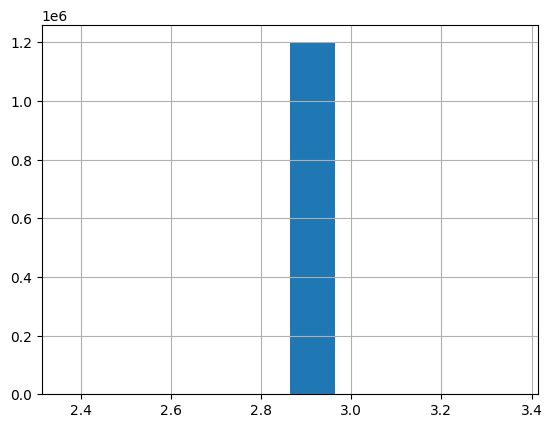

In [26]:
pd.Series(res).hist()

In [7]:
import miceforest as mf

In [5]:
kernel = mf.ImputationKernel(treated_dataset, num_datasets=1, random_state=1)


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Claim Frequency_null,Policy Start Year_null,Policy Start Month_null,Policy Start Day_null,Policy Start Hour_null,Policy Start Minute_null,Policy Start Second_null,Null columns_null,Annual Income log 10_null,Previous Claims log_null
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,...,False,False,False,False,False,False,False,False,False,False
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,...,False,False,False,False,False,False,False,False,False,False
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,...,False,False,False,False,False,False,False,False,False,False
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,...,False,False,False,False,False,False,False,False,False,False
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,...,True,False,False,False,False,False,False,False,False,True
1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,...,True,False,False,False,False,False,False,False,False,True
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,...,False,False,False,False,False,False,False,False,False,False
1199998,55.0,Male,NaN,Single,1.0,PhD,NaN,18.547381,Suburban,Premium,...,False,False,False,False,False,False,False,False,True,False


In [46]:
from optbinning import ContinuousOptimalBinning


In [108]:
ContinuousOptimalBinning?

Init signature:
ContinuousOptimalBinning(
    name='',
    dtype='numerical',
    prebinning_method='cart',
    max_n_prebins=20,
    min_prebin_size=0.05,
    min_n_bins=None,
    max_n_bins=None,
    min_bin_size=None,
    max_bin_size=None,
    monotonic_trend='auto',
    min_mean_diff=0,
    max_pvalue=None,
    max_pvalue_policy='consecutive',
    gamma=0,
    outlier_detector=None,
    outlier_params=None,
    cat_cutoff=None,
    cat_unknown=None,
    user_splits=None,
    user_splits_fixed=None,
    special_codes=None,
    split_digits=None,
    time_limit=100,
    verbose=False,
    **prebinning_kwargs,
)
Docstring:     
Optimal binning of a numerical or categorical variable with respect to a
continuous target.

Parameters
----------
name : str, optional (default="")
    The variable name.

dtype : str, optional (default="numerical")
    The variable data type. Supported data types are "numerical" for
    continuous and ordinal variables and "categorical" for categorical
    a

In [58]:
binning = ContinuousOptimalBinning(name="Premium Amount", dtype="numerical")
binning.fit(treated_dataset["Credit Score"], treated_dataset["Premium Amount"])



ContinuousOptimalBinning(name='Premium Amount')

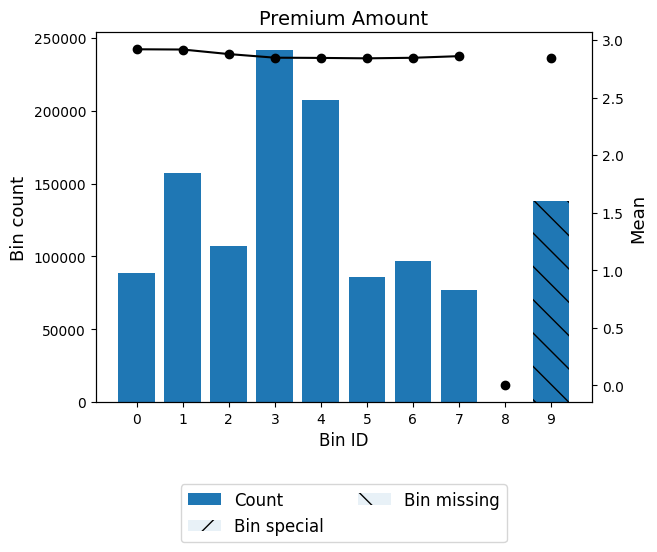

In [62]:
binning.binning_table.plot()


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit
from datetime import datetime
import numpy as np

# Define objective function
def objective(trial):
    param_grid = {
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'objective': 'regression',  # Use 'binary' for classification
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.1),  # Fine-tuned range
        'num_leaves': trial.suggest_int('num_leaves', 1, 50),  # Wider range for more exploration
        'max_depth': trial.suggest_int('max_depth', -1, 50),  # Allow deeper trees or unlimited depth (-1)
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 0.8),  # Sampling fraction of features
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.85, 1.0),  # Sampling fraction of data
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  # Frequency of bagging
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),  # Minimum samples per leaf
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-3, 0.1),  # Minimum gain for a split
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),  # Minimum weight for children
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10),  # L1 regularization
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10),  # L2 regularization
        'cat_smooth': trial.suggest_uniform('cat_smooth', 5, 30),  # Smoothing for categorical features
        'max_bin': trial.suggest_int('max_bin', 150, 200),  # Granularity of feature splits
        'verbose': -1,  # Suppress output
        'random_state': 41,  # Reproducibility
    }
    print(param_grid)
    
    # Define a 60-40 split
    splitter = ShuffleSplit(n_splits=5, test_size=0.4, random_state=1)


    results = []
    for train_idx, val_idx in splitter.split(X_train_fixed):
        # Prepare data for LightGBM
        X_train_fold, X_val_fold = X_train_fixed.iloc[train_idx], X_train_fixed.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        train_data_lgbm = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_data_lgbm = lgb.Dataset(X_val_fold, label=y_val_fold)
        
        # Train model
        model = lgb.train(
            param_grid,
            train_data_lgbm,
            num_boost_round=500,
            valid_sets=[train_data_lgbm, val_data_lgbm],
            valid_names=["train", "validation"],
            feval=rmsle_metric,    # Custom RMSLE metric
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=5),  # Optional: Logs evaluation every 10 rounds
            ]
        )
        results.append(model.best_score['validation']['rmsle'])
        
    # Use validation score
    return np.mean(results)